# Prediction of the peak half hour

In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle
import optuna
import matplotlib.pyplot as plt
from collections import Counter
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, make_scorer, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV
from optuna.samplers import TPESampler 
from pandas.tseries.offsets import DateOffset
from sklearn.multioutput import MultiOutputRegressor
from collections import defaultdict
from statistics import mean
from joblib import Parallel, delayed
from sklearn.svm import SVR, SVC
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import random
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

<br>

## Data loading

In [2]:
data = pd.read_csv("final_data.csv", usecols = ['time', 'temperature', 'relative_humidity', 'apparent_temperature', 'region', 'consumption'])
data['time'] = pd.to_datetime(data['time']) 

data.head(4)

,time,temperature,relative_humidity,apparent_temperature,region,consumption
0,2013-01-01 00:00:00,4.83,85.33,1.03,Auvergne-Rhône-Alpes,8173.0
1,2013-01-01 00:30:00,4.88,85.00,1.07,Auvergne-Rhône-Alpes,8173.0
2,2013-01-01 01:00:00,4.93,84.67,1.10,Auvergne-Rhône-Alpes,7944.0
3,2013-01-01 01:30:00,4.93,84.00,1.08,Auvergne-Rhône-Alpes,7896.0


<br>

Load the scenarios data:

In [3]:
with open('scenarios_final.pkl', 'rb') as scenarios_file:
    scenarios = pickle.load(scenarios_file)

<br>

What we have: 3 scenarios for 3 days identified as similar to the present date = 9 escenarios per date in the validation set:

In [4]:
scenarios_data = scenarios.get(('Auvergne-Rhône-Alpes', datetime.date(2020, 1, 1)), [])
len(scenarios_data)

9

In [5]:
length = {clave: len(valor) for clave, valor in scenarios.items() if len(valor) != 9}
len(length)

0

<br>

Data's structure:

In [6]:
scenarios_data[0].head(4)

,time,temperature,relative_humidity,apparent_temperature,weather_code,region,consumption
120479,2019-11-15 23:30:00,1.10,96.33,-1.55,3,Auvergne-Rhône-Alpes,9165.0
120480,2019-11-16 00:00:00,1.30,95.00,-1.50,3,Auvergne-Rhône-Alpes,8824.0
120481,2019-11-16 00:30:00,1.83,93.67,-0.77,11,Auvergne-Rhône-Alpes,8516.0
120482,2019-11-16 01:00:00,2.37,92.33,-0.03,19,Auvergne-Rhône-Alpes,8264.0


<br>

## Model Selection 


The formula we will use to predict the peak half hour will be the following:

$$Y(d+1) \sim C(d) + W(d+1) + Y(d) + Y(d+1-7) + weekday(d+1) + month(d+1) + region$$

or similarly,

$$Y(d) \sim C(d-1) + W(d) + Y(d-1) + Y(d-7) + weekday(d) + month(d) + region$$

<br>


## Data preparation

First, we will add a new **binary variable** representing the **peak half hour**.

In [7]:
data['peak_half_hour'] = 0

for region in data['region'].unique():
    region_data = data[data['region'] == region]
    max_consumption_index = region_data.groupby(region_data['time'].dt.date)['consumption'].idxmax()
    data.loc[max_consumption_index, 'peak_half_hour'] = 1

data.head(48)

,time,temperature,relative_humidity,apparent_temperature,region,consumption,peak_half_hour
0,2013-01-01 00:00:00,4.83,85.33,1.03,Auvergne-Rhône-Alpes,8173.0,0
1,2013-01-01 00:30:00,4.88,85.00,1.07,Auvergne-Rhône-Alpes,8173.0,0
2,2013-01-01 01:00:00,4.93,84.67,1.10,Auvergne-Rhône-Alpes,7944.0,0
3,2013-01-01 01:30:00,4.93,84.00,1.08,Auvergne-Rhône-Alpes,7896.0,0
4,2013-01-01 02:00:00,4.93,83.33,1.07,Auvergne-Rhône-Alpes,7882.0,0
5,2013-01-01 02:30:00,4.98,82.33,1.12,Auvergne-Rhône-Alpes,7909.0,0
6,2013-01-01 03:00:00,5.03,81.33,1.17,Auvergne-Rhône-Alpes,7709.0,0
7,2013-01-01 03:30:00,5.07,80.17,1.27,Auvergne-Rhône-Alpes,7561.0,0
8,2013-01-01 04:00:00,5.10,79.00,1.37,Auvergne-Rhône-Alpes,7383.0,0
9,2013-01-01 04:30:00,5.12,78.00,1.43,Auvergne-Rhône-Alpes,7249.0,0


<br>

Let's now create a new dataset, containing all **data grouped by date**. 

We will also add **5 new variables**: 
- weekday

- month

- consumption(d-1)

- peak_half_hour(d-1)

- peak_half_hour(d-7)

In [8]:
data['date'] = data['time'].dt.date

days_data = data.groupby(['date', 'region']).apply(lambda x: pd.Series({
    'date': x['date'].iloc[0],
    'region': x['region'].iloc[0],  
    'temperature': x['temperature'].values[:48],
    'apparent_temperature': x['apparent_temperature'].values[:48],
    'relative_humidity': x['relative_humidity'].values[:48],
    'consumption': x['consumption'].values[:48],
    'weekday': x['time'].dt.dayofweek.iloc[0],  
    'month': x['time'].dt.month.iloc[0],
    'peak_half_hour': x.index.get_loc(x[x['peak_half_hour'] == 1].index[0])
})).reset_index(drop=True)

In [9]:
days_data['date'] = pd.to_datetime(days_data['date'])
days_data = days_data.sort_values(by=['region', 'date'])

days_data['consumption(d-1)'] = days_data.groupby('region')['consumption'].shift(1)
days_data['peak_half_hour(d-1)'] = days_data.groupby('region')['peak_half_hour'].shift(1)
days_data['peak_half_hour(d-7)'] = days_data.groupby('region')['peak_half_hour'].shift(7)
days_data = days_data.dropna()

days_data.head(5)

,date,region,temperature,apparent_temperature,relative_humidity,consumption,weekday,month,peak_half_hour,consumption(d-1),peak_half_hour(d-1),peak_half_hour(d-7)
84,2013-01-08,Auvergne-Rhône-Alpes,"[0.6, 0.6, 0.6, 0.58, 0.57, 0.47, 0.37, 0.3, 0...","[-2.67, -2.63, -2.6, -2.58, -2.57, -2.63, -2.7...","[92.67, 92.33, 92.0, 91.33, 90.67, 90.67, 90.6...","[9129.0, 8860.0, 8692.0, 8633.0, 8673.0, 8791....",1,1,38,"[8312.0, 8214.0, 7892.0, 7930.0, 7941.0, 8045....",38.0,39.0
96,2013-01-09,Auvergne-Rhône-Alpes,"[0.1, -0.03, -0.17, -0.33, -0.5, -0.55, -0.6, ...","[-3.23, -3.38, -3.53, -3.68, -3.83, -3.87, -3....","[88.0, 88.0, 88.0, 88.33, 88.67, 88.33, 88.0, ...","[9488.0, 9304.0, 9084.0, 9054.0, 9102.0, 9175....",2,1,38,"[9129.0, 8860.0, 8692.0, 8633.0, 8673.0, 8791....",38.0,38.0
108,2013-01-10,Auvergne-Rhône-Alpes,"[0.1, -0.0, -0.1, -0.32, -0.53, -0.67, -0.8, -...","[-3.1, -3.2, -3.3, -3.57, -3.83, -3.98, -4.13,...","[87.0, 87.33, 87.67, 88.17, 88.67, 88.83, 89.0...","[9758.0, 9434.0, 9197.0, 9206.0, 9258.0, 9288....",3,1,23,"[9488.0, 9304.0, 9084.0, 9054.0, 9102.0, 9175....",38.0,38.0
120,2013-01-11,Auvergne-Rhône-Alpes,"[3.17, 3.42, 3.67, 3.75, 3.83, 3.97, 4.1, 4.23...","[0.6, 0.87, 1.13, 1.2, 1.27, 1.27, 1.27, 1.33,...","[95.67, 95.5, 95.33, 95.17, 95.0, 94.5, 94.0, ...","[9399.0, 9350.0, 9104.0, 9107.0, 9143.0, 9181....",4,1,23,"[9758.0, 9434.0, 9197.0, 9206.0, 9258.0, 9288....",23.0,23.0
132,2013-01-12,Auvergne-Rhône-Alpes,"[2.2, 2.08, 1.97, 1.8, 1.63, 1.5, 1.37, 1.22, ...","[-0.4, -0.42, -0.43, -0.7, -0.97, -1.12, -1.27...","[96.33, 96.67, 97.0, 97.67, 98.33, 98.5, 98.67...","[9503.0, 9300.0, 9038.0, 9045.0, 9069.0, 9106....",5,1,38,"[9399.0, 9350.0, 9104.0, 9107.0, 9143.0, 9181....",23.0,38.0


<br>

Let's convert our **lists** of values into **separate columns**.

In [10]:
model_data = days_data[['date', 'region', 'consumption(d-1)', 'temperature', 'apparent_temperature', 'relative_humidity', 'weekday', 'month', 'peak_half_hour', 'peak_half_hour(d-1)', 'peak_half_hour(d-7)']].copy()

new_column_names = [f"{col}_{i+1}" for col in ['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)'] for i in range(48)]

data_expanded = pd.DataFrame()

for col in ['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)']:
    expanded_cols = pd.DataFrame(model_data[col].tolist(), columns=[f"{col}_{i+1}" for i in range(48)])
    data_expanded = pd.concat([data_expanded, expanded_cols], axis=1)

model_data.reset_index(drop=True, inplace=True)
data_expanded.reset_index(drop=True, inplace=True)

model_data_expanded = pd.concat([model_data, data_expanded], axis=1)
model_data_expanded = model_data_expanded.drop(['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)'], axis=1)

model_data_expanded.head(5)

,date,region,weekday,month,peak_half_hour,peak_half_hour(d-1),peak_half_hour(d-7),temperature_1,temperature_2,temperature_3,...,consumption(d-1)_39,consumption(d-1)_40,consumption(d-1)_41,consumption(d-1)_42,consumption(d-1)_43,consumption(d-1)_44,consumption(d-1)_45,consumption(d-1)_46,consumption(d-1)_47,consumption(d-1)_48
0,2013-01-08,Auvergne-Rhône-Alpes,1,1,38,38.0,39.0,0.60,0.60,0.60,...,10539.0,10279.0,9955.0,9747.0,9520.0,9314.0,8987.0,9118.0,9341.0,9441.0
1,2013-01-09,Auvergne-Rhône-Alpes,2,1,38,38.0,38.0,0.10,-0.03,-0.17,...,10785.0,10589.0,10286.0,10111.0,9902.0,9633.0,9345.0,9516.0,9715.0,9800.0
2,2013-01-10,Auvergne-Rhône-Alpes,3,1,23,38.0,38.0,0.10,-0.00,-0.10,...,11199.0,10990.0,10688.0,10438.0,10220.0,9915.0,9651.0,9838.0,9987.0,10076.0
3,2013-01-11,Auvergne-Rhône-Alpes,4,1,23,23.0,23.0,3.17,3.42,3.67,...,11017.0,10800.0,10448.0,10269.0,9989.0,9718.0,9376.0,9515.0,9694.0,9761.0
4,2013-01-12,Auvergne-Rhône-Alpes,5,1,38,23.0,38.0,2.20,2.08,1.97,...,10492.0,10385.0,10029.0,9910.0,9713.0,9539.0,9281.0,9487.0,9709.0,9852.0


<br>

- #### Regression approach

In [11]:
train_data_num = model_data_expanded[model_data_expanded['date'].dt.year <= 2019]
test_data_num = model_data_expanded[model_data_expanded['date'].dt.year == 2020] 

X_train_num = train_data_num.drop(columns=['peak_half_hour', 'date'])
y_train_num = train_data_num['peak_half_hour']

X_test_num = test_data_num.drop(columns=['peak_half_hour', 'date'])
y_test_num = test_data_num['peak_half_hour']

<br>

Ensure each variable is in the correct **format**.

In [12]:
for df in [X_train_num, X_test_num]:
    df['peak_half_hour(d-1)'] = df['peak_half_hour(d-1)'].astype(int)
    df['peak_half_hour(d-7)'] = df['peak_half_hour(d-7)'].astype(int)
    
    df['month'] = df['month'].astype('category')
    df['weekday'] = df['weekday'].astype('category')

for target in [y_train_num, y_test_num]:
    target = target.astype(int)

<br>

**Scale** numerical variables and create **dummies** for the categorical ones.

In [13]:
numerical_columns_num = X_train_num.columns.difference(['region', 'month', 'weekday', 'peak_half_hour(d-1)', 'peak_half_hour(d-7)'])
categorical_columns_num = ['region', 'month', 'weekday']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns_num),
        ('cat', categorical_transformer, categorical_columns_num)
    ],
    remainder='passthrough'  
)

pipeline_num = Pipeline(steps=[('preprocessor', preprocessor)])

<br>

Create a function to calculate the **±1 hour range accuracy**:

In [14]:
def within_range_num(y_test, y_pred):
    accuracy = np.sum(np.abs(y_test - y_pred) <= 2) / len(y_test) * 100
    return accuracy

<br>

- #### Classification approach

Now, we will repeat the same steps considering the 'peak_half_hour' variables as categorical.

In [15]:
train_data_cat = model_data_expanded[model_data_expanded['date'].dt.year <= 2019]
test_data_cat = model_data_expanded[model_data_expanded['date'].dt.year == 2020] 

X_train_cat = train_data_cat.drop(columns=['peak_half_hour', 'date'])
y_train_cat = train_data_cat['peak_half_hour']

X_test_cat = test_data_cat.drop(columns=['peak_half_hour', 'date'])
y_test_cat = test_data_cat['peak_half_hour']

In [16]:
for df in [X_train_cat, X_test_cat]:
    df['peak_half_hour(d-1)'] = df['peak_half_hour(d-1)'].astype('category')
    df['peak_half_hour(d-7)'] = df['peak_half_hour(d-7)'].astype('category')
    
    df['month'] = df['month'].astype('category')
    df['weekday'] = df['weekday'].astype('category')

for target in [y_train_cat, y_test_cat]:
    target = target.astype('category')

<br>


In [17]:
numerical_columns_cat = X_train_cat.columns.difference(['region', 'month', 'weekday', 'peak_half_hour(d-1)', 'peak_half_hour(d-7)'])
categorical_columns_cat = ['region', 'month', 'weekday', 'peak_half_hour(d-1)', 'peak_half_hour(d-7)']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns_cat),
        ('cat', categorical_transformer, categorical_columns_cat)
    ],
    remainder='passthrough'  
)

pipeline_cat = Pipeline(steps=[('preprocessor', preprocessor)])

<br>

In [18]:
def within_range_cat(y_test, y_pred):
    accuracy = np.sum(np.abs(y_test.astype(int) - y_pred.astype(int)) <= 2) / len(y_test) * 100
    return accuracy

<br>

- #### Cyclic approach

In the regression case, our set of 'peak_half_hour' variables spans from 0 to 48 in a linear manner.  
In this new approach, we will regard this data as cyclic, computing its **sine** and **cosine** values.

In [19]:
train_data_cyclic = model_data_expanded[model_data_expanded['date'].dt.year <= 2019]
test_data_cyclic = model_data_expanded[model_data_expanded['date'].dt.year == 2020] 

In [20]:
# x = seq(0, 47, 1)
# sx = sin(2*pi*x/48)
# cx = cos(2*pi*x/48)
# y = cbind(sx, cx)

def make_circular_variables(df):
    for var_suffix in ['', '(d-1)', '(d-7)']:
        var_name = f"{'peak_half_hour'}{var_suffix}"
        angle_rad = 2 * np.pi * df[var_name] / 48
        sx_values = np.sin(angle_rad)
        cx_values = np.cos(angle_rad)
        df.loc[:, f"{var_name}_sx"] = sx_values
        df.loc[:, f"{var_name}_cx"] = cx_values

        if var_suffix != '':
            df.drop(columns=[var_name], inplace=True)
    return df

train_data_cyclic = make_circular_variables(train_data_cyclic.copy())
test_data_cyclic = make_circular_variables(test_data_cyclic.copy())

train_data_cyclic.head(5)

,date,region,weekday,month,peak_half_hour,temperature_1,temperature_2,temperature_3,temperature_4,temperature_5,...,consumption(d-1)_45,consumption(d-1)_46,consumption(d-1)_47,consumption(d-1)_48,peak_half_hour_sx,peak_half_hour_cx,peak_half_hour(d-1)_sx,peak_half_hour(d-1)_cx,peak_half_hour(d-7)_sx,peak_half_hour(d-7)_cx
0,2013-01-08,Auvergne-Rhône-Alpes,1,1,38,0.60,0.60,0.60,0.58,0.57,...,8987.0,9118.0,9341.0,9441.0,-0.965926,0.258819,-0.965926,0.258819,-0.923880,0.382683
1,2013-01-09,Auvergne-Rhône-Alpes,2,1,38,0.10,-0.03,-0.17,-0.33,-0.50,...,9345.0,9516.0,9715.0,9800.0,-0.965926,0.258819,-0.965926,0.258819,-0.965926,0.258819
2,2013-01-10,Auvergne-Rhône-Alpes,3,1,23,0.10,-0.00,-0.10,-0.32,-0.53,...,9651.0,9838.0,9987.0,10076.0,0.130526,-0.991445,-0.965926,0.258819,-0.965926,0.258819
3,2013-01-11,Auvergne-Rhône-Alpes,4,1,23,3.17,3.42,3.67,3.75,3.83,...,9376.0,9515.0,9694.0,9761.0,0.130526,-0.991445,0.130526,-0.991445,0.130526,-0.991445
4,2013-01-12,Auvergne-Rhône-Alpes,5,1,38,2.20,2.08,1.97,1.80,1.63,...,9281.0,9487.0,9709.0,9852.0,-0.965926,0.258819,0.130526,-0.991445,-0.965926,0.258819


<br>

Transformation check:

In [21]:
def circular_to_original(y_pred_cyclic):
    original_values = []
    for pred in y_pred_cyclic:
        sx_pred = pred[0]  
        cx_pred = pred[1]  
        angle_rad = np.arctan2(sx_pred, cx_pred)  
        if angle_rad < 0:
            angle_rad += 2 * np.pi  
        original_value = (angle_rad / (2 * np.pi)) * 48  
        original_values.append(original_value)
    return original_values

original_values = circular_to_original(train_data_cyclic[['peak_half_hour_sx','peak_half_hour_cx']].values)
originals_df = pd.DataFrame({'Transformed value': original_values, 'Real value': train_data_cyclic['peak_half_hour']})
originals_df = originals_df.round().astype(int)

originals_df.head(5)

,Transformed value,Real value
0,38,38
1,38,38
2,23,23
3,23,23
4,38,38


<br>

In [22]:
unique_transformed_values = sorted(originals_df['Transformed value'].unique())
np.array(unique_transformed_values)

array([ 0,  1,  3,  4, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47])

<br>

In [23]:
X_train_cyclic = train_data_cyclic.drop(columns=['peak_half_hour', 'peak_half_hour_sx', 'peak_half_hour_cx', 'date'])
y_train_cyclic = train_data_cyclic[['peak_half_hour_sx', 'peak_half_hour_cx']]

X_test_cyclic = test_data_cyclic.drop(columns=['peak_half_hour', 'peak_half_hour_sx', 'peak_half_hour_cx', 'date'])
y_test_cyclic = test_data_cyclic[['peak_half_hour_sx', 'peak_half_hour_cx']]

y_test_original = y_test_num

In [24]:
for df in [X_train_cyclic, X_test_cyclic]:  
    df['month'] = df['month'].astype('category')
    df['weekday'] = df['weekday'].astype('category')

<br>

In [25]:
numerical_columns_cyclic = X_train_cyclic.columns.difference(['region', 'month', 'weekday'])
categorical_columns_cyclic = ['region', 'month', 'weekday']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns_cyclic),
        ('cat', categorical_transformer, categorical_columns_cyclic)
    ],
    remainder='passthrough'  
)

pipeline_cyclic = Pipeline(steps=[('preprocessor', preprocessor)])

<br>

- #### Scenarios data

In reality, we will not have access to tomorrow's meteorological data (the day we are forecasting), so we will now employ the data from previously generated scenarios.

In [26]:
test_data = days_data[days_data['date'].dt.year == 2020].drop(columns='consumption')

new_test_data = pd.DataFrame()

for index, row in test_data.iterrows():
    date = row['date'].to_pydatetime().date()
    region = row['region']  
    
    scenarios_region = scenarios.get((region, date), [])
    
    for i, scenario in enumerate(scenarios_region): 
        lists = {}
        
        for col in ['temperature', 'apparent_temperature', 'relative_humidity']:
            lists[col] = scenario[col].tolist()
                
        temperature = lists['temperature']
        apparent_temperature = lists['apparent_temperature']
        relative_humidity = lists['relative_humidity']
        
        modified_row = row.copy()
        modified_row['temperature'] = temperature
        modified_row['apparent_temperature'] = apparent_temperature
        modified_row['relative_humidity'] = relative_humidity
        
        new_test_data = pd.concat([new_test_data, modified_row.to_frame().transpose()], ignore_index=True)

new_test_data.head(5)

,date,region,temperature,apparent_temperature,relative_humidity,weekday,month,peak_half_hour,consumption(d-1),peak_half_hour(d-1),peak_half_hour(d-7)
0,2020-01-01,Auvergne-Rhône-Alpes,"[1.1, 1.3, 1.83, 2.37, 1.92, 1.47, 0.95, 0.43,...","[-1.55, -1.5, -0.77, -0.03, -0.62, -1.2, -1.93...","[96.33, 95.0, 93.67, 92.33, 94.17, 96.0, 95.83...",2,1,47,"[8890.0, 8674.0, 8432.0, 8426.0, 8415.0, 8500....",20.0,47.0
1,2020-01-01,Auvergne-Rhône-Alpes,"[1.3, 1.83, 2.37, 1.92, 1.47, 0.95, 0.43, 0.42...","[-1.5, -0.77, -0.03, -0.62, -1.2, -1.93, -2.67...","[95.0, 93.67, 92.33, 94.17, 96.0, 95.83, 95.67...",2,1,47,"[8890.0, 8674.0, 8432.0, 8426.0, 8415.0, 8500....",20.0,47.0
2,2020-01-01,Auvergne-Rhône-Alpes,"[1.83, 2.37, 1.92, 1.47, 0.95, 0.43, 0.42, 0.4...","[-0.77, -0.03, -0.62, -1.2, -1.93, -2.67, -2.6...","[93.67, 92.33, 94.17, 96.0, 95.83, 95.67, 95.8...",2,1,47,"[8890.0, 8674.0, 8432.0, 8426.0, 8415.0, 8500....",20.0,47.0
3,2020-01-01,Auvergne-Rhône-Alpes,"[2.02, 2.57, 2.7, 2.83, 2.8, 2.77, 2.7, 2.63, ...","[-1.0, -0.43, -0.35, -0.27, -0.38, -0.5, -0.53...","[94.67, 93.33, 91.67, 90.0, 90.17, 90.33, 89.6...",2,1,47,"[8890.0, 8674.0, 8432.0, 8426.0, 8415.0, 8500....",20.0,47.0
4,2020-01-01,Auvergne-Rhône-Alpes,"[2.57, 2.7, 2.83, 2.8, 2.77, 2.7, 2.63, 2.62, ...","[-0.43, -0.35, -0.27, -0.38, -0.5, -0.53, -0.5...","[93.33, 91.67, 90.0, 90.17, 90.33, 89.67, 89.0...",2,1,47,"[8890.0, 8674.0, 8432.0, 8426.0, 8415.0, 8500....",20.0,47.0


<br>

Check if the new testing set has the correct dimensions.

In [27]:
len(new_test_data)/9 == len(y_test_num)

True

<br>

Proceed as before:

In [28]:
new_column_names = [f"{col}_{i+1}" for col in ['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)'] for i in range(48)]

data_expanded = pd.DataFrame()

for col in ['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)']:
    expanded_cols = pd.DataFrame(new_test_data[col].tolist(), columns=[f"{col}_{i+1}" for i in range(48)])
    data_expanded = pd.concat([data_expanded, expanded_cols], axis=1)

new_test_data.reset_index(drop=True, inplace=True)
data_expanded.reset_index(drop=True, inplace=True)

new_test_data_expanded = pd.concat([new_test_data, data_expanded], axis=1)
new_test_data_expanded = new_test_data_expanded.drop(['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)'], axis=1)

new_test_data_expanded = new_test_data_expanded.sort_values(by=['region', 'date'])

new_test_data_expanded.head(5)

,date,region,weekday,month,peak_half_hour,peak_half_hour(d-1),peak_half_hour(d-7),temperature_1,temperature_2,temperature_3,...,consumption(d-1)_39,consumption(d-1)_40,consumption(d-1)_41,consumption(d-1)_42,consumption(d-1)_43,consumption(d-1)_44,consumption(d-1)_45,consumption(d-1)_46,consumption(d-1)_47,consumption(d-1)_48
0,2020-01-01,Auvergne-Rhône-Alpes,2,1,47,20.0,47.0,1.10,1.30,1.83,...,9226.0,9132.0,8916.0,8763.0,8625.0,8487.0,8351.0,8617.0,8964.0,9133.0
1,2020-01-01,Auvergne-Rhône-Alpes,2,1,47,20.0,47.0,1.30,1.83,2.37,...,9226.0,9132.0,8916.0,8763.0,8625.0,8487.0,8351.0,8617.0,8964.0,9133.0
2,2020-01-01,Auvergne-Rhône-Alpes,2,1,47,20.0,47.0,1.83,2.37,1.92,...,9226.0,9132.0,8916.0,8763.0,8625.0,8487.0,8351.0,8617.0,8964.0,9133.0
3,2020-01-01,Auvergne-Rhône-Alpes,2,1,47,20.0,47.0,2.02,2.57,2.70,...,9226.0,9132.0,8916.0,8763.0,8625.0,8487.0,8351.0,8617.0,8964.0,9133.0
4,2020-01-01,Auvergne-Rhône-Alpes,2,1,47,20.0,47.0,2.57,2.70,2.83,...,9226.0,9132.0,8916.0,8763.0,8625.0,8487.0,8351.0,8617.0,8964.0,9133.0


<br>

Since all non-meteorological data remains consistent across each set of 9 observations (given the 9 scenarios per date), it appears that the observations are entirely duplicated. However, upon closer inspection, variations in temperature, for example, indicate that these values change for the same date.

In [29]:
new_test_data_expanded[['date', 'temperature_1']].head(5)

,date,temperature_1
0,2020-01-01,1.10
1,2020-01-01,1.30
2,2020-01-01,1.83
3,2020-01-01,2.02
4,2020-01-01,2.57


<br>

In [30]:
X_test_num_scenarios = new_test_data_expanded.drop(columns=['peak_half_hour', 'date'])
y_test_num_scenarios = new_test_data_expanded['peak_half_hour']

In [31]:
X_test_num_scenarios['peak_half_hour(d-1)'] = X_test_num_scenarios['peak_half_hour(d-1)'].astype(int)
X_test_num_scenarios['peak_half_hour(d-7)'] = X_test_num_scenarios['peak_half_hour(d-7)'].astype(int)

X_test_num_scenarios['month'] = X_test_num_scenarios['month'].astype('category')
X_test_num_scenarios['weekday'] = X_test_num_scenarios['weekday'].astype('category')

y_test_num_scenarios = y_test_num_scenarios.astype(int)

<br>

In [32]:
X_test_cat_scenarios = new_test_data_expanded.drop(columns=['peak_half_hour', 'date'])
y_test_cat_scenarios = new_test_data_expanded['peak_half_hour']

In [33]:
X_test_cat_scenarios['peak_half_hour(d-1)'] = X_test_cat_scenarios['peak_half_hour(d-1)'].astype('category')
X_test_cat_scenarios['peak_half_hour(d-7)'] = X_test_cat_scenarios['peak_half_hour(d-7)'].astype('category')

X_test_cat_scenarios['month'] = X_test_cat_scenarios['month'].astype('category')
X_test_cat_scenarios['weekday'] = X_test_cat_scenarios['weekday'].astype('category')

y_test_cat_scenarios = y_test_cat_scenarios.astype(int)

<br>

In [34]:
new_test_data_expanded['peak_half_hour'] = new_test_data_expanded['peak_half_hour'].astype(int)
new_test_data_expanded['peak_half_hour(d-1)'] = new_test_data_expanded['peak_half_hour(d-1)'].astype(int)
new_test_data_expanded['peak_half_hour(d-7)'] = new_test_data_expanded['peak_half_hour(d-7)'].astype(int)

new_test_data_cyclic = make_circular_variables(new_test_data_expanded)

In [35]:
X_test_cyclic_scenarios = new_test_data_cyclic.drop(columns=['peak_half_hour', 'peak_half_hour_sx', 'peak_half_hour_cx', 'date'])
y_test_cyclic_scenarios = new_test_data_cyclic[['peak_half_hour_sx', 'peak_half_hour_cx']]

y_test_original_scenarios = new_test_data_cyclic['peak_half_hour']

In [36]:
X_test_cyclic_scenarios['month'] = X_test_cyclic_scenarios['month'].astype('category')
X_test_cyclic_scenarios['weekday'] = X_test_cyclic_scenarios['weekday'].astype('category')

y_test_cyclic_scenarios = y_test_cyclic_scenarios.astype(int)

<br>

## Naive models

- ### Taking the index with highest consumption from the previous day

In [7]:
total_correct = 0
total_range = 0
total_error = 0
total_samples = 0

for region, date in scenarios.keys():  
    real_data = data[(data['region'] == region) & (data['time'].dt.date == date)]    
    real_data.index = range(1, 49)
    real_index = real_data['consumption'].idxmax()
    
    previous_date = date - timedelta(days=1)
    previous_real_data = data[(data['region'] == region) & (data['time'].dt.date == previous_date)]
    previous_real_data.index = range(1, 49)
    previous_index = previous_real_data['consumption'].idxmax()

    if real_index == previous_index:
        total_correct += 1
    
    if abs(real_index - previous_index) <=2:
        total_range += 1
        
    error = abs(real_index - previous_index)
    total_error += error 
    
    total_samples += 1

accuracy = total_correct / total_samples * 100
within_range_accuracy = total_range / total_samples * 100
mae = total_error / total_samples

print(f"Accuracy: {round(accuracy,2)} %")
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')
print(f"MAE: {round(mae,2)}")

Accuracy: 43.26 %
Accuracy within a ±1 hour range: 59.49 %
MAE: 7.81


<br>

- ### Taking the index with highest consumption from the previous week

In [8]:
total_error = 0
total_correct = 0
total_range = 0
total_samples = 0

for region, date in scenarios.keys():  
    real_data = data[(data['region'] == region) & (data['time'].dt.date == date)]    
    real_data.index = range(1, 49)
    real_index = real_data['consumption'].idxmax()
    
    previous_date = date - timedelta(days=7)
    previous_real_data = data[(data['region'] == region) & (data['time'].dt.date == previous_date)]
    previous_real_data.index = range(1, 49)
    previous_index = previous_real_data['consumption'].idxmax()

    if real_index == previous_index:
        total_correct += 1

    if abs(real_index - previous_index) <=2:
        total_range += 1
    
    error = abs(real_index - previous_index)
    total_error += error 
    
    total_samples += 1

accuracy = total_correct / total_samples * 100
within_range_accuracy = total_range / total_samples * 100
mae = total_error / total_samples

print(f"Accuracy: {round(accuracy,2)} %")
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')
print(f"MAE: {round(mae,2)}")

Accuracy: 48.61 %
Accuracy within a ±1 hour range: 65.94 %
MAE: 6.16


<br>


Let's now implement the model.

## Random Forest

*  ### Regression approach

In [37]:
X_train_num_rf = pipeline_num.fit_transform(X_train_num)
X_test_num_rf = pipeline_num.transform(X_test_num)

In [38]:
rf_model_num = RandomForestRegressor(random_state=42)
rf_model_num.fit(X_train_num_rf, y_train_num)

y_pred = rf_model_num.predict(X_test_num_rf)
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num).sum() / len(y_test_num) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_num, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_num, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 14.96 %
Accuracy within a ±1 hour range: 43.1 %

MAE of unrounded values: 5.72
MAE of rounded values: 5.7


<br>

Should we do **PCA**?

In [39]:
pipeline_num_pca = Pipeline(steps=[('pca', PCA())])

X_train_num_rf_pca = pipeline_num_pca.fit_transform(X_train_num_rf)
X_test_num_rf_pca = pipeline_num_pca.transform(X_test_num_rf)

In [40]:
rf_model_num = RandomForestRegressor(random_state=42)
rf_model_num.fit(X_train_num_rf_pca, y_train_num)

y_pred = rf_model_num.predict(X_test_num_rf_pca)
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num).sum() / len(y_test_num) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_num, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_num, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 12.57 %
Accuracy within a ±1 hour range: 40.98 %

MAE of unrounded values: 5.95
MAE of rounded values: 5.94



|              | **Accuracy** | **±1 hour range accuracy** |**MAE**|
|--------------------------|---------|--------------|----------------------------|
| Without PCA           | **14.96**        | **43.10**                       | **5.70** |
| With PCA              | 12.57        | 40.98                   | 5.94      |



<br>

**Best approach**: Without PCA. 

<br>

#### Hyperparameter tuning

In [18]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2', 0.05, 0.2, 0.5, 1]),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, step=2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20, step=2)
    }

    rf = RandomForestRegressor(random_state=42, **params)
    scores = cross_val_score(rf, X_train_num_rf, y_train_num, scoring='neg_mean_absolute_error', cv=5, n_jobs=5)
    inner_acc = -scores.mean()

    return inner_acc

budget = 30 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='minimize',sampler=sampler,study_name='RF')
study.optimize(objective, n_trials= budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-08 13:52:57,247] A new study created in memory with name: RF
[I 2024-05-08 15:20:44,776] Trial 0 finished with value: 7.351304137943285 and parameters: {'n_estimators': 250, 'max_features': None, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 7.351304137943285.
[I 2024-05-08 15:30:07,739] Trial 1 finished with value: 7.547083896408049 and parameters: {'n_estimators': 150, 'max_features': 0.2, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 0 with value: 7.351304137943285.
[I 2024-05-08 15:34:30,867] Trial 2 finished with value: 8.189134802936744 and parameters: {'n_estimators': 350, 'max_features': 0.05, 'max_depth': None, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 0 with value: 7.351304137943285.
[I 2024-05-08 15:52:52,443] Trial 3 finished with value: 7.452300738975604 and parameters: {'n_estimators': 350, 'max_features': 0.2, 'max_depth': 20, 'min_samples_split': 2, 'min_samp

Best hyperparameters: {'n_estimators': 350, 'max_features': 0.5, 'max_depth': None, 'min_samples_split': 16, 'min_samples_leaf': 12}


<br>

In [41]:
best_params = {'n_estimators': 350, 'max_features': 0.5, 'max_depth': None, 'min_samples_split': 16, 'min_samples_leaf': 12}

In [42]:
rf_model_num_best = RandomForestRegressor(random_state=42, **best_params)
rf_model_num_best.fit(X_train_num_rf, y_train_num)

y_pred = rf_model_num_best.predict(X_test_num_rf)
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num).sum() / len(y_test_num) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_num, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_num, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 13.68 %
Accuracy within a ±1 hour range: 43.88 %

MAE of unrounded values: 5.61
MAE of rounded values: 5.59


<br>


#### Using scenarios 

In [43]:
X_test_num_scenarios_rf = pipeline_num.transform(X_test_num_scenarios)

In [44]:
y_pred = rf_model_num_best.predict(X_test_num_scenarios_rf)
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num_scenarios).sum() / len(y_test_num_scenarios) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_num_scenarios, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num_scenarios, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_num_scenarios, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 12.8 %
Accuracy within a ±1 hour range: 41.29 %

MAE of unrounded values: 6.21
MAE of rounded values: 6.2


<br>

This time, accuracy will be assessed **collectively** rather than individually, by considering the most common prediction among the 9 scenarios for each date.

In [45]:
y_pred_groups = [y_pred_red[i:i+9] for i in range(0, len(y_pred_red), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_num

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred_red = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common rounded values:", round(mae_y_pred_red,2))

Accuracy: 13.66 %
Accuracy within a ±1 hour range: 42.3 %

MAE of most common rounded values: 6.12


<br> 

* ### Classification approach

In [46]:
X_train_cat_rf = pipeline_cat.fit_transform(X_train_cat)
X_test_cat_rf = pipeline_cat.transform(X_test_cat)

In [47]:
rf_model_cat = RandomForestClassifier(random_state=42)
rf_model_cat.fit(X_train_cat_rf, y_train_cat)

y_pred = rf_model_cat.predict(X_test_cat_rf)

accuracy = (y_pred == y_test_cat).sum() / len(y_test_cat) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy,2)} %')

mae_y_pred_red = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred_red,2))

Accuracy: 55.15 %
Accuracy within a ±1 hour range: 70.17 %

MAE: 5.4


<br>

Should we do **PCA**?

In [48]:
pipeline_cat_pca = Pipeline(steps=[('pca', PCA())])

X_train_cat_rf_pca = pipeline_cat_pca.fit_transform(X_train_cat_rf)
X_test_cat_rf_pca = pipeline_cat_pca.transform(X_test_cat_rf)

In [49]:
rf_model_cat_pca = RandomForestClassifier(random_state=42)
rf_model_cat_pca.fit(X_train_cat_rf_pca, y_train_cat)

y_pred = rf_model_cat_pca.predict(X_test_cat_rf_pca)

accuracy = (y_pred == y_test_cat).sum() / len(y_test_cat) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy,2)} %')

mae_y_pred_red = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred_red,2))

Accuracy: 54.42 %
Accuracy within a ±1 hour range: 68.78 %

MAE: 5.84



|          |  **Accuracy** | **±1 hour range accuracy** |**MAE** |
|--------------------------|---------|--------------|----------------------------|
| Without PCA          |  **55.15**        | **70.17**                      |**5.40**     |
| With PCA            |  54.42        | 68.78                      |5.84    |

<br>

**Best approach**: Without PCA.  

<br>

#### Hyperparameter tuning

In [30]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2', 0.05, 0.2, 0.5, 1]),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, step=2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20, step=2)
    }

    rf = RandomForestClassifier(random_state=42, **params)
    scores = cross_val_score(rf, X_train_cat_rf, y_train_cat, scoring='accuracy', cv=5, n_jobs=5)
    inner_acc = scores.mean()

    return inner_acc

budget = 30 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize',sampler=sampler,study_name='RF')
study.optimize(objective, n_trials= budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-09 15:05:46,880] A new study created in memory with name: RF
[I 2024-05-09 16:06:38,278] Trial 0 finished with value: 0.3486665787012683 and parameters: {'n_estimators': 250, 'max_features': None, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.3486665787012683.
[I 2024-05-09 16:13:41,520] Trial 1 finished with value: 0.3578528811313312 and parameters: {'n_estimators': 150, 'max_features': 0.2, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.3578528811313312.
[I 2024-05-09 16:16:55,535] Trial 2 finished with value: 0.3567735681400229 and parameters: {'n_estimators': 350, 'max_features': 0.05, 'max_depth': None, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.3578528811313312.
[I 2024-05-09 16:30:07,632] Trial 3 finished with value: 0.36713761823156094 and parameters: {'n_estimators': 350, 'max_features': 0.2, 'max_depth': 20, 'min_samples_split': 2, '

Best hyperparameters: {'n_estimators': 450, 'max_features': 0.2, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 18}


<br>

In [50]:
best_params = {'n_estimators': 450, 'max_features': 0.2, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 18}

In [51]:
rf_model_cat_best = RandomForestClassifier(random_state=42, **best_params)
rf_model_cat_best.fit(X_train_cat_rf, y_train_cat)

y_pred = rf_model_cat_best.predict(X_test_cat_rf)

accuracy = (y_pred == y_test_cat).sum() / len(y_test_cat) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy,2)} %')

mae_y_pred_red = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred_red,2))

Accuracy: 53.85 %
Accuracy within a ±1 hour range: 68.42 %

MAE: 5.91


<br>

#### Using scenarios

In [52]:
X_test_cat_scenarios_rf = pipeline_cat.transform(X_test_cat_scenarios)

In [53]:
y_pred = rf_model_cat_best.predict(X_test_cat_scenarios_rf)

accuracy = (y_pred == y_test_cat_scenarios).sum() / len(y_test_cat_scenarios) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_cat(y_test_cat_scenarios, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy,2)} %')

mae_y_pred_red = mean_absolute_error(y_test_cat_scenarios, y_pred)
print("\nMAE:", round(mae_y_pred_red,2))

Accuracy: 52.04 %
Accuracy within a ±1 hour range: 66.55 %

MAE: 6.32



<br>

**Collectively**:

In [54]:
y_pred_groups = [y_pred[i:i+9] for i in range(0, len(y_pred), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_cat

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common values:", round(mae_y_pred,2))

Accuracy: 52.5 %
Accuracy within a ±1 hour range: 66.87 %

MAE of most common values: 6.26


<br> 

* ### Cyclic approach

In [55]:
X_train_cyclic_rf = pipeline_cyclic.fit_transform(X_train_cyclic)
X_test_cyclic_rf = pipeline_cyclic.transform(X_test_cyclic)

In [56]:
rf_model_cyclic = RandomForestRegressor(random_state=42)
multioutput_rf_model = MultiOutputRegressor(rf_model_cyclic)
multioutput_rf_model.fit(X_train_cyclic_rf, y_train_cyclic)

y_pred_cyclic = multioutput_rf_model.predict(X_test_cyclic_rf)

mae = mean_absolute_error(y_test_cyclic, y_pred_cyclic)
print("MAE:", round(mae, 2))

MAE: 0.32


In [57]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original).sum() / len(y_test_original) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 26.89 %
Accuracy within a ±1 hour range: 57.83 %

MAE of unrounded values: 7.21
MAE of rounded values: 5.98


<br>

#### Hyperparameter tuning

In [45]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2', 0.05, 0.2, 0.5, 1]),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, step=2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20, step=2)
    }

    rf = RandomForestRegressor(random_state=42, **params)
    multioutput_rf = MultiOutputRegressor(rf)
    
    scores = cross_val_score(multioutput_rf, X_train_cyclic_rf, y_train_cyclic, scoring='neg_mean_absolute_error', cv=5, n_jobs=5)
    inner_acc = -scores.mean()

    return inner_acc

budget = 30 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='minimize',sampler=sampler,study_name='RF')
study.optimize(objective, n_trials= budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-09 23:03:22,241] A new study created in memory with name: RF
[I 2024-05-10 00:56:04,989] Trial 0 finished with value: 0.34082938257696166 and parameters: {'n_estimators': 250, 'max_features': None, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.34082938257696166.
[I 2024-05-10 01:06:45,898] Trial 1 finished with value: 0.3585601772193882 and parameters: {'n_estimators': 150, 'max_features': 0.2, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.34082938257696166.
[I 2024-05-10 01:12:01,562] Trial 2 finished with value: 0.41225690763081885 and parameters: {'n_estimators': 350, 'max_features': 0.05, 'max_depth': None, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.34082938257696166.
[I 2024-05-10 01:33:19,483] Trial 3 finished with value: 0.3548792035412926 and parameters: {'n_estimators': 350, 'max_features': 0.2, 'max_depth': 20, 'min_samples_split': 

Best hyperparameters: {'n_estimators': 400, 'max_features': 0.5, 'max_depth': 40, 'min_samples_split': 14, 'min_samples_leaf': 10}


<br>

In [58]:
best_params = {'n_estimators': 400, 'max_features': 0.5, 'max_depth': 40, 'min_samples_split': 14, 'min_samples_leaf': 10}

In [59]:
rf_model_cyclic_best = RandomForestRegressor(random_state=42, **best_params)
multioutput_rf_model_best = MultiOutputRegressor(rf_model_cyclic_best)
multioutput_rf_model_best.fit(X_train_cyclic_rf, y_train_cyclic)

y_pred_cyclic = multioutput_rf_model_best.predict(X_test_cyclic_rf)

mae = mean_absolute_error(y_test_cyclic, y_pred_cyclic)
print("MAE:", round(mae, 2))

MAE: 0.31


In [60]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original).sum() / len(y_test_original) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 27.23 %
Accuracy within a ±1 hour range: 59.06 %

MAE of unrounded values: 7.16
MAE of rounded values: 6.02


<br>

#### Using scenarios

In [61]:
X_test_cyclic_scenarios_rf = pipeline_cyclic.transform(X_test_cyclic_scenarios)

In [62]:
y_pred_cyclic = multioutput_rf_model_best.predict(X_test_cyclic_scenarios_rf)

mae = mean_absolute_error(y_test_cyclic_scenarios, y_pred_cyclic)
print("MAE:", round(mae, 2))

MAE: 0.41


In [63]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original_scenarios).sum() / len(y_test_original_scenarios) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original_scenarios, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original_scenarios, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original_scenarios, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 25.11 %
Accuracy within a ±1 hour range: 56.43 %

MAE of unrounded values: 7.73
MAE of rounded values: 6.64


<br>

**Collectively**:

In [64]:
y_pred_groups = [y_pred_red[i:i+9] for i in range(0, len(y_pred_red), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_original

most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_num

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred_red = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common rounded values:", round(mae_y_pred_red,2))

Accuracy: 26.62 %
Accuracy within a ±1 hour range: 58.54 %

MAE of most common rounded values: 6.47


<br>

<div style="display: flex; justify-content: space-between;">
  <div style="flex: 0 0 48%;">

  #### Summary RF                                   


  |                     |  Accuracy | ±1 hour range accuracy |MAE |
  |---------------------|-----|----------|------------------------|
  | Regression             |  13.68    | 43.88                  |5.59|
  | Classification         |  53.85    | 68.42                  |5.91|
  | Cyclic              |  27.23    | 59.06                  |6.02|

</div>

<div style="width: 100px;"></div> 

<div style="flex: 0 0 48%;">

##### Using scenarios

  |             | Accuracy | ±1 hour range accuracy | MAE |
  |-------------|-----|----------|------------------------|
  | Regression     |  13.66    | 42.30                   |6.12|
  | Classification |  52.50     | 66.87                  |6.26|
  | Cyclic      |  26.62    | 58.54                  |6.47|

  </div>
</div>

<br>

## Gradient Boosting


*  ### Regression approach

In [65]:
X_train_num_gb = pipeline_num.fit_transform(X_train_num)
X_test_num_gb = pipeline_num.transform(X_test_num)

In [66]:
gb_model_num = GradientBoostingRegressor(random_state=42)
gb_model_num.fit(X_train_num_gb, y_train_num)

y_pred = gb_model_num.predict(X_test_num_gb)
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num).sum() / len(y_test_num) * 100
print("Accuracy:", round(accuracy, 2), '%')

within_range_accuracy = np.sum(np.abs(y_test_num - y_pred_red) <= 2) / len(y_test_num) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred, 2))

mae_y_pred_red = mean_absolute_error(y_test_num, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red, 2))

Accuracy: 9.56 %
Accuracy within a ±1 hour range: 40.53 %

MAE of unrounded values: 5.96
MAE of rounded values: 5.95


<br>

#### Hyperparameter tuning

In [56]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 250, step=50),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2]),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, step=2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20, step=2),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.7, 0.8, 1.0]),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2', 0.05, 0.2, 0.5, 1])
    }

    gb = GradientBoostingRegressor(random_state=42, **params)
    scores = cross_val_score(gb, X_train_num_gb, y_train_num, scoring='neg_mean_absolute_error', cv=5, n_jobs=5)
    inner_acc = -scores.mean()

    return inner_acc

budget = 30 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='minimize', sampler=sampler, study_name='GB')
study.optimize(objective, n_trials=budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-12 18:41:52,851] A new study created in memory with name: GB
[I 2024-05-12 18:48:05,083] Trial 0 finished with value: 8.259299673711805 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 18, 'subsample': 1.0, 'max_features': None}. Best is trial 0 with value: 8.259299673711805.
[I 2024-05-12 18:48:31,557] Trial 1 finished with value: 8.807973398831363 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 4, 'subsample': 1.0, 'max_features': 0.05}. Best is trial 0 with value: 8.259299673711805.
[I 2024-05-12 19:07:50,265] Trial 2 finished with value: 7.4789763576099535 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 14, 'subsample': 0.8, 'max_features': None}. Best is trial 2 with value: 7.4789763576099535.
[I 2024-05-12 19:12:36,916] Trial 3 finished with value: 7.353

Best hyperparameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 12, 'subsample': 0.5, 'max_features': None}


<br>

In [67]:
best_params = {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 12, 'subsample': 0.5, 'max_features': None}

In [68]:
gb_model_num_best = GradientBoostingRegressor(random_state=42, **best_params)
gb_model_num_best.fit(X_train_num_gb, y_train_num)

y_pred = gb_model_num_best.predict(X_test_num_gb)
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num).sum() / len(y_test_num) * 100
print("Accuracy:", round(accuracy, 2), '%')

within_range_accuracy = np.sum(np.abs(y_test_num - y_pred_red) <= 2) / len(y_test_num) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred, 2))

mae_y_pred_red = mean_absolute_error(y_test_num, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red, 2))

Accuracy: 11.34 %
Accuracy within a ±1 hour range: 43.42 %

MAE of unrounded values: 5.54
MAE of rounded values: 5.52


<br>

#### Using scenarios

In [69]:
X_test_num_scenarios_gb = pipeline_num.transform(X_test_num_scenarios)

In [70]:
y_pred = gb_model_num_best.predict(X_test_num_scenarios_gb)
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num_scenarios).sum() / len(y_test_num_scenarios) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_num_scenarios, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num_scenarios, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_num_scenarios, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 10.72 %
Accuracy within a ±1 hour range: 41.68 %

MAE of unrounded values: 6.14
MAE of rounded values: 6.13


<br>

**Collectively:**

In [71]:
y_pred_groups = [y_pred_red[i:i+9] for i in range(0, len(y_pred_red), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_num

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred_red = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common rounded values:", round(mae_y_pred_red,2))

Accuracy: 11.13 %
Accuracy within a ±1 hour range: 42.49 %

MAE of most common rounded values: 6.05


<br>

*  ### Classification approach

In [72]:
X_train_cat_gb = pipeline_cat.fit_transform(X_train_cat)
X_test_cat_gb = pipeline_cat.transform(X_test_cat)

In [73]:
gb_model_cat = GradientBoostingClassifier(random_state=42)
gb_model_cat.fit(X_train_cat_gb, y_train_cat)

y_pred = gb_model_cat.predict(X_test_cat_gb)

accuracy = (y_pred == y_test_cat).sum() / len(y_test_cat) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy,2)} %')

mae_y_pred_red = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred_red,2))

Accuracy: 54.28 %
Accuracy within a ±1 hour range: 69.4 %

MAE: 5.73


<br>

#### Hyperparameter tuning

In [109]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 250, step=50),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2]),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, step=2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20, step=2),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.7, 0.8, 1.0]),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2', 0.05, 0.2, 0.5, 1])
    }

    gb = GradientBoostingClassifier(random_state=42, **params)
    scores = cross_val_score(gb, X_train_cat_gb, y_train_cat, scoring='accuracy', cv=5, n_jobs=5)
    inner_acc = scores.mean()

    return inner_acc

budget = 30 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler, study_name='GB')
study.optimize(objective, n_trials=budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-16 13:10:38,008] A new study created in memory with name: GB
[I 2024-05-16 16:49:25,777] Trial 0 finished with value: 0.3603051277040074 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 18, 'subsample': 1.0, 'max_features': None}. Best is trial 0 with value: 0.3603051277040074.
[I 2024-05-16 17:04:53,443] Trial 1 finished with value: 0.3948603356911374 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 4, 'subsample': 1.0, 'max_features': 0.05}. Best is trial 1 with value: 0.3948603356911374.
[I 2024-05-17 03:31:02,957] Trial 2 finished with value: 0.06646538302384317 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 14, 'subsample': 0.8, 'max_features': None}. Best is trial 1 with value: 0.3948603356911374.
[I 2024-05-17 06:02:41,610] Trial 3 finished with value: 

Best hyperparameters: {'n_estimators': 150, 'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 2, 'subsample': 1.0, 'max_features': 0.05}


<br>

In [74]:
best_params = {'n_estimators': 150, 'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 2, 'subsample': 1.0, 'max_features': 0.05}

In [75]:
gb_model_cat_best = GradientBoostingClassifier(random_state=42, **best_params)
gb_model_cat_best.fit(X_train_cat_gb, y_train_cat)

y_pred = gb_model_cat_best.predict(X_test_cat_gb)

accuracy = (y_pred == y_test_cat).sum() / len(y_test_cat) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy,2)} %')

mae_y_pred_red = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred_red,2))

Accuracy: 53.57 %
Accuracy within a ±1 hour range: 68.69 %

MAE: 5.91


<br>

#### Using scenarios

In [76]:
X_test_cat_scenarios_gb = pipeline_cat.transform(X_test_cat_scenarios)

In [77]:
y_pred = gb_model_cat_best.predict(X_test_cat_scenarios_gb)

accuracy = (y_pred == y_test_cat_scenarios).sum() / len(y_test_cat_scenarios) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_cat(y_test_cat_scenarios, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy,2)} %')

mae_y_pred_red = mean_absolute_error(y_test_cat_scenarios, y_pred)
print("\nMAE:", round(mae_y_pred_red,2))

Accuracy: 51.76 %
Accuracy within a ±1 hour range: 66.61 %

MAE: 6.27


<br>

**Collectively:**

In [78]:
y_pred_groups = [y_pred[i:i+9] for i in range(0, len(y_pred), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_cat

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common values:", round(mae_y_pred,2))

Accuracy: 52.16 %
Accuracy within a ±1 hour range: 66.99 %

MAE of most common values: 6.22


<br>

- ### Cyclic approach

In [79]:
X_train_cyclic_gb = pipeline_cyclic.fit_transform(X_train_cyclic)
X_test_cyclic_gb = pipeline_cyclic.transform(X_test_cyclic)

In [80]:
gb_model_cyclic = GradientBoostingRegressor(random_state=42)
multioutput_gb_model = MultiOutputRegressor(gb_model_cyclic)
multioutput_gb_model.fit(X_train_cyclic_gb, y_train_cyclic)

y_pred_cyclic = multioutput_gb_model.predict(X_test_cyclic_gb)

mae = mean_absolute_error(y_test_cyclic, y_pred_cyclic)
print("MAE:", round(mae, 2))

MAE: 0.33


In [81]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original).sum() / len(y_test_original) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 20.99 %
Accuracy within a ±1 hour range: 54.42 %

MAE of unrounded values: 7.14
MAE of rounded values: 6.84


<br>

#### Hyperparameter tuning

In [73]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 250, step=50),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2]),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, step=2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20, step=2),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.7, 0.8, 1.0]),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2', 0.05, 0.2, 0.5, 1])
    }

    gb = GradientBoostingRegressor(random_state=42, **params)
    multioutput_gb = MultiOutputRegressor(gb)
    
    scores = cross_val_score(multioutput_gb, X_train_cyclic_gb, y_train_cyclic, scoring='neg_mean_absolute_error', cv=5, n_jobs=5)
    inner_acc = -scores.mean()

    return inner_acc

budget = 30 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='minimize', sampler=sampler, study_name='GB')
study.optimize(objective, n_trials=budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-12 22:13:33,608] A new study created in memory with name: GB
[I 2024-05-12 22:25:29,432] Trial 0 finished with value: 0.4321160648775429 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 18, 'subsample': 1.0, 'max_features': None}. Best is trial 0 with value: 0.4321160648775429.
[I 2024-05-12 22:26:21,851] Trial 1 finished with value: 0.47846774697405686 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 4, 'subsample': 1.0, 'max_features': 0.05}. Best is trial 0 with value: 0.4321160648775429.
[I 2024-05-12 23:04:33,875] Trial 2 finished with value: 0.3444190468143916 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 14, 'subsample': 0.8, 'max_features': None}. Best is trial 2 with value: 0.3444190468143916.
[I 2024-05-12 23:14:32,440] Trial 3 finished with value: 

Best hyperparameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 18, 'subsample': 0.7, 'max_features': None}


<br>

In [82]:
best_params = {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 18, 'subsample': 0.7, 'max_features': None}

In [83]:
gb_model_cyclic_best = GradientBoostingRegressor(random_state=42, **best_params)
multioutput_gb_model_best = MultiOutputRegressor(gb_model_cyclic_best)
multioutput_gb_model_best.fit(X_train_cyclic_gb, y_train_cyclic)

y_pred_cyclic = multioutput_gb_model_best.predict(X_test_cyclic_gb)

mae = mean_absolute_error(y_test_cyclic, y_pred_cyclic)
print("MAE:", round(mae, 2))

MAE: 0.3


In [84]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original).sum() / len(y_test_original) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 26.09 %
Accuracy within a ±1 hour range: 59.54 %

MAE of unrounded values: 7.1
MAE of rounded values: 6.31


<br>

#### Using scenarios

In [85]:
X_test_cyclic_scenarios_gb = pipeline_cyclic.transform(X_test_cyclic_scenarios)

In [86]:
y_pred_cyclic = multioutput_gb_model_best.predict(X_test_cyclic_scenarios_gb)

mae = mean_absolute_error(y_test_cyclic_scenarios, y_pred_cyclic)
print("MAE:", round(mae, 2))

MAE: 0.42


In [87]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original_scenarios).sum() / len(y_test_original_scenarios) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original_scenarios, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original_scenarios, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original_scenarios, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 24.49 %
Accuracy within a ±1 hour range: 56.19 %

MAE of unrounded values: 7.69
MAE of rounded values: 7.0


<br>

**Collectively**:

In [88]:
y_pred_groups = [y_pred_red[i:i+9] for i in range(0, len(y_pred_red), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_original

most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_num

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred_red = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common rounded values:", round(mae_y_pred_red,2))

Accuracy: 25.46 %
Accuracy within a ±1 hour range: 58.08 %

MAE of most common rounded values: 6.87


<br>

<div style="display: flex; justify-content: space-between;">
  <div style="flex: 0 0 48%;">

  #### Summary GB                                   


  |                     |  Accuracy | ±1 hour range accuracy |MAE |
  |---------------------|-----|----------|------------------------|
  | Regression             | 11.34    | 43.42                  |**5.52**| 
  | Classification         | 53.57| **68.69**  | **5.91**                  |
  | Cyclic              |  26.09    | **59.54**               |6.31|



</div>

<div style="width: 100px;"></div> 

<div style="flex: 0 0 48%;">

##### Using scenarios

  |             | Accuracy | ±1 hour range accuracy | MAE |
  |-------------|-----|----------|------------------------|
  | Regression     |  11.13   | **42.49**                   |**6.05**|
  | Classification | 52.16| **66.99**     | **6.22**                  |
  | Cyclic      |  25.46    | 58.08                  |6.87|

  </div>
</div>



<div style="display: flex; justify-content: space-between;">
  <div style="flex: 0 0 48%;">

  #### Summary RF                                   


  |                     |  Accuracy | ±1 hour range accuracy |MAE |
  |---------------------|-----|----------|------------------------|
  | Regression             |  **13.68**    | **43.88**                  |5.59|
  | Classification         |  **53.85**    | 68.42                  |**5.91**|
  | Cyclic              |  **27.23**    | 59.06                  |**6.02**|

</div>

<div style="width: 100px;"></div> 

<div style="flex: 0 0 48%;">

##### Using scenarios

  |             | Accuracy | ±1 hour range accuracy | MAE |
  |-------------|-----|----------|------------------------|
  | Regression     |  **13.66**    | 42.30                   |6.12|
  | Classification |  **52.50**     | 66.87                  |6.26|
  | Cyclic      |  **26.62**    | **58.54**                  |**6.47**|

  </div>
</div>

<br>

## SVM

*  ### Regression approach

In [89]:
X_train_num_svm = pipeline_num.fit_transform(X_train_num)
X_test_num_svm = pipeline_num.transform(X_test_num)

In [90]:
svm_model_num = SVR(kernel='rbf')  
svm_model_num.fit(X_train_num_svm, y_train_num)

y_pred = svm_model_num.predict(X_test_num_svm)
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num).sum() / len(y_test_num) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_num, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred, 2))

mae_y_pred_red = mean_absolute_error(y_test_num, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red, 2))

Accuracy: 30.12 %
Accuracy within a ±1 hour range: 57.99 %

MAE of unrounded values: 5.92
MAE of rounded values: 5.89


<br>

#### Hyperparameter tuning

In [82]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 1e-3, 1e2, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
    }

    svm = SVR(**params)
    scores = cross_val_score(svm, X_train_num_svm, y_train_num, scoring='neg_mean_absolute_error', cv=5, n_jobs=5)
    inner_acc = -scores.mean()

    return inner_acc

budget = 30 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='minimize', sampler=sampler, study_name='SVM')
study.optimize(objective, n_trials=budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-15 14:20:07,197] A new study created in memory with name: SVM
[I 2024-05-15 14:25:41,548] Trial 0 finished with value: 6.684835300673981 and parameters: {'C': 0.0745934328572655, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 6.684835300673981.
[I 2024-05-15 14:29:42,618] Trial 1 finished with value: 6.599994712480468 and parameters: {'C': 0.0019517224641449498, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 6.599994712480468.
[I 2024-05-15 17:54:12,128] Trial 2 finished with value: 6.7745813307813005 and parameters: {'C': 14.528246637516036, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 6.599994712480468.
[I 2024-05-15 17:58:48,659] Trial 3 finished with value: 6.810325155174825 and parameters: {'C': 0.14445251022763064, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 6.599994712480468.
[I 2024-05-15 18:06:39,284] Trial 4 finished with value: 6.713798798126571 and parameters: {'C': 0.19069966103000435

Best hyperparameters: {'C': 22.36284443997619, 'kernel': 'rbf', 'gamma': 'scale'}


<br>

In [91]:
best_params = {'C': 22.36284443997619, 'kernel': 'rbf', 'gamma': 'scale'}

In [92]:
svm_model_num_best = SVR(**best_params)  
svm_model_num_best.fit(X_train_num_svm, y_train_num)

y_pred = svm_model_num_best.predict(X_test_num_svm)
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num).sum() / len(y_test_num) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_num, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred, 2))

mae_y_pred_red = mean_absolute_error(y_test_num, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red, 2))

Accuracy: 22.36 %
Accuracy within a ±1 hour range: 56.19 %

MAE of unrounded values: 5.57
MAE of rounded values: 5.55


<br>

#### Using scenarios

In [93]:
X_test_num_scenarios_svm = pipeline_num.transform(X_test_num_scenarios)

In [94]:
y_pred = svm_model_num_best.predict(X_test_num_scenarios_svm)
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num_scenarios).sum() / len(y_test_num_scenarios) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_num_scenarios, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num_scenarios, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_num_scenarios, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 21.69 %
Accuracy within a ±1 hour range: 55.32 %

MAE of unrounded values: 5.83
MAE of rounded values: 5.81


<br>

**Collectively:**

In [95]:
y_pred_groups = [y_pred_red[i:i+9] for i in range(0, len(y_pred_red), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_num

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred_red = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common rounded values:", round(mae_y_pred_red,2))

Accuracy: 22.91 %
Accuracy within a ±1 hour range: 56.15 %

MAE of most common rounded values: 5.77


<br>

*  ### Classification approach

In [96]:
X_train_cat_svm = pipeline_cat.fit_transform(X_train_cat)
X_test_cat_svm = pipeline_cat.transform(X_test_cat)

In [97]:
svm_model_cat = SVC(random_state=42)
svm_model_cat.fit(X_train_cat_svm, y_train_cat)

y_pred = svm_model_cat.predict(X_test_cat_svm)

accuracy = (y_pred == y_test_cat).sum() / len(y_test_cat) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy,2)} %')

mae_y_pred_red = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred_red,2))

Accuracy: 56.12 %
Accuracy within a ±1 hour range: 71.45 %

MAE: 5.2


<br>

#### Hyperparameter tuning

In [92]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 1e-3, 1e2, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
    }

    svm = SVC(**params)
    scores = cross_val_score(svm, X_train_cat_svm, y_train_cat, scoring='accuracy', cv=5, n_jobs=5)
    inner_acc = scores.mean()

    return inner_acc

budget = 30 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler, study_name='SVM')
study.optimize(objective, n_trials=budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-15 21:02:20,844] A new study created in memory with name: SVM
[I 2024-05-15 21:04:49,977] Trial 0 finished with value: 0.3714855725791225 and parameters: {'C': 0.0745934328572655, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.3714855725791225.
[I 2024-05-15 21:08:10,291] Trial 1 finished with value: 0.45818641214632205 and parameters: {'C': 0.0019517224641449498, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.45818641214632205.
[I 2024-05-15 21:31:43,362] Trial 2 finished with value: 0.33885847420222304 and parameters: {'C': 14.528246637516036, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.45818641214632205.
[I 2024-05-15 21:37:19,328] Trial 3 finished with value: 0.36573243245222037 and parameters: {'C': 0.14445251022763064, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.45818641214632205.
[I 2024-05-15 21:39:34,346] Trial 4 finished with value: 0.35824483485191216 and parameters: {'C': 0.19

Best hyperparameters: {'C': 0.0027271797518572598, 'kernel': 'linear', 'gamma': 'auto'}


<br>

In [98]:
best_params = {'C': 0.0027271797518572598, 'kernel': 'linear', 'gamma': 'auto'}

In [99]:
svm_model_cat_best = SVC(random_state=42, **best_params)
svm_model_cat_best.fit(X_train_cat_svm, y_train_cat)

y_pred = svm_model_cat_best.predict(X_test_cat_svm)

accuracy = (y_pred == y_test_cat).sum() / len(y_test_cat) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy,2)} %')

mae_y_pred_red = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred_red,2))

Accuracy: 55.1 %
Accuracy within a ±1 hour range: 69.69 %

MAE: 5.65


<br>

#### Using scenarios

In [100]:
X_test_cat_scenarios_svm = pipeline_cat.transform(X_test_cat_scenarios)

In [101]:
y_pred = svm_model_cat_best.predict(X_test_cat_scenarios_svm)

accuracy = (y_pred == y_test_cat_scenarios).sum() / len(y_test_cat_scenarios) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_cat(y_test_cat_scenarios, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy,2)} %')

mae_y_pred_red = mean_absolute_error(y_test_cat_scenarios, y_pred)
print("\nMAE:", round(mae_y_pred_red,2))

Accuracy: 52.75 %
Accuracy within a ±1 hour range: 67.05 %

MAE: 6.21


<br>

**Collectively:**

In [102]:
y_pred_groups = [y_pred[i:i+9] for i in range(0, len(y_pred), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_cat

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common values:", round(mae_y_pred,2))

Accuracy: 53.48 %
Accuracy within a ±1 hour range: 67.6 %

MAE of most common values: 6.11


<br>

* ### Cyclic approach

In [103]:
X_train_cyclic_svm = pipeline_cyclic.fit_transform(X_train_cyclic)
X_test_cyclic_svm = pipeline_cyclic.transform(X_test_cyclic)

In [104]:
svm_model_cyclic = SVR(kernel='rbf') 
multioutput_svm_model = MultiOutputRegressor(svm_model_cyclic)
multioutput_svm_model.fit(X_train_cyclic_svm, y_train_cyclic)

y_pred_cyclic = multioutput_svm_model.predict(X_test_cyclic_svm)

mae = mean_absolute_error(y_test_cyclic, y_pred_cyclic)
print("MAE:", round(mae, 2))

MAE: 0.3


In [105]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original).sum() / len(y_test_original) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 25.3 %
Accuracy within a ±1 hour range: 59.9 %

MAE of unrounded values: 7.11
MAE of rounded values: 6.59


<br>

#### Hyperparameter tuning

In [101]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 1e-3, 1e2, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
    }

    svm = SVR(**params)
    multioutput_svm = MultiOutputRegressor(svm)
    
    scores = cross_val_score(multioutput_svm, X_train_cyclic_svm, y_train_cyclic, scoring='neg_mean_absolute_error', cv=5, n_jobs=5)
    inner_acc = -scores.mean()

    return inner_acc

budget = 30 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='minimize', sampler=sampler, study_name='SVM')
study.optimize(objective, n_trials=budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-15 23:20:13,922] A new study created in memory with name: SVM
[I 2024-05-15 23:26:40,498] Trial 0 finished with value: 0.3338471306961864 and parameters: {'C': 0.0745934328572655, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.3338471306961864.
[I 2024-05-15 23:30:28,437] Trial 1 finished with value: 0.3268072574341957 and parameters: {'C': 0.0019517224641449498, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.3268072574341957.
[I 2024-05-16 07:50:31,847] Trial 2 finished with value: 0.3351211209301761 and parameters: {'C': 14.528246637516036, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.3268072574341957.
[I 2024-05-16 07:57:15,998] Trial 3 finished with value: 0.3365994274502266 and parameters: {'C': 0.14445251022763064, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.3268072574341957.
[I 2024-05-16 08:08:05,280] Trial 4 finished with value: 0.3343126169121981 and parameters: {'C': 0.190699661

Best hyperparameters: {'C': 0.0011348695571232813, 'kernel': 'linear', 'gamma': 'scale'}


<br>

In [106]:
best_params = {'C': 0.0011348695571232813, 'kernel': 'linear', 'gamma': 'scale'}

In [107]:
svm_model_cyclic_best = SVR(**best_params) 
multioutput_svm_model_best = MultiOutputRegressor(svm_model_cyclic_best)
multioutput_svm_model_best.fit(X_train_cyclic_svm, y_train_cyclic)

y_pred_cyclic = multioutput_svm_model_best.predict(X_test_cyclic_svm)

mae = mean_absolute_error(y_test_cyclic, y_pred_cyclic)
print("MAE:", round(mae, 2))

MAE: 0.32


In [108]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original).sum() / len(y_test_original) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 23.82 %
Accuracy within a ±1 hour range: 62.02 %

MAE of unrounded values: 7.43
MAE of rounded values: 6.94


<br>

#### Using scenarios

In [109]:
X_test_cyclic_scenarios_svm = pipeline_cyclic.transform(X_test_cyclic_scenarios)

In [110]:
y_pred_cyclic = multioutput_svm_model_best.predict(X_test_cyclic_scenarios_svm)

mae = mean_absolute_error(y_test_cyclic_scenarios, y_pred_cyclic)
print("MAE:", round(mae, 2))

MAE: 0.49


In [111]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original_scenarios).sum() / len(y_test_original_scenarios) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original_scenarios, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original_scenarios, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original_scenarios, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 24.93 %
Accuracy within a ±1 hour range: 61.6 %

MAE of unrounded values: 7.48
MAE of rounded values: 6.95


<br>

**Collectively**:

In [112]:
y_pred_groups = [y_pred_red[i:i+9] for i in range(0, len(y_pred_red), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_original

most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_num

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred_red = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common rounded values:", round(mae_y_pred_red,2))

Accuracy: 25.75 %
Accuracy within a ±1 hour range: 61.89 %

MAE of most common rounded values: 6.93


<br>

<div style="display: flex; justify-content: space-between;">
  <div style="flex: 0 0 48%;">

  #### Summary SVM                                   


  |                     |  Accuracy | ±1 hour range accuracy |MAE |
  |---------------------|-----|----------|------------------------|
  | Regression             |  **22.36**    | **56.19**                  |**5.55**|
  | Classification         | **55.10** | **69.69**    |  **5.65**                 |
  | Cyclic              | 23.82   | **62.02**                 | 6.94   |

</div>

<div style="width: 100px;"></div> 

<div style="flex: 0 0 48%;">

##### Using scenarios

  |             |  Accuracy | ±1 hour range accuracy |MAE |
  |-------------|-----|----------|------------------------|
  | Regression     |  **22.91**    | **56.15**                   |**5.77**|
 | Classification         | **53.48** | **67.60**    | **6.11**                 |
  | Cyclic              | 25.75| **61.89**    | 6.93         |

  </div>
</div>


<div style="display: flex; justify-content: space-between;">
  <div style="flex: 0 0 48%;">

  #### Summary RF                                   


  |                     |  Accuracy | ±1 hour range accuracy |MAE |
  |---------------------|-----|----------|------------------------|
  | Regression             |  13.68    | 43.88                  |5.59|
  | Classification         |  53.85    | 68.42                  |5.91|
  | Cyclic              |  **27.23**    | 59.06                  |**6.02**|

</div>

<div style="width: 100px;"></div> 

<div style="flex: 0 0 48%;">

##### Using scenarios

  |             | Accuracy | ±1 hour range accuracy | MAE |
  |-------------|-----|----------|------------------------|
  | Regression     |  13.66    | 42.30                   |6.12|
  | Classification |  52.50     | 66.87                  |6.26|
  | Cyclic      |  **26.62**    | 58.54                  |**6.47**|

  </div>
</div>

<br>

## Multi-Layer Perceptron

- ### Regression approach

In [113]:
X_train_num_nn = pipeline_num.fit_transform(X_train_num)
X_test_num_nn = pipeline_num.transform(X_test_num)

In [114]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

nn_model_num = Sequential()
nn_model_num.add(Dense(64, input_dim=X_train_num_nn.shape[1], activation='relu'))
nn_model_num.add(Dense(32, activation='relu'))
nn_model_num.add(Dense(1, activation='linear')) 

nn_model_num.compile(optimizer=Adam(learning_rate=0.001),
                     loss=MeanAbsoluteError(),
                     metrics=[MeanAbsoluteError()])

history = nn_model_num.fit(X_train_num_nn, y_train_num, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

y_pred = nn_model_num.predict(X_test_num_nn).flatten()  
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num).sum() / len(y_test_num) * 100
print("Accuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_num(y_test_num, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred, 2))

mae_y_pred_red = mean_absolute_error(y_test_num, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 23.66 %
Accuracy within a ±1 hour range: 57.76 %

MAE of unrounded values: 5.45
MAE of rounded values: 5.43


<br>

#### Hyperparameter tuning

In [115]:
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    units = trial.suggest_int('units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    l2_regularization = trial.suggest_float('l2_regularization', 1e-5, 1e-2, log=True)
    
    model = Sequential()
    model.add(Dense(units, input_dim=X_train_num_nn.shape[1], activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
    model.add(Dropout(dropout_rate))
    
    for _ in range(n_layers):
        model.add(Dense(units, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='linear')) 

    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss=MeanAbsoluteError(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(X_train_num_nn, y_train_num, 
                        epochs=50, 
                        batch_size=batch_size, 
                        validation_data=(X_test_num_nn, y_test_num), 
                        verbose=0)

    y_pred = model.predict(X_test_num_nn).flatten() 
    mae = mean_absolute_error(y_test_num, y_pred)
    
    return mae

budget = 50 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='minimize', sampler=sampler, study_name='NN')  
study.optimize(objective, n_trials=budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-06-05 10:57:13,899] A new study created in memory with name: NN


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 10:58:43,702] Trial 0 finished with value: 5.2354928466384525 and parameters: {'n_layers': 2, 'units': 124, 'learning_rate': 0.001570297088405539, 'batch_size': 83, 'dropout_rate': 0.07800932022121826, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.008123245085588688}. Best is trial 0 with value: 5.2354928466384525.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:00:55,362] Trial 1 finished with value: 8.436825317057538 and parameters: {'n_layers': 3, 'units': 52, 'learning_rate': 3.511356313970405e-05, 'batch_size': 36, 'dropout_rate': 0.15212112147976886, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.00012562773503807024}. Best is trial 0 with value: 5.2354928466384525.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:02:15,291] Trial 2 finished with value: 8.334204181730204 and parameters: {'n_layers': 2, 'units': 108, 'learning_rate': 3.972110727381908e-05, 'batch_size': 74, 'dropout_rate': 0.29620728443102123, 'optimizer': 'SGD', 'activation': 'sigmoid', 'l2_regularization': 0.002661901888489057}. Best is trial 0 with value: 5.2354928466384525.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:03:23,034] Trial 3 finished with value: 4.620365446192537 and parameters: {'n_layers': 1, 'units': 41, 'learning_rate': 0.0011290133559092666, 'batch_size': 65, 'dropout_rate': 0.06101911742238941, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00036324869566766035}. Best is trial 3 with value: 4.620365446192537.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:04:18,686] Trial 4 finished with value: 5.676400547036273 and parameters: {'n_layers': 2, 'units': 49, 'learning_rate': 0.008105016126411584, 'batch_size': 103, 'dropout_rate': 0.46974947078209456, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 9.46217535646148e-05}. Best is trial 3 with value: 4.620365446192537.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:05:50,453] Trial 5 finished with value: 4.868106964833098 and parameters: {'n_layers': 2, 'units': 58, 'learning_rate': 0.003063462210622081, 'batch_size': 56, 'dropout_rate': 0.14046725484369038, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 3.9459088110999965e-05}. Best is trial 3 with value: 4.620365446192537.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:06:48,158] Trial 6 finished with value: 9.890683108855901 and parameters: {'n_layers': 1, 'units': 111, 'learning_rate': 0.001319994226153501, 'batch_size': 98, 'dropout_rate': 0.38563517334297287, 'optimizer': 'SGD', 'activation': 'relu', 'l2_regularization': 1.551225912648474e-05}. Best is trial 3 with value: 4.620365446192537.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:07:43,437] Trial 7 finished with value: 5.4536957773354535 and parameters: {'n_layers': 1, 'units': 63, 'learning_rate': 0.0015446089075047066, 'batch_size': 88, 'dropout_rate': 0.44360637128816327, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'l2_regularization': 0.00030296104428212476}. Best is trial 3 with value: 4.620365446192537.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:10:25,563] Trial 8 finished with value: 5.753094145344512 and parameters: {'n_layers': 2, 'units': 73, 'learning_rate': 1.1919481947918725e-05, 'batch_size': 28, 'dropout_rate': 0.015714592843367126, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.0018477934173519257}. Best is trial 3 with value: 4.620365446192537.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:12:22,021] Trial 9 finished with value: 7.3523943630914 and parameters: {'n_layers': 1, 'units': 39, 'learning_rate': 7.40038575908737e-05, 'batch_size': 34, 'dropout_rate': 0.46484882617128653, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'l2_regularization': 0.0004149795789891589}. Best is trial 3 with value: 4.620365446192537.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:13:11,136] Trial 10 finished with value: 7.839352768097744 and parameters: {'n_layers': 3, 'units': 32, 'learning_rate': 0.00028914206857496476, 'batch_size': 121, 'dropout_rate': 0.2512656088373982, 'optimizer': 'SGD', 'activation': 'tanh', 'l2_regularization': 0.0008201915027201753}. Best is trial 3 with value: 4.620365446192537.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:14:38,867] Trial 11 finished with value: 5.546542090579243 and parameters: {'n_layers': 1, 'units': 87, 'learning_rate': 0.009494192080174007, 'batch_size': 56, 'dropout_rate': 0.14303311141375527, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 1.9476299048123952e-05}. Best is trial 3 with value: 4.620365446192537.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 11:16:13,414] Trial 12 finished with value: 4.62247680279618 and parameters: {'n_layers': 3, 'units': 60, 'learning_rate': 0.0004761405993406064, 'batch_size': 59, 'dropout_rate': 0.1428933703592907, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 6.65970389393196e-05}. Best is trial 3 with value: 4.620365446192537.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 11:18:08,402] Trial 13 finished with value: 4.324405030420352 and parameters: {'n_layers': 3, 'units': 80, 'learning_rate': 0.000355634629244513, 'batch_size': 54, 'dropout_rate': 0.039231192483390354, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 8.781336874081687e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:20:15,388] Trial 14 finished with value: 4.669532085322726 and parameters: {'n_layers': 3, 'units': 85, 'learning_rate': 0.0003099246938221804, 'batch_size': 47, 'dropout_rate': 0.006570157858904191, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00027967140209829173}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-06-05 11:22:02,198] Trial 15 finished with value: 4.740501865004961 and parameters: {'n_layers': 3, 'units': 95, 'learning_rate': 0.0001760434411056533, 'batch_size': 68, 'dropout_rate': 0.0711031073360285, 'optimizer': 'Adam', 'activation': 'tanh', 'l2_regularization': 0.0001703986834292604}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:23:42,390] Trial 16 finished with value: 4.847537635508348 and parameters: {'n_layers': 1, 'units': 71, 'learning_rate': 0.0007182065619238203, 'batch_size': 44, 'dropout_rate': 0.20656114282733423, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.0008287153797907046}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 11:27:23,901] Trial 17 finished with value: 4.792519320243586 and parameters: {'n_layers': 2, 'units': 97, 'learning_rate': 0.00010355563238463608, 'batch_size': 21, 'dropout_rate': 0.06708407864970313, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 3.66933819063479e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-06-05 11:28:34,491] Trial 18 finished with value: 14.431803034302966 and parameters: {'n_layers': 3, 'units': 41, 'learning_rate': 0.0036558486432626915, 'batch_size': 71, 'dropout_rate': 0.32550441629442534, 'optimizer': 'SGD', 'activation': 'relu', 'l2_regularization': 0.0005869651947652408}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:32:50,711] Trial 19 finished with value: 5.323294228394066 and parameters: {'n_layers': 1, 'units': 75, 'learning_rate': 0.0007580754137031288, 'batch_size': 16, 'dropout_rate': 0.04640435589870087, 'optimizer': 'Adam', 'activation': 'sigmoid', 'l2_regularization': 0.0017744024285063626}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-06-05 11:34:03,540] Trial 20 finished with value: 4.8643714942458764 and parameters: {'n_layers': 2, 'units': 127, 'learning_rate': 0.00019367952175542664, 'batch_size': 115, 'dropout_rate': 0.2026745067578446, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 5.305792708030237e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:35:39,762] Trial 21 finished with value: 4.574552592466872 and parameters: {'n_layers': 3, 'units': 64, 'learning_rate': 0.0005966127949663401, 'batch_size': 59, 'dropout_rate': 0.1113325709247391, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 7.656667662261796e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:37:36,853] Trial 22 finished with value: 4.470048786023927 and parameters: {'n_layers': 3, 'units': 67, 'learning_rate': 0.0007127575474979822, 'batch_size': 49, 'dropout_rate': 0.10443609937305756, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00019495019626560378}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 11:39:37,919] Trial 23 finished with value: 4.325655537577709 and parameters: {'n_layers': 3, 'units': 66, 'learning_rate': 0.0005575896902727815, 'batch_size': 47, 'dropout_rate': 0.10787432752897538, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00018913509582421973}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-06-05 11:41:45,798] Trial 24 finished with value: 5.1621216225059525 and parameters: {'n_layers': 3, 'units': 80, 'learning_rate': 0.0026943158561915, 'batch_size': 46, 'dropout_rate': 0.19754133462982437, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00017157108863937438}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-06-05 11:43:56,785] Trial 25 finished with value: 4.405261232254718 and parameters: {'n_layers': 3, 'units': 68, 'learning_rate': 0.0004435414333407159, 'batch_size': 41, 'dropout_rate': 0.09199491822373376, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 2.750231128282799e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 11:46:29,471] Trial 26 finished with value: 4.721718748912677 and parameters: {'n_layers': 3, 'units': 93, 'learning_rate': 0.00013527701633014928, 'batch_size': 37, 'dropout_rate': 0.035227366272027466, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 2.8070003021605756e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:49:24,852] Trial 27 finished with value: 5.690029956570034 and parameters: {'n_layers': 3, 'units': 79, 'learning_rate': 0.0003577939533596249, 'batch_size': 26, 'dropout_rate': 0.0005240389424065184, 'optimizer': 'SGD', 'activation': 'tanh', 'l2_regularization': 1.116110320975321e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:50:42,147] Trial 28 finished with value: 5.315741850718014 and parameters: {'n_layers': 3, 'units': 54, 'learning_rate': 0.0002306531184435169, 'batch_size': 80, 'dropout_rate': 0.10861263867833636, 'optimizer': 'Adam', 'activation': 'sigmoid', 'l2_regularization': 2.0015314547355313e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 11:52:52,759] Trial 29 finished with value: 6.573418913426078 and parameters: {'n_layers': 3, 'units': 86, 'learning_rate': 7.677563879492544e-05, 'batch_size': 40, 'dropout_rate': 0.09547420630873857, 'optimizer': 'RMSprop', 'activation': 'relu', 'l2_regularization': 0.007688671193150362}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 11:54:45,572] Trial 30 finished with value: 4.4514165150446106 and parameters: {'n_layers': 2, 'units': 103, 'learning_rate': 0.0004450099177493299, 'batch_size': 51, 'dropout_rate': 0.18117369539909076, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00011508901165816423}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-06-05 11:56:45,246] Trial 31 finished with value: 4.548462493226394 and parameters: {'n_layers': 2, 'units': 114, 'learning_rate': 0.000372183900367445, 'batch_size': 53, 'dropout_rate': 0.17614420183498627, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 8.864888029476947e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 11:59:24,783] Trial 32 finished with value: 4.659531938193709 and parameters: {'n_layers': 2, 'units': 102, 'learning_rate': 0.0010225213811004745, 'batch_size': 32, 'dropout_rate': 0.23265957637316367, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00011743436282701327}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 12:01:03,691] Trial 33 finished with value: 4.817739112075343 and parameters: {'n_layers': 3, 'units': 67, 'learning_rate': 0.0004795850660937039, 'batch_size': 63, 'dropout_rate': 0.17409961472390229, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 4.6745492952853335e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 12:03:32,780] Trial 34 finished with value: 4.9937101730666305 and parameters: {'n_layers': 2, 'units': 119, 'learning_rate': 0.002051948190548681, 'batch_size': 39, 'dropout_rate': 0.2546741696561765, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.0001419589556019193}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 12:04:58,853] Trial 35 finished with value: 5.383631812635884 and parameters: {'n_layers': 2, 'units': 102, 'learning_rate': 4.338113834233104e-05, 'batch_size': 77, 'dropout_rate': 0.08511717345445052, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 3.0555605061740404e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 12:06:40,377] Trial 36 finished with value: 5.160573471235773 and parameters: {'n_layers': 3, 'units': 47, 'learning_rate': 0.00014663258706640404, 'batch_size': 52, 'dropout_rate': 0.12612105528933656, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00022642396452048457}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 12:08:00,908] Trial 37 finished with value: 7.045957717562742 and parameters: {'n_layers': 2, 'units': 76, 'learning_rate': 0.0009195906347245396, 'batch_size': 64, 'dropout_rate': 0.04841155468558317, 'optimizer': 'SGD', 'activation': 'relu', 'l2_regularization': 0.00010801728680852245}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 12:09:56,679] Trial 38 finished with value: 4.890632023821111 and parameters: {'n_layers': 3, 'units': 55, 'learning_rate': 0.0004926413623498194, 'batch_size': 43, 'dropout_rate': 0.17202589552312528, 'optimizer': 'Adam', 'activation': 'sigmoid', 'l2_regularization': 6.209095771010951e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-05 12:11:10,012] Trial 39 finished with value: 5.303915242245505 and parameters: {'n_layers': 2, 'units': 69, 'learning_rate': 0.0046329548760061625, 'batch_size': 85, 'dropout_rate': 0.30007845776111125, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00046221629559686176}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 12:14:04,603] Trial 40 finished with value: 4.81142698855348 and parameters: {'n_layers': 2, 'units': 89, 'learning_rate': 0.0015082776563925843, 'batch_size': 29, 'dropout_rate': 0.031433474188452486, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 1.004244956661246e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 12:16:02,648] Trial 41 finished with value: 4.708612764386531 and parameters: {'n_layers': 3, 'units': 66, 'learning_rate': 0.0007900091347577113, 'batch_size': 49, 'dropout_rate': 0.08555739402205205, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00021834480986657298}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 12:18:03,213] Trial 42 finished with value: 4.743589035637392 and parameters: {'n_layers': 3, 'units': 80, 'learning_rate': 0.0011442850254365605, 'batch_size': 51, 'dropout_rate': 0.1212496586667143, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00014559966673795307}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 12:19:40,103] Trial 43 finished with value: 4.745292297939351 and parameters: {'n_layers': 3, 'units': 60, 'learning_rate': 0.0005843460486986919, 'batch_size': 61, 'dropout_rate': 0.15863582956588548, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.0002351558109846661}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 12:22:08,136] Trial 44 finished with value: 5.084249684950151 and parameters: {'n_layers': 3, 'units': 49, 'learning_rate': 0.00021777035327532867, 'batch_size': 36, 'dropout_rate': 0.09778754757710871, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 8.864184732877533e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 12:24:20,851] Trial 45 finished with value: 6.402183999631466 and parameters: {'n_layers': 3, 'units': 72, 'learning_rate': 0.00027623807724721047, 'batch_size': 42, 'dropout_rate': 0.06555281941518355, 'optimizer': 'RMSprop', 'activation': 'relu', 'l2_regularization': 2.422903444440354e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 12:26:00,106] Trial 46 finished with value: 7.382829671304924 and parameters: {'n_layers': 3, 'units': 82, 'learning_rate': 1.2974747448921689e-05, 'batch_size': 69, 'dropout_rate': 0.1269483676038052, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 4.300589923491384e-05}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 12:27:36,298] Trial 47 finished with value: 8.116388022573918 and parameters: {'n_layers': 3, 'units': 58, 'learning_rate': 0.00040031337516973356, 'batch_size': 56, 'dropout_rate': 0.14834275937341668, 'optimizer': 'SGD', 'activation': 'sigmoid', 'l2_regularization': 0.0003654887267154537}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-06-05 12:29:31,110] Trial 48 finished with value: 4.732850749147394 and parameters: {'n_layers': 3, 'units': 63, 'learning_rate': 0.0019360813218183882, 'batch_size': 47, 'dropout_rate': 0.08096557162185111, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.0006260793117754413}. Best is trial 13 with value: 4.324405030420352.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-06-05 12:30:45,135] Trial 49 finished with value: 4.562627186927476 and parameters: {'n_layers': 2, 'units': 76, 'learning_rate': 0.0006464450418278504, 'batch_size': 92, 'dropout_rate': 0.02616927081266959, 'optimizer': 'Adam', 'activation': 'tanh', 'l2_regularization': 1.4829760808735798e-05}. Best is trial 13 with value: 4.324405030420352.


Best hyperparameters: {'n_layers': 3, 'units': 80, 'learning_rate': 0.000355634629244513, 'batch_size': 54, 'dropout_rate': 0.039231192483390354, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 8.781336874081687e-05}


<br>

In [116]:
best_params = {'n_layers': 3, 'units': 80, 'learning_rate': 0.000355634629244513, 'batch_size': 54, 'dropout_rate': 0.039231192483390354, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 8.781336874081687e-05}

In [117]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

best_units = best_params['units']
best_n_layers = best_params['n_layers']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_dropout_rate = best_params['dropout_rate']
best_optimizer_name = best_params['optimizer']
best_activation = best_params['activation']
best_l2_regularization = best_params['l2_regularization']

nn_model_num_best = Sequential()
nn_model_num_best.add(Dense(best_units, input_dim=X_train_num_nn.shape[1], activation=best_activation, 
                            kernel_regularizer=tf.keras.regularizers.l2(best_l2_regularization)))
nn_model_num_best.add(Dropout(best_dropout_rate))

for _ in range(best_n_layers):
    nn_model_num_best.add(Dense(best_units, activation=best_activation, 
                                kernel_regularizer=tf.keras.regularizers.l2(best_l2_regularization)))
    nn_model_num_best.add(Dropout(best_dropout_rate))

nn_model_num_best.add(Dense(1, activation='linear'))  

if best_optimizer_name == 'Adam':
    best_optimizer = Adam(learning_rate=best_learning_rate)
elif best_optimizer_name == 'SGD':
    best_optimizer = SGD(learning_rate=best_learning_rate)
elif best_optimizer_name == 'RMSprop':
    best_optimizer = RMSprop(learning_rate=best_learning_rate)

nn_model_num_best.compile(optimizer=best_optimizer,
                          loss=MeanAbsoluteError(),
                         metrics=[MeanAbsoluteError()])

history = nn_model_num_best.fit(X_train_num_nn, y_train_num, 
                                epochs=50, 
                                batch_size=best_batch_size, 
                                validation_data=(X_test_num_nn, y_test_num), 
                                verbose=0)

y_pred = nn_model_num_best.predict(X_test_num_nn).flatten()  
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num).sum() / len(y_test_num) * 100
print("Accuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_num(y_test_num, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred, 2))

mae_y_pred_red = mean_absolute_error(y_test_num, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 33.42 %
Accuracy within a ±1 hour range: 69.49 %

MAE of unrounded values: 4.61
MAE of rounded values: 4.58


<br>

#### Using scenarios

In [121]:
X_test_num_scenarios_nn = pipeline_num.transform(X_test_num_scenarios)

In [122]:
y_pred = nn_model_num_best.predict(X_test_num_scenarios_nn).flatten() 
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num_scenarios).sum() / len(y_test_num_scenarios) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_num_scenarios, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num_scenarios, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred, 2))

mae_y_pred_red = mean_absolute_error(y_test_num_scenarios, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red, 2))

1236/1236 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 31.12 %
Accuracy within a ±1 hour range: 64.72 %

MAE of unrounded values: 5.55
MAE of rounded values: 5.52


<br>

**Collectively:**

In [123]:
y_pred_groups = [y_pred_red[i:i+9] for i in range(0, len(y_pred_red), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_num

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred_red = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common rounded values:", round(mae_y_pred_red,2))

Accuracy: 34.27 %
Accuracy within a ±1 hour range: 68.49 %

MAE of most common rounded values: 5.27


<br>

- ### Classification approach

In [124]:
X_train_cat_nn = pipeline_cat.fit_transform(X_train_cat)
X_test_cat_nn = pipeline_cat.transform(X_test_cat)

In [125]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

nn_model_cat = Sequential()
nn_model_cat.add(Dense(64, input_dim=X_train_cat_nn.shape[1], activation='relu'))
nn_model_cat.add(Dense(32, activation='relu'))
nn_model_cat.add(Dense(48, activation='softmax'))  

nn_model_cat.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

history = nn_model_cat.fit(X_train_cat_nn, y_train_cat, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

y_pred_prob = nn_model_cat.predict(X_test_cat_nn)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test_cat, y_pred) * 100
print("\nAccuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Accuracy: 52.19 %
Accuracy within a ±1 hour range: 69.67 %

MAE: 5.67


<br>

#### Hyperparameter tuning

In [67]:
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    units = trial.suggest_int('units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    l2_regularization = trial.suggest_float('l2_regularization', 1e-5, 1e-2, log=True)
    
    model = Sequential()
    model.add(Dense(units, input_dim=X_train_cat_nn.shape[1], activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
    model.add(Dropout(dropout_rate))
    
    for _ in range(n_layers):
        model.add(Dense(units, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(48, activation='softmax')) 

    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss=SparseCategoricalCrossentropy(),
                  metrics=[SparseCategoricalAccuracy()])

    history = model.fit(X_train_cat_nn, y_train_cat, 
                        epochs=50, 
                        batch_size=batch_size, 
                        validation_data=(X_test_cat_nn, y_test_cat), 
                        verbose=0)

    y_pred_prob = model.predict(X_test_cat_nn)
    y_pred = np.argmax(y_pred_prob, axis=1)
    accuracy = accuracy_score(y_test_cat, y_pred) * 100
    
    return accuracy

budget = 50 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler, study_name='NN')
study.optimize(objective, n_trials=budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-29 02:53:58,696] A new study created in memory with name: NN


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 02:54:41,108] Trial 0 finished with value: 52.75500910746812 and parameters: {'n_layers': 2, 'units': 124, 'learning_rate': 0.001570297088405539, 'batch_size': 83, 'dropout_rate': 0.07800932022121826, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.008123245085588688}. Best is trial 0 with value: 52.75500910746812.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 02:55:47,201] Trial 1 finished with value: 56.85336976320583 and parameters: {'n_layers': 3, 'units': 52, 'learning_rate': 3.511356313970405e-05, 'batch_size': 36, 'dropout_rate': 0.15212112147976886, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.00012562773503807024}. Best is trial 1 with value: 56.85336976320583.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 02:56:25,640] Trial 2 finished with value: 26.115664845173043 and parameters: {'n_layers': 2, 'units': 108, 'learning_rate': 3.972110727381908e-05, 'batch_size': 74, 'dropout_rate': 0.29620728443102123, 'optimizer': 'SGD', 'activation': 'sigmoid', 'l2_regularization': 0.002661901888489057}. Best is trial 1 with value: 56.85336976320583.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 02:56:58,579] Trial 3 finished with value: 57.35428051001822 and parameters: {'n_layers': 1, 'units': 41, 'learning_rate': 0.0011290133559092666, 'batch_size': 65, 'dropout_rate': 0.06101911742238941, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00036324869566766035}. Best is trial 3 with value: 57.35428051001822.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 02:57:25,468] Trial 4 finished with value: 52.75500910746812 and parameters: {'n_layers': 2, 'units': 49, 'learning_rate': 0.008105016126411584, 'batch_size': 103, 'dropout_rate': 0.46974947078209456, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 9.46217535646148e-05}. Best is trial 3 with value: 57.35428051001822.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 02:58:07,670] Trial 5 finished with value: 57.87795992714025 and parameters: {'n_layers': 2, 'units': 58, 'learning_rate': 0.003063462210622081, 'batch_size': 56, 'dropout_rate': 0.14046725484369038, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 3.9459088110999965e-05}. Best is trial 5 with value: 57.87795992714025.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 02:58:34,906] Trial 6 finished with value: 42.71402550091074 and parameters: {'n_layers': 1, 'units': 111, 'learning_rate': 0.001319994226153501, 'batch_size': 98, 'dropout_rate': 0.38563517334297287, 'optimizer': 'SGD', 'activation': 'relu', 'l2_regularization': 1.551225912648474e-05}. Best is trial 5 with value: 57.87795992714025.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 02:59:02,069] Trial 7 finished with value: 55.919854280510016 and parameters: {'n_layers': 1, 'units': 63, 'learning_rate': 0.0015446089075047066, 'batch_size': 88, 'dropout_rate': 0.44360637128816327, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'l2_regularization': 0.00030296104428212476}. Best is trial 5 with value: 57.87795992714025.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:00:22,088] Trial 8 finished with value: 56.80783242258652 and parameters: {'n_layers': 2, 'units': 73, 'learning_rate': 1.1919481947918725e-05, 'batch_size': 28, 'dropout_rate': 0.015714592843367126, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.0018477934173519257}. Best is trial 5 with value: 57.87795992714025.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


[I 2024-05-29 03:01:17,540] Trial 9 finished with value: 38.61566484517304 and parameters: {'n_layers': 1, 'units': 39, 'learning_rate': 7.40038575908737e-05, 'batch_size': 34, 'dropout_rate': 0.46484882617128653, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'l2_regularization': 0.0004149795789891589}. Best is trial 5 with value: 57.87795992714025.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 03:01:47,737] Trial 10 finished with value: 57.62750455373406 and parameters: {'n_layers': 3, 'units': 90, 'learning_rate': 0.008102356207766656, 'batch_size': 121, 'dropout_rate': 0.20578841271571305, 'optimizer': 'SGD', 'activation': 'tanh', 'l2_regularization': 1.0930586074532413e-05}. Best is trial 5 with value: 57.87795992714025.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 03:02:17,566] Trial 11 finished with value: 57.60473588342441 and parameters: {'n_layers': 3, 'units': 90, 'learning_rate': 0.009700559621829337, 'batch_size': 122, 'dropout_rate': 0.1972636359117324, 'optimizer': 'SGD', 'activation': 'tanh', 'l2_regularization': 1.0785239557524368e-05}. Best is trial 5 with value: 57.87795992714025.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 03:03:06,446] Trial 12 finished with value: 57.87795992714025 and parameters: {'n_layers': 3, 'units': 86, 'learning_rate': 0.004494399849028839, 'batch_size': 53, 'dropout_rate': 0.27961003869361917, 'optimizer': 'SGD', 'activation': 'tanh', 'l2_regularization': 3.270787556972474e-05}. Best is trial 5 with value: 57.87795992714025.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 03:03:52,912] Trial 13 finished with value: 40.482695810564664 and parameters: {'n_layers': 3, 'units': 73, 'learning_rate': 0.000355634629244513, 'batch_size': 54, 'dropout_rate': 0.29466880516904065, 'optimizer': 'SGD', 'activation': 'tanh', 'l2_regularization': 3.432569119161067e-05}. Best is trial 5 with value: 57.87795992714025.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:04:43,887] Trial 14 finished with value: 56.51183970856102 and parameters: {'n_layers': 2, 'units': 87, 'learning_rate': 0.003403614029566122, 'batch_size': 51, 'dropout_rate': 0.3582148222529003, 'optimizer': 'Adam', 'activation': 'tanh', 'l2_regularization': 4.278467963576836e-05}. Best is trial 5 with value: 57.87795992714025.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 03:05:35,351] Trial 15 finished with value: 58.561020036429866 and parameters: {'n_layers': 3, 'units': 61, 'learning_rate': 0.0003880185140537633, 'batch_size': 49, 'dropout_rate': 0.14859692069701141, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 3.549088903275457e-05}. Best is trial 15 with value: 58.561020036429866.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:06:23,836] Trial 16 finished with value: 58.46994535519126 and parameters: {'n_layers': 2, 'units': 59, 'learning_rate': 0.00021406555303858928, 'batch_size': 46, 'dropout_rate': 0.1275137533413649, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00010332760219096916}. Best is trial 15 with value: 58.561020036429866.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 03:08:06,232] Trial 17 finished with value: 58.21948998178507 and parameters: {'n_layers': 3, 'units': 32, 'learning_rate': 0.00027131713354741627, 'batch_size': 19, 'dropout_rate': 0.11206331093458699, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00011597152521233687}. Best is trial 15 with value: 58.561020036429866.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 03:08:57,351] Trial 18 finished with value: 57.90072859744991 and parameters: {'n_layers': 2, 'units': 64, 'learning_rate': 0.00028169460978982, 'batch_size': 41, 'dropout_rate': 0.21755913209011907, 'optimizer': 'RMSprop', 'activation': 'relu', 'l2_regularization': 0.0010320741535319868}. Best is trial 15 with value: 58.561020036429866.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 03:11:05,460] Trial 19 finished with value: 50.47814207650273 and parameters: {'n_layers': 3, 'units': 68, 'learning_rate': 0.00013520349315366558, 'batch_size': 16, 'dropout_rate': 0.008252563048998157, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'l2_regularization': 7.755000372248453e-05}. Best is trial 15 with value: 58.561020036429866.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:11:39,531] Trial 20 finished with value: 58.37887067395264 and parameters: {'n_layers': 2, 'units': 49, 'learning_rate': 0.000544466769556077, 'batch_size': 70, 'dropout_rate': 0.15051524666263363, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00017491155939988035}. Best is trial 15 with value: 58.561020036429866.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:12:13,631] Trial 21 finished with value: 58.583788706739526 and parameters: {'n_layers': 2, 'units': 51, 'learning_rate': 0.0005802178552490381, 'batch_size': 70, 'dropout_rate': 0.15134643638782114, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.0001686565503720744}. Best is trial 21 with value: 58.583788706739526.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:13:02,905] Trial 22 finished with value: 59.01639344262295 and parameters: {'n_layers': 2, 'units': 56, 'learning_rate': 0.0005289952047902762, 'batch_size': 44, 'dropout_rate': 0.08167052043499667, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00022400329755390964}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:13:38,274] Trial 23 finished with value: 57.855191256830594 and parameters: {'n_layers': 2, 'units': 44, 'learning_rate': 0.0006876841685716151, 'batch_size': 67, 'dropout_rate': 0.0678081176751468, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.0006574487408923412}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 03:14:21,538] Trial 24 finished with value: 58.37887067395264 and parameters: {'n_layers': 2, 'units': 77, 'learning_rate': 0.0005992877914542639, 'batch_size': 59, 'dropout_rate': 0.18032226206400193, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00023290470109754472}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 03:15:33,799] Trial 25 finished with value: 58.037340619307834 and parameters: {'n_layers': 1, 'units': 55, 'learning_rate': 0.0001246574893552848, 'batch_size': 27, 'dropout_rate': 0.2495046903231752, 'optimizer': 'Adam', 'activation': 'tanh', 'l2_regularization': 6.088133214298407e-05}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:16:09,300] Trial 26 finished with value: 57.42258652094717 and parameters: {'n_layers': 2, 'units': 68, 'learning_rate': 0.0008315399008999919, 'batch_size': 77, 'dropout_rate': 0.09590035485376246, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 2.1675735147309518e-05}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 03:17:00,445] Trial 27 finished with value: 58.993624772313304 and parameters: {'n_layers': 3, 'units': 35, 'learning_rate': 0.00042286147619613625, 'batch_size': 43, 'dropout_rate': 0.04072496490585749, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.000645072882960451}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:17:47,828] Trial 28 finished with value: 39.48087431693989 and parameters: {'n_layers': 2, 'units': 32, 'learning_rate': 0.00014539571022667731, 'batch_size': 42, 'dropout_rate': 0.03923398275473931, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'l2_regularization': 0.000683187271987799}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:18:15,749] Trial 29 finished with value: 50.91074681238615 and parameters: {'n_layers': 3, 'units': 37, 'learning_rate': 0.002719313949200007, 'batch_size': 91, 'dropout_rate': 0.06485467232010464, 'optimizer': 'RMSprop', 'activation': 'relu', 'l2_regularization': 0.007688671193150362}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step


[I 2024-05-29 03:18:50,650] Trial 30 finished with value: 56.87613843351548 and parameters: {'n_layers': 1, 'units': 45, 'learning_rate': 0.0022665068023383435, 'batch_size': 61, 'dropout_rate': 0.09031940555968265, 'optimizer': 'Adam', 'activation': 'tanh', 'l2_regularization': 0.001263514090245014}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 03:19:42,052] Trial 31 finished with value: 58.834244080145716 and parameters: {'n_layers': 3, 'units': 53, 'learning_rate': 0.0003869966882118701, 'batch_size': 47, 'dropout_rate': 0.039762783628091214, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00022899056650239403}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:20:46,716] Trial 32 finished with value: 57.92349726775956 and parameters: {'n_layers': 3, 'units': 54, 'learning_rate': 0.0004523448846641438, 'batch_size': 35, 'dropout_rate': 0.03483904660428623, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00017747888963728762}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:22:07,930] Trial 33 finished with value: 56.215846994535525 and parameters: {'n_layers': 3, 'units': 48, 'learning_rate': 0.000878416750726144, 'batch_size': 26, 'dropout_rate': 0.004867555953223829, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.000584541003242836}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:22:40,579] Trial 34 finished with value: 56.87613843351548 and parameters: {'n_layers': 3, 'units': 39, 'learning_rate': 7.602043130589978e-05, 'batch_size': 78, 'dropout_rate': 0.043762992721260774, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.0001791611228046194}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:23:33,691] Trial 35 finished with value: 57.35428051001822 and parameters: {'n_layers': 2, 'units': 51, 'learning_rate': 0.0001887849794317273, 'batch_size': 41, 'dropout_rate': 0.10479029605414189, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.004226179799140933}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 03:24:25,166] Trial 36 finished with value: 56.443533697632056 and parameters: {'n_layers': 3, 'units': 127, 'learning_rate': 0.0011068491874702744, 'batch_size': 63, 'dropout_rate': 0.17560567105812513, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.0004226289934003402}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:25:11,826] Trial 37 finished with value: 57.35428051001822 and parameters: {'n_layers': 2, 'units': 45, 'learning_rate': 0.00045866747183801284, 'batch_size': 45, 'dropout_rate': 0.05970824341721128, 'optimizer': 'RMSprop', 'activation': 'relu', 'l2_regularization': 0.0002832735541127714}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:25:49,718] Trial 38 finished with value: 55.32786885245902 and parameters: {'n_layers': 2, 'units': 117, 'learning_rate': 0.0019113541676167689, 'batch_size': 83, 'dropout_rate': 0.0886584568395514, 'optimizer': 'Adam', 'activation': 'sigmoid', 'l2_regularization': 0.0009109895798709619}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:26:15,703] Trial 39 finished with value: 56.170309653916206 and parameters: {'n_layers': 3, 'units': 35, 'learning_rate': 8.476125657881448e-05, 'batch_size': 106, 'dropout_rate': 0.238197536698878, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.0015755322367472758}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:27:14,335] Trial 40 finished with value: 57.94626593806922 and parameters: {'n_layers': 2, 'units': 42, 'learning_rate': 5.0021852485944955e-05, 'batch_size': 35, 'dropout_rate': 0.11719922912361969, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00022938023279858196}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 03:28:05,136] Trial 41 finished with value: 58.01457194899818 and parameters: {'n_layers': 3, 'units': 60, 'learning_rate': 0.0003636374883113587, 'batch_size': 49, 'dropout_rate': 0.13838855101453995, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.0004658594678047801}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:28:48,129] Trial 42 finished with value: 57.399817850637525 and parameters: {'n_layers': 3, 'units': 56, 'learning_rate': 0.0010913792282256389, 'batch_size': 57, 'dropout_rate': 0.1665680600783092, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 6.45711543715107e-05}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:30:01,590] Trial 43 finished with value: 58.78870673952641 and parameters: {'n_layers': 3, 'units': 68, 'learning_rate': 0.0002229881154636102, 'batch_size': 32, 'dropout_rate': 0.0368902420831067, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00014513185048980223}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 03:31:20,027] Trial 44 finished with value: 58.19672131147541 and parameters: {'n_layers': 3, 'units': 69, 'learning_rate': 0.00024113524921972593, 'batch_size': 29, 'dropout_rate': 0.023786619366613772, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00013033015615794728}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 03:32:51,996] Trial 45 finished with value: 54.735883424408016 and parameters: {'n_layers': 3, 'units': 65, 'learning_rate': 0.0006557975636186593, 'batch_size': 21, 'dropout_rate': 0.052206762699697366, 'optimizer': 'SGD', 'activation': 'relu', 'l2_regularization': 0.00034069397335664906}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:34:05,854] Trial 46 finished with value: 58.24225865209471 and parameters: {'n_layers': 2, 'units': 102, 'learning_rate': 1.2974747448921689e-05, 'batch_size': 32, 'dropout_rate': 0.07031758942770076, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00014334648869299463}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:35:02,059] Trial 47 finished with value: 56.73952641165756 and parameters: {'n_layers': 2, 'units': 79, 'learning_rate': 0.00017578353503219544, 'batch_size': 40, 'dropout_rate': 0.0029757160130698818, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'l2_regularization': 0.00024828629664613123}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step


[I 2024-05-29 03:36:17,729] Trial 48 finished with value: 57.94626593806922 and parameters: {'n_layers': 1, 'units': 73, 'learning_rate': 0.0016193198432202702, 'batch_size': 23, 'dropout_rate': 0.03338231863926901, 'optimizer': 'SGD', 'activation': 'tanh', 'l2_regularization': 8.51554721113878e-05}. Best is trial 22 with value: 59.01639344262295.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 03:36:43,020] Trial 49 finished with value: 56.94444444444444 and parameters: {'n_layers': 3, 'units': 53, 'learning_rate': 9.853866138605441e-05, 'batch_size': 128, 'dropout_rate': 0.08243866068406017, 'optimizer': 'Adam', 'activation': 'tanh', 'l2_regularization': 0.00250940325369068}. Best is trial 22 with value: 59.01639344262295.


Best hyperparameters: {'n_layers': 2, 'units': 56, 'learning_rate': 0.0005289952047902762, 'batch_size': 44, 'dropout_rate': 0.08167052043499667, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00022400329755390964}


<br>

In [126]:
best_params = {'n_layers': 2, 'units': 56, 'learning_rate': 0.0005289952047902762, 'batch_size': 44, 'dropout_rate': 0.08167052043499667, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00022400329755390964}

In [127]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

best_units = best_params['units']
best_n_layers = best_params['n_layers']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_dropout_rate = best_params['dropout_rate']
best_optimizer_name = best_params['optimizer']
best_activation = best_params['activation']
best_l2_regularization = best_params['l2_regularization']

nn_model_cat_best = Sequential()
nn_model_cat_best.add(Dense(best_units, input_dim=X_train_cat_nn.shape[1], activation=best_activation, kernel_regularizer=tf.keras.regularizers.l2(best_l2_regularization)))
nn_model_cat_best.add(Dropout(best_dropout_rate))

for _ in range(best_n_layers):
    nn_model_cat_best.add(Dense(best_units, activation=best_activation, kernel_regularizer=tf.keras.regularizers.l2(best_l2_regularization)))
    nn_model_cat_best.add(Dropout(best_dropout_rate))

nn_model_cat_best.add(Dense(48, activation='softmax'))

if best_optimizer_name == 'Adam':
    best_optimizer = Adam(learning_rate=best_learning_rate)
elif best_optimizer_name == 'SGD':
    best_optimizer = SGD(learning_rate=best_learning_rate)
elif best_optimizer_name == 'RMSprop':
    best_optimizer = RMSprop(learning_rate=best_learning_rate)

nn_model_cat_best.compile(optimizer=best_optimizer,
                          loss=SparseCategoricalCrossentropy(),
                          metrics=[SparseCategoricalAccuracy()])

history = nn_model_cat_best.fit(X_train_cat_nn, y_train_cat, epochs=50, batch_size=best_batch_size, validation_data=(X_test_cat_nn, y_test_cat), verbose=0)

y_pred_prob = nn_model_cat_best.predict(X_test_cat_nn)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test_cat, y_pred) * 100
print("\nAccuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Accuracy: 58.47 %
Accuracy within a ±1 hour range: 75.36 %

MAE: 4.39


<br>

#### Using scenarios

In [128]:
X_test_cat_scenarios_nn = pipeline_cat.transform(X_test_cat_scenarios)

In [129]:
y_pred_prob = nn_model_cat_best.predict(X_test_cat_scenarios_nn)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test_cat_scenarios, y_pred) * 100
print("\nAccuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_cat(y_test_cat_scenarios, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_cat_scenarios, y_pred)
print("\nMAE:", round(mae_y_pred, 2))

1236/1236 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Accuracy: 55.03 %
Accuracy within a ±1 hour range: 70.48 %

MAE: 5.4


<br>

**Collectively:**

In [130]:
y_pred_groups = [y_pred[i:i+9] for i in range(0, len(y_pred), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_cat

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common values:", round(mae_y_pred,2))

Accuracy: 56.22 %
Accuracy within a ±1 hour range: 71.68 %

MAE of most common values: 5.18


<br>

- ### Cyclic approach

In [131]:
X_train_cyclic_nn = pipeline_cyclic.fit_transform(X_train_cyclic)
X_test_cyclic_nn = pipeline_cyclic.transform(X_test_cyclic)

In [132]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

nn_model_cyclic = Sequential()
nn_model_cyclic.add(Dense(64, input_dim=X_train_cyclic_nn.shape[1], activation='relu'))
nn_model_cyclic.add(Dense(32, activation='relu'))
nn_model_cyclic.add(Dense(2, activation='linear')) 

nn_model_cyclic.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_absolute_error',  
              metrics=['mae'])  

history = nn_model_cyclic.fit(X_train_cyclic_nn, y_train_cyclic, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

y_pred_cyclic = nn_model_cyclic.predict(X_test_cyclic_nn)

mae = mean_absolute_error(y_test_cyclic, y_pred_cyclic)
print("\nMAE:", round(mae, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

MAE: 0.29


In [133]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original).sum() / len(y_test_original) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 40.41 %
Accuracy within a ±1 hour range: 66.92 %

MAE of unrounded values: 5.95
MAE of rounded values: 5.51


<br>

#### Hyperparameter tuning

In [257]:
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    units = trial.suggest_int('units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    l2_regularization = trial.suggest_float('l2_regularization', 1e-5, 1e-2, log=True)
    
    model = Sequential()
    model.add(Dense(units, input_dim=X_train_cyclic_nn.shape[1], activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
    model.add(Dropout(dropout_rate))
    
    for _ in range(n_layers):
        model.add(Dense(units, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(2, activation='linear'))  # Salida para regresión
    
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',  
                  metrics=['mae'])

    history = model.fit(X_train_cyclic_nn, y_train_cyclic, 
                        epochs=50, 
                        batch_size=batch_size, 
                        validation_data=(X_test_cyclic_nn, y_test_cyclic), 
                        verbose=0)

    y_pred = model.predict(X_test_cyclic_nn)
    mae = mean_absolute_error(y_test_cyclic, y_pred)
    
    return mae 

budget = 50 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='minimize', sampler=sampler, study_name='NN')
study.optimize(objective, n_trials=budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-29 13:09:17,897] A new study created in memory with name: NN


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:09:58,129] Trial 0 finished with value: 0.3328468262305804 and parameters: {'n_layers': 2, 'units': 124, 'learning_rate': 0.001570297088405539, 'batch_size': 83, 'dropout_rate': 0.07800932022121826, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.008123245085588688}. Best is trial 0 with value: 0.3328468262305804.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:10:59,148] Trial 1 finished with value: 0.2656973457050694 and parameters: {'n_layers': 3, 'units': 52, 'learning_rate': 3.511356313970405e-05, 'batch_size': 36, 'dropout_rate': 0.15212112147976886, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.00012562773503807024}. Best is trial 1 with value: 0.2656973457050694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-29 13:11:44,070] Trial 2 finished with value: 0.5345783348232618 and parameters: {'n_layers': 2, 'units': 108, 'learning_rate': 3.972110727381908e-05, 'batch_size': 74, 'dropout_rate': 0.29620728443102123, 'optimizer': 'SGD', 'activation': 'sigmoid', 'l2_regularization': 0.002661901888489057}. Best is trial 1 with value: 0.2656973457050694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:12:44,376] Trial 3 finished with value: 0.2760919679352696 and parameters: {'n_layers': 1, 'units': 41, 'learning_rate': 0.0011290133559092666, 'batch_size': 65, 'dropout_rate': 0.06101911742238941, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00036324869566766035}. Best is trial 1 with value: 0.2656973457050694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:13:29,459] Trial 4 finished with value: 0.3109163795843868 and parameters: {'n_layers': 2, 'units': 49, 'learning_rate': 0.008105016126411584, 'batch_size': 103, 'dropout_rate': 0.46974947078209456, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 9.46217535646148e-05}. Best is trial 1 with value: 0.2656973457050694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:14:27,360] Trial 5 finished with value: 0.27242372782702007 and parameters: {'n_layers': 2, 'units': 58, 'learning_rate': 0.003063462210622081, 'batch_size': 56, 'dropout_rate': 0.14046725484369038, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 3.9459088110999965e-05}. Best is trial 1 with value: 0.2656973457050694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:15:06,851] Trial 6 finished with value: 0.337413177901276 and parameters: {'n_layers': 1, 'units': 111, 'learning_rate': 0.001319994226153501, 'batch_size': 98, 'dropout_rate': 0.38563517334297287, 'optimizer': 'SGD', 'activation': 'relu', 'l2_regularization': 1.551225912648474e-05}. Best is trial 1 with value: 0.2656973457050694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:15:43,182] Trial 7 finished with value: 0.31371206657794015 and parameters: {'n_layers': 1, 'units': 63, 'learning_rate': 0.0015446089075047066, 'batch_size': 88, 'dropout_rate': 0.44360637128816327, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'l2_regularization': 0.00030296104428212476}. Best is trial 1 with value: 0.2656973457050694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:16:53,910] Trial 8 finished with value: 0.2879909381582589 and parameters: {'n_layers': 2, 'units': 73, 'learning_rate': 1.1919481947918725e-05, 'batch_size': 28, 'dropout_rate': 0.015714592843367126, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.0018477934173519257}. Best is trial 1 with value: 0.2656973457050694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 13:17:42,052] Trial 9 finished with value: 0.3365308081964963 and parameters: {'n_layers': 1, 'units': 39, 'learning_rate': 7.40038575908737e-05, 'batch_size': 34, 'dropout_rate': 0.46484882617128653, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'l2_regularization': 0.0004149795789891589}. Best is trial 1 with value: 0.2656973457050694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 13:18:12,843] Trial 10 finished with value: 0.24260620853067089 and parameters: {'n_layers': 3, 'units': 86, 'learning_rate': 0.0001949537509480452, 'batch_size': 121, 'dropout_rate': 0.19860453818223114, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 9.464114674843996e-05}. Best is trial 10 with value: 0.24260620853067089.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:18:44,071] Trial 11 finished with value: 0.24437276123254736 and parameters: {'n_layers': 3, 'units': 90, 'learning_rate': 0.0001835640332645891, 'batch_size': 122, 'dropout_rate': 0.20635652154265954, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 9.091264866309097e-05}. Best is trial 10 with value: 0.24260620853067089.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:19:18,211] Trial 12 finished with value: 0.2515703673917151 and parameters: {'n_layers': 3, 'units': 90, 'learning_rate': 0.0002882235531244633, 'batch_size': 125, 'dropout_rate': 0.23961738261223817, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 3.726700041144713e-05}. Best is trial 10 with value: 0.24260620853067089.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:19:51,658] Trial 13 finished with value: 0.24458340592802552 and parameters: {'n_layers': 3, 'units': 93, 'learning_rate': 0.00026196247974021725, 'batch_size': 128, 'dropout_rate': 0.25711146158659437, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 1.0669869473627064e-05}. Best is trial 10 with value: 0.24260620853067089.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:21:33,376] Trial 14 finished with value: 0.2583222845720127 and parameters: {'n_layers': 3, 'units': 83, 'learning_rate': 0.0001274446651557436, 'batch_size': 113, 'dropout_rate': 0.181333532639508, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.0001208442703006539}. Best is trial 10 with value: 0.24260620853067089.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:22:39,322] Trial 15 finished with value: 0.2524896620702486 and parameters: {'n_layers': 3, 'units': 100, 'learning_rate': 0.000512931435321859, 'batch_size': 113, 'dropout_rate': 0.3332535660861987, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 4.2240275588332633e-05}. Best is trial 10 with value: 0.24260620853067089.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:23:39,712] Trial 16 finished with value: 0.25496334438688917 and parameters: {'n_layers': 3, 'units': 74, 'learning_rate': 0.00013228741699679387, 'batch_size': 113, 'dropout_rate': 0.17046647903236192, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.0008463710043098889}. Best is trial 10 with value: 0.24260620853067089.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-29 13:24:57,652] Trial 17 finished with value: 0.23760559475010368 and parameters: {'n_layers': 3, 'units': 127, 'learning_rate': 0.0005396096504929527, 'batch_size': 99, 'dropout_rate': 0.2127717084176669, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 7.765123210438278e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:26:03,352] Trial 18 finished with value: 0.3681099572689235 and parameters: {'n_layers': 3, 'units': 125, 'learning_rate': 0.000622264669205703, 'batch_size': 93, 'dropout_rate': 0.11291110489025288, 'optimizer': 'SGD', 'activation': 'relu', 'l2_regularization': 0.00020334542352911376}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:26:45,285] Trial 19 finished with value: 0.2655949154422396 and parameters: {'n_layers': 3, 'units': 113, 'learning_rate': 0.0005353171310928092, 'batch_size': 105, 'dropout_rate': 0.30699723895915476, 'optimizer': 'Adam', 'activation': 'sigmoid', 'l2_regularization': 2.0708415504666947e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:27:33,660] Trial 20 finished with value: 0.32304885387737436 and parameters: {'n_layers': 2, 'units': 128, 'learning_rate': 0.00495330191993425, 'batch_size': 78, 'dropout_rate': 0.38036091559184687, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.0007680167767333724}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:28:05,775] Trial 21 finished with value: 0.2450622089876947 and parameters: {'n_layers': 3, 'units': 99, 'learning_rate': 0.00014880006289308547, 'batch_size': 123, 'dropout_rate': 0.2205650217795924, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 6.922158893665501e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:28:38,835] Trial 22 finished with value: 0.2655804154681085 and parameters: {'n_layers': 3, 'units': 81, 'learning_rate': 6.162487165983869e-05, 'batch_size': 114, 'dropout_rate': 0.21232427466921527, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.00018096611233992657}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:29:23,830] Trial 23 finished with value: 0.2581495284859096 and parameters: {'n_layers': 3, 'units': 66, 'learning_rate': 0.00023086830936197792, 'batch_size': 105, 'dropout_rate': 0.2768897814836735, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 6.021938153456971e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:30:10,857] Trial 24 finished with value: 0.24772727513589476 and parameters: {'n_layers': 3, 'units': 89, 'learning_rate': 0.0005103429649088467, 'batch_size': 118, 'dropout_rate': 0.19607437743253672, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 2.3052347452446177e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:30:47,982] Trial 25 finished with value: 0.46963710332327635 and parameters: {'n_layers': 2, 'units': 117, 'learning_rate': 7.919554621480477e-05, 'batch_size': 97, 'dropout_rate': 0.1148691001541281, 'optimizer': 'SGD', 'activation': 'relu', 'l2_regularization': 7.848159259184983e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:31:35,764] Trial 26 finished with value: 0.2543347003297679 and parameters: {'n_layers': 3, 'units': 101, 'learning_rate': 0.0008469260569812662, 'batch_size': 62, 'dropout_rate': 0.34797228723479035, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.00018790461557774575}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 13:32:02,348] Trial 27 finished with value: 0.31070334796916543 and parameters: {'n_layers': 3, 'units': 73, 'learning_rate': 1.920013430178585e-05, 'batch_size': 120, 'dropout_rate': 0.23901354024812202, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.0006264074293059341}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:32:24,907] Trial 28 finished with value: 0.29685181673095196 and parameters: {'n_layers': 2, 'units': 32, 'learning_rate': 0.00018052335077590353, 'batch_size': 104, 'dropout_rate': 0.11416111323329546, 'optimizer': 'Adam', 'activation': 'sigmoid', 'l2_regularization': 2.9391221946833627e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:33:04,758] Trial 29 finished with value: 0.3366164434978379 and parameters: {'n_layers': 3, 'units': 118, 'learning_rate': 0.0003600479070115993, 'batch_size': 85, 'dropout_rate': 0.05970497804111419, 'optimizer': 'SGD', 'activation': 'tanh', 'l2_regularization': 0.007688671193150362}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:35:05,973] Trial 30 finished with value: 0.3212471824849644 and parameters: {'n_layers': 2, 'units': 86, 'learning_rate': 0.00294762118686881, 'batch_size': 17, 'dropout_rate': 0.1871106056019677, 'optimizer': 'Adam', 'activation': 'tanh', 'l2_regularization': 5.9974012298830586e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:35:39,795] Trial 31 finished with value: 0.2487126308985158 and parameters: {'n_layers': 3, 'units': 92, 'learning_rate': 0.00031895420130703445, 'batch_size': 128, 'dropout_rate': 0.2686641796066364, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 1.0581018074979038e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:36:12,247] Trial 32 finished with value: 0.2590933376841541 and parameters: {'n_layers': 3, 'units': 95, 'learning_rate': 9.745321121486773e-05, 'batch_size': 128, 'dropout_rate': 0.2521862470268388, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 1.1088827381442004e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-29 13:36:52,917] Trial 33 finished with value: 0.2456827906860623 and parameters: {'n_layers': 3, 'units': 108, 'learning_rate': 0.00022731586745100408, 'batch_size': 120, 'dropout_rate': 0.14422483521059096, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.0001222201380430231}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:37:57,161] Trial 34 finished with value: 0.2839440532564497 and parameters: {'n_layers': 3, 'units': 106, 'learning_rate': 4.254118597741778e-05, 'batch_size': 110, 'dropout_rate': 0.3044679512539312, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.00023641128472936572}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-29 13:38:48,399] Trial 35 finished with value: 0.25078898060620525 and parameters: {'n_layers': 3, 'units': 77, 'learning_rate': 0.0009253581627270991, 'batch_size': 120, 'dropout_rate': 0.21958899490072997, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 5.033845572630016e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:40:02,274] Trial 36 finished with value: 0.25482982067852455 and parameters: {'n_layers': 3, 'units': 97, 'learning_rate': 0.0003809808097376436, 'batch_size': 92, 'dropout_rate': 0.16076956340692608, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00010551595222531674}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-29 13:41:05,352] Trial 37 finished with value: 0.2453361024424691 and parameters: {'n_layers': 3, 'units': 104, 'learning_rate': 0.00019199002317896795, 'batch_size': 108, 'dropout_rate': 0.2700126397941501, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 2.607466813843895e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:41:51,239] Trial 38 finished with value: 0.5146911694204995 and parameters: {'n_layers': 2, 'units': 69, 'learning_rate': 0.0007158138091413227, 'batch_size': 99, 'dropout_rate': 0.20249914396402843, 'optimizer': 'SGD', 'activation': 'sigmoid', 'l2_regularization': 0.0013980925915181145}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:42:52,916] Trial 39 finished with value: 0.25489635316018056 and parameters: {'n_layers': 3, 'units': 58, 'learning_rate': 0.001822390927987694, 'batch_size': 76, 'dropout_rate': 0.3311340228211063, 'optimizer': 'RMSprop', 'activation': 'relu', 'l2_regularization': 1.640759866888325e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:43:40,138] Trial 40 finished with value: 0.3051776908853469 and parameters: {'n_layers': 2, 'units': 85, 'learning_rate': 4.343690728263112e-05, 'batch_size': 128, 'dropout_rate': 0.08617469094396801, 'optimizer': 'Adam', 'activation': 'tanh', 'l2_regularization': 0.00014439266174377598}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:44:34,464] Trial 41 finished with value: 0.2445064138058006 and parameters: {'n_layers': 3, 'units': 120, 'learning_rate': 0.0001484045937055963, 'batch_size': 120, 'dropout_rate': 0.22520400636250015, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 7.879494077363516e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-05-29 13:45:46,480] Trial 42 finished with value: 0.23879227465752653 and parameters: {'n_layers': 3, 'units': 121, 'learning_rate': 0.0002823987705685318, 'batch_size': 49, 'dropout_rate': 0.2369993531814606, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 8.867200132700117e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:46:53,127] Trial 43 finished with value: 0.2451982518551408 and parameters: {'n_layers': 3, 'units': 120, 'learning_rate': 0.00010924455762402507, 'batch_size': 54, 'dropout_rate': 0.23866570822464656, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 8.054561241641905e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:48:13,866] Trial 44 finished with value: 0.25061853418554453 and parameters: {'n_layers': 1, 'units': 122, 'learning_rate': 0.0004120030903153905, 'batch_size': 47, 'dropout_rate': 0.15112562095458068, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.0003163661094998877}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:49:37,183] Trial 45 finished with value: 0.24855493619061286 and parameters: {'n_layers': 3, 'units': 113, 'learning_rate': 0.00017549711334805982, 'batch_size': 41, 'dropout_rate': 0.29043932990796006, 'optimizer': 'RMSprop', 'activation': 'relu', 'l2_regularization': 3.547938559126229e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-05-29 13:50:30,810] Trial 46 finished with value: 0.24764446849748706 and parameters: {'n_layers': 3, 'units': 128, 'learning_rate': 9.141120298322524e-05, 'batch_size': 72, 'dropout_rate': 0.2278344780841821, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 8.99708712201081e-05}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:51:36,684] Trial 47 finished with value: 0.3092753131134801 and parameters: {'n_layers': 3, 'units': 116, 'learning_rate': 5.629952716788012e-05, 'batch_size': 82, 'dropout_rate': 0.1772066542172403, 'optimizer': 'Adam', 'activation': 'sigmoid', 'l2_regularization': 0.00016398590720714278}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:52:26,721] Trial 48 finished with value: 0.2920493087584498 and parameters: {'n_layers': 3, 'units': 123, 'learning_rate': 2.5557106377535096e-05, 'batch_size': 116, 'dropout_rate': 0.19906791123209241, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 0.00025101645947873854}. Best is trial 17 with value: 0.23760559475010368.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 13:53:19,898] Trial 49 finished with value: 0.4781399430557395 and parameters: {'n_layers': 3, 'units': 111, 'learning_rate': 0.0001256471094952971, 'batch_size': 109, 'dropout_rate': 0.13698699894140504, 'optimizer': 'SGD', 'activation': 'relu', 'l2_regularization': 0.0004842127428232867}. Best is trial 17 with value: 0.23760559475010368.


Best hyperparameters: {'n_layers': 3, 'units': 127, 'learning_rate': 0.0005396096504929527, 'batch_size': 99, 'dropout_rate': 0.2127717084176669, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 7.765123210438278e-05}


<br>

In [134]:
best_params = {'n_layers': 3, 'units': 127, 'learning_rate': 0.0005396096504929527, 'batch_size': 99, 'dropout_rate': 0.2127717084176669, 'optimizer': 'Adam', 'activation': 'relu', 'l2_regularization': 7.765123210438278e-05}

In [135]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

best_units = best_params['units']
best_n_layers = best_params['n_layers']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_dropout_rate = best_params['dropout_rate']
best_optimizer_name = best_params['optimizer']
best_activation = best_params['activation']
best_l2_regularization = best_params['l2_regularization']

nn_model_cyclic_best = Sequential()
nn_model_cyclic_best.add(Dense(best_units, input_dim=X_train_cyclic_nn.shape[1], activation=best_activation, kernel_regularizer=tf.keras.regularizers.l2(best_l2_regularization)))
nn_model_cyclic_best.add(Dropout(best_dropout_rate))

for _ in range(best_n_layers):
    nn_model_cyclic_best.add(Dense(best_units, activation=best_activation, kernel_regularizer=tf.keras.regularizers.l2(best_l2_regularization)))
    nn_model_cyclic_best.add(Dropout(best_dropout_rate))

nn_model_cyclic_best.add(Dense(2, activation='linear'))

if best_optimizer_name == 'Adam':
    best_optimizer = Adam(learning_rate=best_learning_rate)
elif best_optimizer_name == 'SGD':
    best_optimizer = SGD(learning_rate=best_learning_rate)
elif best_optimizer_name == 'RMSprop':
    best_optimizer = RMSprop(learning_rate=best_learning_rate)

nn_model_cyclic_best.compile(optimizer=best_optimizer,
                             loss='mean_absolute_error',  
                              metrics=['mae']) 

history = nn_model_cyclic_best.fit(X_train_cyclic_nn, y_train_cyclic, 
                                   epochs=50, 
                                   batch_size=best_batch_size, 
                                   validation_split=0.2, 
                                   verbose=0)

y_pred_cyclic = nn_model_cyclic_best.predict(X_test_cyclic_nn)

mae = mean_absolute_error(y_test_cyclic, y_pred_cyclic)
print("\nMAE:", round(mae, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

MAE: 0.28


In [136]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original).sum() / len(y_test_original) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original, y_pred_red)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 44.72 %
Accuracy within a ±1 hour range: 69.08 %

MAE of unrounded values: 5.34
MAE of rounded values: 5.34


<br>

#### Using scenarios

In [137]:
X_test_cyclic_scenarios_nn = pipeline_cyclic.transform(X_test_cyclic_scenarios)

In [138]:
y_pred_cyclic = nn_model_cyclic_best.predict(X_test_cyclic_scenarios_nn)

mae = mean_absolute_error(y_test_cyclic_scenarios, y_pred_cyclic)
print("\nMAE:", round(mae, 2))

1236/1236 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

MAE: 0.53


In [139]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original_scenarios).sum() / len(y_test_original_scenarios) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original_scenarios, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original_scenarios, y_pred_red)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original_scenarios, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 42.12 %
Accuracy within a ±1 hour range: 65.07 %

MAE of unrounded values: 6.18
MAE of rounded values: 6.18


<br>

**Collectively:**

In [140]:
y_pred_groups = [y_pred_red[i:i+9] for i in range(0, len(y_pred_red), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_cat

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred_red = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common rounded values:", round(mae_y_pred_red,2))

Accuracy: 43.83 %
Accuracy within a ±1 hour range: 66.71 %

MAE of most common rounded values: 6.15


<br>

<div style="display: flex; justify-content: space-between;">
  <div style="flex: 0 0 48%;">

  #### Summary MLP                                   


  |                     |  Accuracy | ±1 hour range accuracy |MAE |
  |---------------------|-----|----------|------------------------|
  | Regression     |  **33.42**    | **69.49**                   |**4.58**|
  | Classification         | **58.47** | **75.36**    |  **4.39**                 |
  | Cyclic              | **44.72**   | **69.08**                 | **5.34**   |

</div>



<div style="width: 100px;"></div> 

<div style="flex: 0 0 48%;">

##### Using scenarios

  |             |  Accuracy | ±1 hour range accuracy |MAE |
  |-------------|-----|----------|------------------------|
  | Regression     |  **34.27**    | **68.49**                   |**5.27**|
 | Classification         | **56.22** | **71.68**    | **5.18**                 |
  | Cyclic              | **43.83**| **66.71**    | **6.15**        |

  </div>
</div>



<div style="display: flex; justify-content: space-between;">
  <div style="flex: 0 0 48%;">

  #### Summary SVM                                   


  |                     |  Accuracy | ±1 hour range accuracy |MAE |
  |---------------------|-----|----------|------------------------|
  | Regression             |  22.36   | 56.19                  |5.55|
  | Classification         | 55.1 | 69.69    |  5.65                 |
  | Cyclic              | 23.82   | 62.02               | 6.94   |

</div>

<div style="width: 100px;"></div> 

<div style="flex: 0 0 48%;">

##### Using scenarios

  |             |  Accuracy | ±1 hour range accuracy |MAE |
  |-------------|-----|----------|------------------------|
  | Regression     |  22.91    | 56.15                   |5.77|
 | Classification         | 53.48 | 67.60    | 6.11                |
  | Cyclic              | 25.75| 61.89    | 6.93         |

  </div>
</div>

<br>

## Transformers


- ### Regression approach

In [147]:
input_shape = X_train_num_nn.shape[1:]
num_classes = 48

X_train_num_nn_expanded = np.expand_dims(X_train_num_nn, axis=1)
X_test_num_nn_expanded = np.expand_dims(X_test_num_nn, axis=1)

In [148]:
np.random.seed(42)
tf.random.set_seed(42)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

inputs = Input(shape=(1, X_train_num_nn.shape[1]))

x = transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=32, dropout=0.1)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.1)(x)

outputs = Dense(1, activation="linear")(x)

trans_nn_model_num = Model(inputs, outputs)

trans_nn_model_num.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanAbsoluteError(),
    metrics=[MeanAbsoluteError()]
)

history = trans_nn_model_num.fit(X_train_num_nn_expanded, y_train_num, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

y_pred = trans_nn_model_num.predict(X_test_num_nn_expanded).flatten()
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num).sum() / len(y_test_num) * 100
print("Accuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_num(y_test_num, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred, 2))

mae_y_pred_red = mean_absolute_error(y_test_num, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 21.79 %
Accuracy within a ±1 hour range: 62.93 %

MAE of unrounded values: 5.39
MAE of rounded values: 5.37


<br>

#### Hyperparameter tuning

In [ ]:
def objective(trial):
    head_size = trial.suggest_int('head_size', 32, 128)
    num_heads = trial.suggest_int('num_heads', 1, 4)
    ff_dim = trial.suggest_int('ff_dim', 16, 64)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    inputs = Input(shape=(1, input_shape[0]))
    x = transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation="linear")(x)
    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=MeanAbsoluteError(),
        metrics=[MeanAbsoluteError()])
    
    model.fit(X_train_num_nn_expanded, y_train_num, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    y_pred = model.predict(X_test_num_nn_expanded).flatten()

    mae = mean_absolute_error(y_test_num, y_pred)
    
    return mae

budget = 50 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='minimize', sampler=sampler, study_name='NN')
study.optimize(objective, n_trials=budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-06-05 13:51:52,423] A new study created in memory with name: NN


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2024-06-05 13:58:15,713] Trial 0 finished with value: 6.333925409296795 and parameters: {'head_size': 68, 'num_heads': 4, 'ff_dim': 51, 'dropout': 0.3394633936788146, 'learning_rate': 2.9380279387035334e-05}. Best is trial 0 with value: 6.333925409296795.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2024-06-05 14:03:26,994] Trial 1 finished with value: 5.390453119529835 and parameters: {'head_size': 47, 'num_heads': 1, 'ff_dim': 58, 'dropout': 0.34044600469728353, 'learning_rate': 0.001331121608073689}. Best is trial 1 with value: 5.390453119529835.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 14:09:10,869] Trial 2 finished with value: 5.794016373705099 and parameters: {'head_size': 33, 'num_heads': 4, 'ff_dim': 56, 'dropout': 0.18493564427131048, 'learning_rate': 3.511356313970405e-05}. Best is trial 1 with value: 5.390453119529835.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2024-06-05 14:14:33,596] Trial 3 finished with value: 5.946087996694234 and parameters: {'head_size': 49, 'num_heads': 2, 'ff_dim': 41, 'dropout': 0.2727780074568463, 'learning_rate': 7.476312062252303e-05}. Best is trial 1 with value: 5.390453119529835.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-06-05 14:19:50,625] Trial 4 finished with value: 5.6886297514855535 and parameters: {'head_size': 91, 'num_heads': 1, 'ff_dim': 30, 'dropout': 0.2465447373174767, 'learning_rate': 0.00023345864076016249}. Best is trial 1 with value: 5.390453119529835.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-06-05 14:25:07,584] Trial 5 finished with value: 6.636320352021652 and parameters: {'head_size': 108, 'num_heads': 1, 'ff_dim': 41, 'dropout': 0.33696582754481696, 'learning_rate': 1.3783237455007187e-05}. Best is trial 1 with value: 5.390453119529835.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 14:30:12,762] Trial 6 finished with value: 5.973536348733746 and parameters: {'head_size': 90, 'num_heads': 1, 'ff_dim': 19, 'dropout': 0.4795542149013333, 'learning_rate': 0.00788671412999049}. Best is trial 1 with value: 5.390453119529835.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 14:36:16,557] Trial 7 finished with value: 5.804299049771549 and parameters: {'head_size': 110, 'num_heads': 2, 'ff_dim': 20, 'dropout': 0.3736932106048628, 'learning_rate': 0.00020914981329035596}. Best is trial 1 with value: 5.390453119529835.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-06-05 14:41:26,699] Trial 8 finished with value: 6.967030103564371 and parameters: {'head_size': 43, 'num_heads': 2, 'ff_dim': 17, 'dropout': 0.4637281608315128, 'learning_rate': 5.9750279999602906e-05}. Best is trial 1 with value: 5.390453119529835.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-06-05 14:47:49,514] Trial 9 finished with value: 6.080130565280471 and parameters: {'head_size': 96, 'num_heads': 2, 'ff_dim': 41, 'dropout': 0.31868411173731187, 'learning_rate': 3.585612610345396e-05}. Best is trial 1 with value: 5.390453119529835.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2024-06-05 14:54:38,566] Trial 10 finished with value: 5.414438064849659 and parameters: {'head_size': 66, 'num_heads': 3, 'ff_dim': 63, 'dropout': 0.10718475024592794, 'learning_rate': 0.003168801222762618}. Best is trial 1 with value: 5.390453119529835.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2024-06-05 15:01:30,560] Trial 11 finished with value: 5.3866626032931775 and parameters: {'head_size': 65, 'num_heads': 3, 'ff_dim': 64, 'dropout': 0.13423402736319556, 'learning_rate': 0.0019651977361339317}. Best is trial 11 with value: 5.3866626032931775.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2024-06-05 15:08:08,993] Trial 12 finished with value: 5.211349958496233 and parameters: {'head_size': 61, 'num_heads': 3, 'ff_dim': 63, 'dropout': 0.12074598017877794, 'learning_rate': 0.0011637038392332297}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 15:14:21,197] Trial 13 finished with value: 5.398710167527416 and parameters: {'head_size': 66, 'num_heads': 3, 'ff_dim': 64, 'dropout': 0.10312956520863364, 'learning_rate': 0.0009959058104200215}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2024-06-05 15:20:58,057] Trial 14 finished with value: 5.237834064849739 and parameters: {'head_size': 78, 'num_heads': 3, 'ff_dim': 50, 'dropout': 0.17493421187184602, 'learning_rate': 0.0007637106304017809}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2024-06-05 15:28:15,476] Trial 15 finished with value: 5.507251039554513 and parameters: {'head_size': 125, 'num_heads': 3, 'ff_dim': 49, 'dropout': 0.19268176254531158, 'learning_rate': 0.0005501121543665571}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2024-06-05 15:36:27,517] Trial 16 finished with value: 5.258502064072586 and parameters: {'head_size': 82, 'num_heads': 4, 'ff_dim': 47, 'dropout': 0.18268379238373197, 'learning_rate': 0.005237482057496504}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2024-06-05 15:44:14,342] Trial 17 finished with value: 5.511314294920159 and parameters: {'head_size': 76, 'num_heads': 3, 'ff_dim': 56, 'dropout': 0.23328847128685495, 'learning_rate': 0.000456840099197387}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 15:52:03,149] Trial 18 finished with value: 5.26348381680869 and parameters: {'head_size': 55, 'num_heads': 4, 'ff_dim': 34, 'dropout': 0.1497307222053039, 'learning_rate': 0.0007861382806145995}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2024-06-05 15:59:44,147] Trial 19 finished with value: 5.896252608961529 and parameters: {'head_size': 79, 'num_heads': 3, 'ff_dim': 51, 'dropout': 0.22659595699977758, 'learning_rate': 0.00013760562637510994}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


[I 2024-06-05 16:07:30,532] Trial 20 finished with value: 5.244345404845552 and parameters: {'head_size': 57, 'num_heads': 2, 'ff_dim': 58, 'dropout': 0.15290251174866115, 'learning_rate': 0.002959264460270068}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


[I 2024-06-05 16:14:55,399] Trial 21 finished with value: 5.575374123611519 and parameters: {'head_size': 58, 'num_heads': 2, 'ff_dim': 58, 'dropout': 0.15701121153676248, 'learning_rate': 0.0017905716664153024}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2024-06-05 16:22:18,140] Trial 22 finished with value: 5.400886745835045 and parameters: {'head_size': 37, 'num_heads': 3, 'ff_dim': 46, 'dropout': 0.13914593952270093, 'learning_rate': 0.002932223776464094}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 16:28:48,090] Trial 23 finished with value: 5.435959768859849 and parameters: {'head_size': 57, 'num_heads': 2, 'ff_dim': 60, 'dropout': 0.2038082257004617, 'learning_rate': 0.003426467215819092}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 16:35:27,015] Trial 24 finished with value: 5.343363402265451 and parameters: {'head_size': 78, 'num_heads': 3, 'ff_dim': 53, 'dropout': 0.11797497724926725, 'learning_rate': 0.00044844412359609895}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 16:40:56,626] Trial 25 finished with value: 5.493373590088933 and parameters: {'head_size': 72, 'num_heads': 2, 'ff_dim': 54, 'dropout': 0.42750273523285176, 'learning_rate': 0.0007139494831762064}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-06-05 16:47:00,708] Trial 26 finished with value: 5.323051782905078 and parameters: {'head_size': 59, 'num_heads': 3, 'ff_dim': 60, 'dropout': 0.2702657189609171, 'learning_rate': 0.009415244195298792}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 16:54:37,326] Trial 27 finished with value: 5.49856438347985 and parameters: {'head_size': 86, 'num_heads': 4, 'ff_dim': 46, 'dropout': 0.16570735867757727, 'learning_rate': 0.0016081129790605877}. Best is trial 12 with value: 5.211349958496233.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 16:59:56,148] Trial 28 finished with value: 5.142577809062812 and parameters: {'head_size': 40, 'num_heads': 2, 'ff_dim': 60, 'dropout': 0.2113353215229716, 'learning_rate': 0.005200039734129353}. Best is trial 28 with value: 5.142577809062812.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-06-05 17:06:11,346] Trial 29 finished with value: 5.349888129529623 and parameters: {'head_size': 43, 'num_heads': 4, 'ff_dim': 52, 'dropout': 0.21400900377553575, 'learning_rate': 0.005067064103861845}. Best is trial 28 with value: 5.142577809062812.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 17:13:30,743] Trial 30 finished with value: 5.941038431799911 and parameters: {'head_size': 102, 'num_heads': 3, 'ff_dim': 36, 'dropout': 0.2719898235665422, 'learning_rate': 0.001016979456304124}. Best is trial 28 with value: 5.142577809062812.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 17:19:12,953] Trial 31 finished with value: 5.2071155600643335 and parameters: {'head_size': 51, 'num_heads': 2, 'ff_dim': 61, 'dropout': 0.17039741458586913, 'learning_rate': 0.002474306017167419}. Best is trial 28 with value: 5.142577809062812.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 17:25:28,754] Trial 32 finished with value: 5.465760785156695 and parameters: {'head_size': 47, 'num_heads': 2, 'ff_dim': 62, 'dropout': 0.1755729084154436, 'learning_rate': 0.005793629271256586}. Best is trial 28 with value: 5.142577809062812.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 17:31:44,193] Trial 33 finished with value: 5.194729230985833 and parameters: {'head_size': 33, 'num_heads': 2, 'ff_dim': 60, 'dropout': 0.12657148654594144, 'learning_rate': 0.0012451813679773185}. Best is trial 28 with value: 5.142577809062812.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 17:37:15,793] Trial 34 finished with value: 5.8006041817000655 and parameters: {'head_size': 32, 'num_heads': 1, 'ff_dim': 60, 'dropout': 0.1263312992161198, 'learning_rate': 0.0012233901058094408}. Best is trial 28 with value: 5.142577809062812.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 17:43:10,896] Trial 35 finished with value: 5.275070984832576 and parameters: {'head_size': 39, 'num_heads': 2, 'ff_dim': 56, 'dropout': 0.10238601460813965, 'learning_rate': 0.002416000537903432}. Best is trial 28 with value: 5.142577809062812.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 17:48:43,504] Trial 36 finished with value: 5.261304917014145 and parameters: {'head_size': 48, 'num_heads': 1, 'ff_dim': 61, 'dropout': 0.24419068178196024, 'learning_rate': 0.004240761477776994}. Best is trial 28 with value: 5.142577809062812.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-06-05 17:55:01,562] Trial 37 finished with value: 5.401037476210429 and parameters: {'head_size': 52, 'num_heads': 2, 'ff_dim': 57, 'dropout': 0.21106694737028164, 'learning_rate': 0.0014437103639264516}. Best is trial 28 with value: 5.142577809062812.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-06-05 18:00:21,849] Trial 38 finished with value: 5.624139028385906 and parameters: {'head_size': 37, 'num_heads': 1, 'ff_dim': 24, 'dropout': 0.29349816491454755, 'learning_rate': 0.0003370492402848661}. Best is trial 28 with value: 5.142577809062812.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 18:06:15,027] Trial 39 finished with value: 5.1168583720542475 and parameters: {'head_size': 42, 'num_heads': 2, 'ff_dim': 55, 'dropout': 0.12974628368118804, 'learning_rate': 0.007049399971963}. Best is trial 39 with value: 5.1168583720542475.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 18:12:09,989] Trial 40 finished with value: 5.510612428296893 and parameters: {'head_size': 42, 'num_heads': 2, 'ff_dim': 43, 'dropout': 0.14499939832403494, 'learning_rate': 0.005361269334582605}. Best is trial 39 with value: 5.1168583720542475.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 18:17:48,464] Trial 41 finished with value: 5.531857319868328 and parameters: {'head_size': 32, 'num_heads': 2, 'ff_dim': 59, 'dropout': 0.1224068187651735, 'learning_rate': 0.0077869185192181965}. Best is trial 39 with value: 5.1168583720542475.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 18:24:10,056] Trial 42 finished with value: 5.435141357567792 and parameters: {'head_size': 50, 'num_heads': 2, 'ff_dim': 54, 'dropout': 0.19568347983105117, 'learning_rate': 0.0023139595311445246}. Best is trial 39 with value: 5.1168583720542475.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 18:30:02,298] Trial 43 finished with value: 5.365886292170957 and parameters: {'head_size': 39, 'num_heads': 2, 'ff_dim': 62, 'dropout': 0.13183496651990306, 'learning_rate': 0.007183401736177516}. Best is trial 39 with value: 5.1168583720542475.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 18:36:11,373] Trial 44 finished with value: 5.477298507056384 and parameters: {'head_size': 44, 'num_heads': 2, 'ff_dim': 64, 'dropout': 0.1688491442371493, 'learning_rate': 0.0038892229858411968}. Best is trial 39 with value: 5.1168583720542475.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 18:41:35,352] Trial 45 finished with value: 5.2775947956439575 and parameters: {'head_size': 62, 'num_heads': 1, 'ff_dim': 55, 'dropout': 0.12344686224765403, 'learning_rate': 0.0023837328907109}. Best is trial 39 with value: 5.1168583720542475.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 18:48:10,894] Trial 46 finished with value: 5.278788652576384 and parameters: {'head_size': 53, 'num_heads': 2, 'ff_dim': 62, 'dropout': 0.3595849191581006, 'learning_rate': 0.001235829507486706}. Best is trial 39 with value: 5.1168583720542475.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 18:54:24,854] Trial 47 finished with value: 5.354849741324267 and parameters: {'head_size': 46, 'num_heads': 2, 'ff_dim': 58, 'dropout': 0.15438579069344888, 'learning_rate': 0.009768137872356772}. Best is trial 39 with value: 5.1168583720542475.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-06-05 18:59:29,633] Trial 48 finished with value: 5.472476336256837 and parameters: {'head_size': 36, 'num_heads': 1, 'ff_dim': 49, 'dropout': 0.19447467073638164, 'learning_rate': 0.006815014865100353}. Best is trial 39 with value: 5.1168583720542475.


<br>

In [148]:
best_params = {'head_size': 42, 'num_heads': 2, 'ff_dim': 55, 'dropout': 0.12974628368118804, 'learning_rate': 0.007049399971963}

In [151]:
np.random.seed(42)
tf.random.set_seed(42)

inputs = Input(shape=(1, X_train_num_nn.shape[1]))

x = transformer_encoder(inputs, best_params['head_size'], best_params['num_heads'], best_params['ff_dim'], best_params['dropout'])
x = GlobalAveragePooling1D()(x)
x = Dropout(best_params['dropout'])(x)
x = Dense(32, activation="relu")(x)
x = Dropout(best_params['dropout'])(x)

outputs = Dense(1, activation="linear")(x)

trans_nn_model_num_best = Model(inputs, outputs)

trans_nn_model_num_best.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss=MeanAbsoluteError(),
    metrics=[MeanAbsoluteError()])

history = trans_nn_model_num_best.fit(X_train_num_nn_expanded, y_train_num, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

y_pred = trans_nn_model_num_best.predict(X_test_num_nn_expanded).flatten()
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num).sum() / len(y_test_num) * 100
print("Accuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_num(y_test_num, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred, 2))

mae_y_pred_red = mean_absolute_error(y_test_num, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 19.67 %
Accuracy within a ±1 hour range: 54.85 %

MAE of unrounded values: 5.8
MAE of rounded values: 5.78


<br>

#### Using scenarios

In [152]:
X_test_num_scenarios_nn_expanded = np.expand_dims(X_test_num_scenarios_nn, axis=1)

y_pred = trans_nn_model_num_best.predict(X_test_num_scenarios_nn_expanded).flatten()
y_pred_red = np.round(y_pred).astype(int)

accuracy = (y_pred_red == y_test_num_scenarios).sum() / len(y_test_num_scenarios) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_num_scenarios, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_num_scenarios, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred, 2))

mae_y_pred_red = mean_absolute_error(y_test_num_scenarios, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red, 2))

1236/1236 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Accuracy: 18.92 %
Accuracy within a ±1 hour range: 52.04 %

MAE of unrounded values: 6.61
MAE of rounded values: 6.59


<br>

**Collectively**:

In [153]:
y_pred_groups = [y_pred_red[i:i+9] for i in range(0, len(y_pred_red), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_num

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred_red = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common rounded values:", round(mae_y_pred_red,2))

Accuracy: 20.1 %
Accuracy within a ±1 hour range: 53.85 %

MAE of most common rounded values: 6.47


<br>

- ### Classification approach

In [154]:
input_shape = X_train_cat_nn.shape[1:]
num_classes = 48

X_train_cat_nn_expanded = np.expand_dims(X_train_cat_nn, axis=1)
X_test_cat_nn_expanded = np.expand_dims(X_test_cat_nn, axis=1)

In [156]:
np.random.seed(42)
tf.random.set_seed(42)

inputs = Input(shape=(1, input_shape[0]))

x = transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=32, dropout=0.1)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.1)(x)

outputs = Dense(num_classes, activation="softmax")(x)

trans_nn_model_cat = Model(inputs, outputs)

trans_nn_model_cat.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

history = trans_nn_model_cat.fit(X_train_cat_nn_expanded, y_train_cat, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

y_pred_prob = trans_nn_model_cat.predict(X_test_cat_nn_expanded)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test_cat, y_pred) * 100
print("\nAccuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Accuracy: 53.44 %
Accuracy within a ±1 hour range: 70.38 %

MAE: 5.68


<br>

#### Hyperparameter tuning

In [52]:
def objective(trial):
    head_size = trial.suggest_int('head_size', 32, 128)
    num_heads = trial.suggest_int('num_heads', 1, 4)
    ff_dim = trial.suggest_int('ff_dim', 16, 64)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    inputs = Input(shape=(1, input_shape[0]))
    x = transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=SparseCategoricalCrossentropy(),
        metrics=[SparseCategoricalAccuracy()]
    )
    model.fit(X_train_cat_nn_expanded, y_train_cat, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    y_pred = np.argmax(model.predict(X_test_cat_nn_expanded), axis=1)

    accuracy = accuracy_score(y_test_cat, y_pred)
    
    return accuracy

budget = 50 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler, study_name='NN')
study.optimize(objective, n_trials=budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-28 14:52:24,139] A new study created in memory with name: NN


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 14:56:46,743] Trial 0 finished with value: 0.5343806921675774 and parameters: {'head_size': 68, 'num_heads': 4, 'ff_dim': 51, 'dropout': 0.3394633936788146, 'learning_rate': 2.9380279387035334e-05}. Best is trial 0 with value: 0.5343806921675774.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-28 14:59:21,776] Trial 1 finished with value: 0.5334699453551912 and parameters: {'head_size': 47, 'num_heads': 1, 'ff_dim': 58, 'dropout': 0.34044600469728353, 'learning_rate': 0.001331121608073689}. Best is trial 0 with value: 0.5343806921675774.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-28 15:02:36,648] Trial 2 finished with value: 0.5407559198542805 and parameters: {'head_size': 33, 'num_heads': 4, 'ff_dim': 56, 'dropout': 0.18493564427131048, 'learning_rate': 3.511356313970405e-05}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-28 15:05:33,136] Trial 3 finished with value: 0.5300546448087432 and parameters: {'head_size': 49, 'num_heads': 2, 'ff_dim': 41, 'dropout': 0.2727780074568463, 'learning_rate': 7.476312062252303e-05}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 15:08:21,890] Trial 4 finished with value: 0.5355191256830601 and parameters: {'head_size': 91, 'num_heads': 1, 'ff_dim': 30, 'dropout': 0.2465447373174767, 'learning_rate': 0.00023345864076016249}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-28 15:11:18,246] Trial 5 finished with value: 0.5384790528233151 and parameters: {'head_size': 108, 'num_heads': 1, 'ff_dim': 41, 'dropout': 0.33696582754481696, 'learning_rate': 1.3783237455007187e-05}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-28 15:14:04,325] Trial 6 finished with value: 0.4203096539162113 and parameters: {'head_size': 90, 'num_heads': 1, 'ff_dim': 19, 'dropout': 0.4795542149013333, 'learning_rate': 0.00788671412999049}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 15:17:56,273] Trial 7 finished with value: 0.5314207650273224 and parameters: {'head_size': 110, 'num_heads': 2, 'ff_dim': 20, 'dropout': 0.3736932106048628, 'learning_rate': 0.00020914981329035596}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-28 15:20:46,161] Trial 8 finished with value: 0.5095628415300546 and parameters: {'head_size': 43, 'num_heads': 2, 'ff_dim': 17, 'dropout': 0.4637281608315128, 'learning_rate': 5.9750279999602906e-05}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 15:24:25,758] Trial 9 finished with value: 0.5284608378870674 and parameters: {'head_size': 96, 'num_heads': 2, 'ff_dim': 41, 'dropout': 0.31868411173731187, 'learning_rate': 3.585612610345396e-05}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 15:29:37,125] Trial 10 finished with value: 0.5327868852459017 and parameters: {'head_size': 69, 'num_heads': 4, 'ff_dim': 63, 'dropout': 0.11184216680947845, 'learning_rate': 0.0009028168422346212}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 15:35:58,108] Trial 11 finished with value: 0.5403005464480874 and parameters: {'head_size': 120, 'num_heads': 3, 'ff_dim': 52, 'dropout': 0.1777282877353366, 'learning_rate': 1.0290546944770514e-05}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 15:42:34,212] Trial 12 finished with value: 0.5391621129326047 and parameters: {'head_size': 128, 'num_heads': 3, 'ff_dim': 52, 'dropout': 0.16265362555059554, 'learning_rate': 1.1203923497644199e-05}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 15:46:59,663] Trial 13 finished with value: 0.5348360655737705 and parameters: {'head_size': 67, 'num_heads': 3, 'ff_dim': 51, 'dropout': 0.20035933582420176, 'learning_rate': 1.0244070327067031e-05}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 15:53:53,224] Trial 14 finished with value: 0.5348360655737705 and parameters: {'head_size': 121, 'num_heads': 4, 'ff_dim': 64, 'dropout': 0.1207825538479266, 'learning_rate': 0.00011038251665362937}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-28 15:57:14,154] Trial 15 finished with value: 0.5364298724954463 and parameters: {'head_size': 35, 'num_heads': 3, 'ff_dim': 57, 'dropout': 0.20761631525448382, 'learning_rate': 2.8514255187662747e-05}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 16:01:29,791] Trial 16 finished with value: 0.5355191256830601 and parameters: {'head_size': 55, 'num_heads': 4, 'ff_dim': 47, 'dropout': 0.1954106966948664, 'learning_rate': 0.0010024781021241028}. Best is trial 2 with value: 0.5407559198542805.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-28 16:05:48,794] Trial 17 finished with value: 0.546448087431694 and parameters: {'head_size': 78, 'num_heads': 3, 'ff_dim': 30, 'dropout': 0.15396656746896248, 'learning_rate': 2.4434050615848745e-05}. Best is trial 17 with value: 0.546448087431694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 16:10:55,849] Trial 18 finished with value: 0.5387067395264117 and parameters: {'head_size': 80, 'num_heads': 4, 'ff_dim': 31, 'dropout': 0.2539871612489547, 'learning_rate': 0.0005460817759106803}. Best is trial 17 with value: 0.546448087431694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 16:14:40,152] Trial 19 finished with value: 0.5414389799635702 and parameters: {'head_size': 59, 'num_heads': 3, 'ff_dim': 31, 'dropout': 0.151129729713056, 'learning_rate': 0.00014125444406704054}. Best is trial 17 with value: 0.546448087431694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 16:18:30,920] Trial 20 finished with value: 0.5453096539162113 and parameters: {'head_size': 57, 'num_heads': 3, 'ff_dim': 29, 'dropout': 0.1415154581842567, 'learning_rate': 0.00015419872344865792}. Best is trial 17 with value: 0.546448087431694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 16:22:30,542] Trial 21 finished with value: 0.5325591985428051 and parameters: {'head_size': 58, 'num_heads': 3, 'ff_dim': 29, 'dropout': 0.14053212132550164, 'learning_rate': 0.0001239268594429363}. Best is trial 17 with value: 0.546448087431694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 16:27:04,500] Trial 22 finished with value: 0.5366575591985429 and parameters: {'head_size': 78, 'num_heads': 3, 'ff_dim': 25, 'dropout': 0.10374459569546501, 'learning_rate': 0.0003758817030442106}. Best is trial 17 with value: 0.546448087431694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-05-28 16:31:07,940] Trial 23 finished with value: 0.5250455373406193 and parameters: {'head_size': 57, 'num_heads': 3, 'ff_dim': 35, 'dropout': 0.14851565005935718, 'learning_rate': 0.0027668213404967923}. Best is trial 17 with value: 0.546448087431694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 16:35:43,862] Trial 24 finished with value: 0.5396174863387978 and parameters: {'head_size': 73, 'num_heads': 3, 'ff_dim': 35, 'dropout': 0.23297963437340713, 'learning_rate': 0.00014984961683096754}. Best is trial 17 with value: 0.546448087431694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-28 16:39:08,343] Trial 25 finished with value: 0.543943533697632 and parameters: {'head_size': 63, 'num_heads': 2, 'ff_dim': 24, 'dropout': 0.13940857446783442, 'learning_rate': 7.072875308517231e-05}. Best is trial 17 with value: 0.546448087431694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 16:42:47,878] Trial 26 finished with value: 0.5211748633879781 and parameters: {'head_size': 86, 'num_heads': 2, 'ff_dim': 24, 'dropout': 0.4266141072042148, 'learning_rate': 5.162557445579472e-05}. Best is trial 17 with value: 0.546448087431694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 16:46:11,463] Trial 27 finished with value: 0.5443989071038251 and parameters: {'head_size': 64, 'num_heads': 2, 'ff_dim': 25, 'dropout': 0.22114326121848674, 'learning_rate': 1.7122376515549915e-05}. Best is trial 17 with value: 0.546448087431694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 16:49:48,154] Trial 28 finished with value: 0.5371129326047359 and parameters: {'head_size': 75, 'num_heads': 2, 'ff_dim': 36, 'dropout': 0.28685844144260475, 'learning_rate': 2.03606932406572e-05}. Best is trial 17 with value: 0.546448087431694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 16:53:55,462] Trial 29 finished with value: 0.5346083788706739 and parameters: {'head_size': 102, 'num_heads': 2, 'ff_dim': 27, 'dropout': 0.21477256384930715, 'learning_rate': 2.030252084213673e-05}. Best is trial 17 with value: 0.546448087431694.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 16:58:32,176] Trial 30 finished with value: 0.5482695810564663 and parameters: {'head_size': 85, 'num_heads': 3, 'ff_dim': 38, 'dropout': 0.22944968422303438, 'learning_rate': 2.0971934381515662e-05}. Best is trial 30 with value: 0.5482695810564663.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 17:03:06,359] Trial 31 finished with value: 0.538023679417122 and parameters: {'head_size': 83, 'num_heads': 3, 'ff_dim': 46, 'dropout': 0.22290079925455722, 'learning_rate': 1.9983996607513063e-05}. Best is trial 30 with value: 0.5482695810564663.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 17:07:25,728] Trial 32 finished with value: 0.538023679417122 and parameters: {'head_size': 69, 'num_heads': 3, 'ff_dim': 38, 'dropout': 0.2692834519998537, 'learning_rate': 4.096224073809771e-05}. Best is trial 30 with value: 0.5482695810564663.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 17:11:11,382] Trial 33 finished with value: 0.5409836065573771 and parameters: {'head_size': 43, 'num_heads': 3, 'ff_dim': 33, 'dropout': 0.1657374610104677, 'learning_rate': 2.3803044058814725e-05}. Best is trial 30 with value: 0.5482695810564663.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 17:15:46,991] Trial 34 finished with value: 0.5295992714025501 and parameters: {'head_size': 51, 'num_heads': 4, 'ff_dim': 21, 'dropout': 0.18401346533919102, 'learning_rate': 1.4353955737703967e-05}. Best is trial 30 with value: 0.5482695810564663.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 17:19:37,272] Trial 35 finished with value: 0.5412112932604736 and parameters: {'head_size': 63, 'num_heads': 2, 'ff_dim': 45, 'dropout': 0.24507539361863068, 'learning_rate': 9.259121819275612e-05}. Best is trial 30 with value: 0.5482695810564663.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 17:25:29,285] Trial 36 finished with value: 0.5416666666666666 and parameters: {'head_size': 96, 'num_heads': 3, 'ff_dim': 27, 'dropout': 0.12753631478731203, 'learning_rate': 3.353074477236895e-05}. Best is trial 30 with value: 0.5482695810564663.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-28 17:29:15,144] Trial 37 finished with value: 0.535063752276867 and parameters: {'head_size': 85, 'num_heads': 1, 'ff_dim': 38, 'dropout': 0.3087275847533232, 'learning_rate': 4.551532065184385e-05}. Best is trial 30 with value: 0.5482695810564663.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 17:33:25,373] Trial 38 finished with value: 0.5480418943533698 and parameters: {'head_size': 74, 'num_heads': 2, 'ff_dim': 22, 'dropout': 0.18409604860438988, 'learning_rate': 1.5959942757827443e-05}. Best is trial 30 with value: 0.5482695810564663.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 17:40:10,520] Trial 39 finished with value: 0.5405282331511839 and parameters: {'head_size': 90, 'num_heads': 4, 'ff_dim': 22, 'dropout': 0.16752471521627726, 'learning_rate': 0.0019395342277825317}. Best is trial 30 with value: 0.5482695810564663.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-28 17:44:08,214] Trial 40 finished with value: 0.5484972677595629 and parameters: {'head_size': 75, 'num_heads': 1, 'ff_dim': 18, 'dropout': 0.18417956711328398, 'learning_rate': 0.00024270871470358685}. Best is trial 40 with value: 0.5484972677595629.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 17:48:01,631] Trial 41 finished with value: 0.5393897996357013 and parameters: {'head_size': 74, 'num_heads': 1, 'ff_dim': 16, 'dropout': 0.19102358438116826, 'learning_rate': 0.00029214796932160506}. Best is trial 40 with value: 0.5484972677595629.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 17:51:56,855] Trial 42 finished with value: 0.5391621129326047 and parameters: {'head_size': 79, 'num_heads': 1, 'ff_dim': 18, 'dropout': 0.12926718499902204, 'learning_rate': 0.00020649886656857048}. Best is trial 40 with value: 0.5484972677595629.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-28 17:56:06,767] Trial 43 finished with value: 0.5355191256830601 and parameters: {'head_size': 94, 'num_heads': 1, 'ff_dim': 28, 'dropout': 0.1795180036704565, 'learning_rate': 0.0005474999292159532}. Best is trial 40 with value: 0.5484972677595629.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 18:00:01,699] Trial 44 finished with value: 0.5430327868852459 and parameters: {'head_size': 71, 'num_heads': 1, 'ff_dim': 21, 'dropout': 0.15448008151942244, 'learning_rate': 6.492970187863184e-05}. Best is trial 40 with value: 0.5484972677595629.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 18:06:10,811] Trial 45 finished with value: 0.5409836065573771 and parameters: {'head_size': 100, 'num_heads': 3, 'ff_dim': 43, 'dropout': 0.10413937558763856, 'learning_rate': 2.8957117409680577e-05}. Best is trial 40 with value: 0.5484972677595629.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 18:11:06,227] Trial 46 finished with value: 0.4981785063752277 and parameters: {'head_size': 88, 'num_heads': 2, 'ff_dim': 19, 'dropout': 0.3595849191581006, 'learning_rate': 0.00573834075571103}. Best is trial 40 with value: 0.5484972677595629.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 18:16:45,805] Trial 47 finished with value: 0.5334699453551912 and parameters: {'head_size': 82, 'num_heads': 3, 'ff_dim': 23, 'dropout': 0.2390435323240933, 'learning_rate': 0.0004696442702473047}. Best is trial 40 with value: 0.5484972677595629.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 18:21:04,763] Trial 48 finished with value: 0.5389344262295082 and parameters: {'head_size': 44, 'num_heads': 2, 'ff_dim': 33, 'dropout': 0.26040995119716376, 'learning_rate': 9.151440242197276e-05}. Best is trial 40 with value: 0.5484972677595629.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 18:26:09,223] Trial 49 finished with value: 0.5387067395264117 and parameters: {'head_size': 77, 'num_heads': 3, 'ff_dim': 16, 'dropout': 0.17347529747812462, 'learning_rate': 0.0001867805311431617}. Best is trial 40 with value: 0.5484972677595629.


Best hyperparameters: {'head_size': 75, 'num_heads': 1, 'ff_dim': 18, 'dropout': 0.18417956711328398, 'learning_rate': 0.00024270871470358685}


<br>

In [157]:
best_params = {'head_size': 75, 'num_heads': 1, 'ff_dim': 18, 'dropout': 0.18417956711328398, 'learning_rate': 0.00024270871470358685}

In [158]:
np.random.seed(42)
tf.random.set_seed(42)

inputs = Input(shape=(1, X_train_cat_nn.shape[1]))

x = transformer_encoder(inputs, best_params['head_size'], best_params['num_heads'], best_params['ff_dim'], best_params['dropout'])
x = GlobalAveragePooling1D()(x)
x = Dropout(best_params['dropout'])(x)
x = Dense(32, activation="relu")(x)
x = Dropout(best_params['dropout'])(x)

outputs = Dense(48, activation="softmax")(x)

trans_nn_model_cat_best = Model(inputs, outputs)

trans_nn_model_cat_best.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

history = trans_nn_model_cat_best.fit(X_train_cat_nn_expanded, y_train_cat, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

y_pred_prob = trans_nn_model_cat_best.predict(X_test_cat_nn_expanded)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test_cat, y_pred) * 100
print("\nAccuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Accuracy: 54.3 %
Accuracy within a ±1 hour range: 71.04 %

MAE: 5.49


<br>

#### Using scenarios

In [159]:
X_test_cat_scenarios_nn_expanded = np.expand_dims(X_test_cat_scenarios_nn, axis=1)

y_pred_prob = trans_nn_model_cat_best.predict(X_test_cat_scenarios_nn_expanded)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test_cat_scenarios, y_pred) * 100
print("\nAccuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_cat(y_test_cat_scenarios, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_cat_scenarios, y_pred)
print("\nMAE:", round(mae_y_pred, 2))

1236/1236 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

Accuracy: 51.24 %
Accuracy within a ±1 hour range: 67.04 %

MAE: 6.44


<br>

**Collectively**:

In [160]:
y_pred_groups = [y_pred[i:i+9] for i in range(0, len(y_pred), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_cat

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common values:", round(mae_y_pred,2))

Accuracy: 51.94 %
Accuracy within a ±1 hour range: 67.78 %

MAE of most common values: 6.32


<br>

- ### Cyclic approach

In [161]:
input_shape = X_train_cyclic_nn.shape[1:]
num_outputs = 2

X_train_cyclic_nn_expanded = np.expand_dims(X_train_cyclic_nn, axis=1)
X_test_cyclic_nn_expanded = np.expand_dims(X_test_cyclic_nn, axis=1)

In [162]:
np.random.seed(42)
tf.random.set_seed(42)
    
head_size = 64
num_heads = 2
ff_dim = 32
dropout = 0.1

inputs = Input(shape=(1, input_shape[0]))

x = transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout)
x = GlobalAveragePooling1D()(x)
x = Dropout(dropout)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(dropout)(x)

outputs = Dense(num_outputs, activation="linear")(x)

trans_nn_model_cyclic = Model(inputs, outputs)

trans_nn_model_cyclic.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanAbsoluteError(),
    metrics=['mae']
)

history = trans_nn_model_cyclic.fit(X_train_cyclic_nn_expanded, y_train_cyclic, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

y_pred_cyclic = trans_nn_model_cyclic.predict(X_test_cyclic_nn_expanded)

mae = mean_absolute_error(y_test_cyclic, y_pred_cyclic)
print("\nMAE:", round(mae, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

MAE: 0.29


In [163]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original).sum() / len(y_test_original) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 39.96 %
Accuracy within a ±1 hour range: 68.28 %

MAE of unrounded values: 6.79
MAE of rounded values: 5.9


<br>

#### Hyperparameter tuning

In [58]:
def objective(trial):
    head_size = trial.suggest_int('head_size', 32, 128)
    num_heads = trial.suggest_int('num_heads', 1, 4)
    ff_dim = trial.suggest_int('ff_dim', 16, 64)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    inputs = Input(shape=(1, input_shape[0]))
    x = transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(num_outputs, activation="linear")(x)
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=MeanAbsoluteError(),
        metrics=['mae']
    )
    model.fit(X_train_cyclic_nn_expanded, y_train_cyclic, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    
    y_pred = model.predict(X_test_cyclic_nn_expanded)
    
    mae = mean_absolute_error(y_test_cyclic, y_pred)
    
    return mae

budget = 50 
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='minimize', sampler=sampler, study_name='NN')
study.optimize(objective, n_trials=budget)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-28 21:18:46,384] A new study created in memory with name: NN


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 21:23:35,325] Trial 0 finished with value: 0.3037465210422198 and parameters: {'head_size': 68, 'num_heads': 4, 'ff_dim': 51, 'dropout': 0.3394633936788146, 'learning_rate': 2.9380279387035334e-05}. Best is trial 0 with value: 0.3037465210422198.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-28 21:26:46,234] Trial 1 finished with value: 0.28791618864516566 and parameters: {'head_size': 47, 'num_heads': 1, 'ff_dim': 58, 'dropout': 0.34044600469728353, 'learning_rate': 0.001331121608073689}. Best is trial 1 with value: 0.28791618864516566.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 21:30:42,650] Trial 2 finished with value: 0.3019885085494234 and parameters: {'head_size': 33, 'num_heads': 4, 'ff_dim': 56, 'dropout': 0.18493564427131048, 'learning_rate': 3.511356313970405e-05}. Best is trial 1 with value: 0.28791618864516566.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 21:34:31,391] Trial 3 finished with value: 0.3043534610043723 and parameters: {'head_size': 49, 'num_heads': 2, 'ff_dim': 41, 'dropout': 0.2727780074568463, 'learning_rate': 7.476312062252303e-05}. Best is trial 1 with value: 0.28791618864516566.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 21:38:12,920] Trial 4 finished with value: 0.2862636606580136 and parameters: {'head_size': 91, 'num_heads': 1, 'ff_dim': 30, 'dropout': 0.2465447373174767, 'learning_rate': 0.00023345864076016249}. Best is trial 4 with value: 0.2862636606580136.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 21:42:11,212] Trial 5 finished with value: 0.305244721239317 and parameters: {'head_size': 108, 'num_heads': 1, 'ff_dim': 41, 'dropout': 0.33696582754481696, 'learning_rate': 1.3783237455007187e-05}. Best is trial 4 with value: 0.2862636606580136.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 21:45:55,075] Trial 6 finished with value: 0.4124599145995069 and parameters: {'head_size': 90, 'num_heads': 1, 'ff_dim': 19, 'dropout': 0.4795542149013333, 'learning_rate': 0.00788671412999049}. Best is trial 4 with value: 0.2862636606580136.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 21:50:13,333] Trial 7 finished with value: 0.301960920337498 and parameters: {'head_size': 110, 'num_heads': 2, 'ff_dim': 20, 'dropout': 0.3736932106048628, 'learning_rate': 0.00020914981329035596}. Best is trial 4 with value: 0.2862636606580136.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-28 21:53:32,827] Trial 8 finished with value: 0.31215876052608316 and parameters: {'head_size': 43, 'num_heads': 2, 'ff_dim': 17, 'dropout': 0.4637281608315128, 'learning_rate': 5.9750279999602906e-05}. Best is trial 4 with value: 0.2862636606580136.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-28 21:57:49,699] Trial 9 finished with value: 0.30297262134566094 and parameters: {'head_size': 96, 'num_heads': 2, 'ff_dim': 41, 'dropout': 0.31868411173731187, 'learning_rate': 3.585612610345396e-05}. Best is trial 4 with value: 0.2862636606580136.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 22:03:48,877] Trial 10 finished with value: 0.28737186090863126 and parameters: {'head_size': 124, 'num_heads': 3, 'ff_dim': 28, 'dropout': 0.10718475024592794, 'learning_rate': 0.0008322724281704743}. Best is trial 4 with value: 0.2862636606580136.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 22:09:45,944] Trial 11 finished with value: 0.2763997469056428 and parameters: {'head_size': 120, 'num_heads': 3, 'ff_dim': 29, 'dropout': 0.12594132802493574, 'learning_rate': 0.0008533716477932964}. Best is trial 11 with value: 0.2763997469056428.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 22:16:11,209] Trial 12 finished with value: 0.29296664676695094 and parameters: {'head_size': 128, 'num_heads': 3, 'ff_dim': 30, 'dropout': 0.20663924168789932, 'learning_rate': 0.0003625658789833167}. Best is trial 11 with value: 0.2763997469056428.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 22:22:10,479] Trial 13 finished with value: 0.2914004469431172 and parameters: {'head_size': 77, 'num_heads': 3, 'ff_dim': 31, 'dropout': 0.10477625190229546, 'learning_rate': 0.002217494567312421}. Best is trial 11 with value: 0.2763997469056428.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-05-28 22:30:13,133] Trial 14 finished with value: 0.28156847815634656 and parameters: {'head_size': 110, 'num_heads': 3, 'ff_dim': 34, 'dropout': 0.19061468441267546, 'learning_rate': 0.0004040950666556134}. Best is trial 11 with value: 0.2763997469056428.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 22:36:54,222] Trial 15 finished with value: 0.29843985379695936 and parameters: {'head_size': 114, 'num_heads': 3, 'ff_dim': 48, 'dropout': 0.16534864634526925, 'learning_rate': 0.006135509835837627}. Best is trial 11 with value: 0.2763997469056428.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 22:44:41,959] Trial 16 finished with value: 0.293754937284169 and parameters: {'head_size': 102, 'num_heads': 4, 'ff_dim': 25, 'dropout': 0.13062304019267162, 'learning_rate': 0.0005903386274369598}. Best is trial 11 with value: 0.2763997469056428.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-28 22:51:21,744] Trial 17 finished with value: 0.297459790344591 and parameters: {'head_size': 117, 'num_heads': 3, 'ff_dim': 35, 'dropout': 0.22330422509917108, 'learning_rate': 0.002148403263220097}. Best is trial 11 with value: 0.2763997469056428.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-28 22:56:09,775] Trial 18 finished with value: 0.27288683200471253 and parameters: {'head_size': 67, 'num_heads': 4, 'ff_dim': 36, 'dropout': 0.15260400827380044, 'learning_rate': 0.00015815606066999798}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-28 23:01:02,235] Trial 19 finished with value: 0.2883340621204096 and parameters: {'head_size': 69, 'num_heads': 4, 'ff_dim': 63, 'dropout': 0.151129729713056, 'learning_rate': 0.00013198942457409582}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-28 23:05:35,418] Trial 20 finished with value: 0.29575070397339576 and parameters: {'head_size': 63, 'num_heads': 4, 'ff_dim': 25, 'dropout': 0.2756795885674892, 'learning_rate': 0.00011067729923289887}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 23:10:41,835] Trial 21 finished with value: 0.3047655137140667 and parameters: {'head_size': 79, 'num_heads': 3, 'ff_dim': 36, 'dropout': 0.18627251741446738, 'learning_rate': 0.00046906245702021195}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 23:15:55,666] Trial 22 finished with value: 0.2843779953144594 and parameters: {'head_size': 59, 'num_heads': 4, 'ff_dim': 36, 'dropout': 0.14363323484777793, 'learning_rate': 0.0009510982189352355}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-05-28 23:23:57,801] Trial 23 finished with value: 0.2873718432026531 and parameters: {'head_size': 122, 'num_heads': 3, 'ff_dim': 46, 'dropout': 0.23099623505712846, 'learning_rate': 0.0027668213404967923}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-05-28 23:31:00,004] Trial 24 finished with value: 0.2918335031875155 and parameters: {'head_size': 103, 'num_heads': 3, 'ff_dim': 34, 'dropout': 0.17404982793974394, 'learning_rate': 0.000271335126703823}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 23:38:08,025] Trial 25 finished with value: 0.2864510190686556 and parameters: {'head_size': 86, 'num_heads': 4, 'ff_dim': 24, 'dropout': 0.13261334922745138, 'learning_rate': 0.00015205556965198968}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 23:44:02,257] Trial 26 finished with value: 0.2762094563785849 and parameters: {'head_size': 100, 'num_heads': 2, 'ff_dim': 37, 'dropout': 0.20408328834313955, 'learning_rate': 0.0005912148514718085}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-28 23:50:09,030] Trial 27 finished with value: 0.29619103670131447 and parameters: {'head_size': 98, 'num_heads': 2, 'ff_dim': 46, 'dropout': 0.2561279187389876, 'learning_rate': 0.004024213491547553}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-28 23:54:46,572] Trial 28 finished with value: 0.2846044250416573 and parameters: {'head_size': 75, 'num_heads': 2, 'ff_dim': 39, 'dropout': 0.4153175069788862, 'learning_rate': 0.001392204024893662}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-29 00:00:10,948] Trial 29 finished with value: 0.2865498139133734 and parameters: {'head_size': 56, 'num_heads': 2, 'ff_dim': 44, 'dropout': 0.10643066229361915, 'learning_rate': 0.0007754658782751006}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-29 00:06:57,048] Trial 30 finished with value: 0.29566981048667534 and parameters: {'head_size': 82, 'num_heads': 4, 'ff_dim': 52, 'dropout': 0.2108018209622226, 'learning_rate': 1.91701583171207e-05}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-29 00:14:42,456] Trial 31 finished with value: 0.2829096369742091 and parameters: {'head_size': 117, 'num_heads': 3, 'ff_dim': 33, 'dropout': 0.18260883852308382, 'learning_rate': 0.0003873666331520575}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-29 00:21:49,752] Trial 32 finished with value: 0.28245428130078715 and parameters: {'head_size': 108, 'num_heads': 3, 'ff_dim': 37, 'dropout': 0.15661153540763845, 'learning_rate': 0.0012643500614768453}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-05-29 00:28:07,360] Trial 33 finished with value: 0.2881181417814428 and parameters: {'head_size': 120, 'num_heads': 2, 'ff_dim': 27, 'dropout': 0.12810715786870264, 'learning_rate': 0.0004925647965071004}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-29 00:36:49,010] Trial 34 finished with value: 0.2904207425297907 and parameters: {'head_size': 128, 'num_heads': 4, 'ff_dim': 32, 'dropout': 0.28712655897914885, 'learning_rate': 8.868512884973182e-05}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 00:40:30,809] Trial 35 finished with value: 0.2928701652155815 and parameters: {'head_size': 72, 'num_heads': 2, 'ff_dim': 22, 'dropout': 0.20022750843659418, 'learning_rate': 0.00018691211860351488}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 00:44:01,463] Trial 36 finished with value: 0.29017264163531453 and parameters: {'head_size': 112, 'num_heads': 1, 'ff_dim': 39, 'dropout': 0.23468107698746657, 'learning_rate': 0.0006530704092258357}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-29 00:48:47,843] Trial 37 finished with value: 0.28371514255009517 and parameters: {'head_size': 103, 'num_heads': 3, 'ff_dim': 28, 'dropout': 0.16625995071945154, 'learning_rate': 0.0003002704622603089}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-29 00:54:09,635] Trial 38 finished with value: 0.2884948995092995 and parameters: {'head_size': 93, 'num_heads': 4, 'ff_dim': 43, 'dropout': 0.2552033789375154, 'learning_rate': 0.0012223918185215142}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-29 00:57:31,051] Trial 39 finished with value: 0.30713141312476633 and parameters: {'head_size': 32, 'num_heads': 2, 'ff_dim': 38, 'dropout': 0.19508246966944892, 'learning_rate': 7.010942717842705e-05}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-05-29 01:00:54,740] Trial 40 finished with value: 0.28701711175065237 and parameters: {'head_size': 85, 'num_heads': 1, 'ff_dim': 51, 'dropout': 0.1286047660481605, 'learning_rate': 4.4317887229385564e-05}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-29 01:05:52,584] Trial 41 finished with value: 0.2813353231030157 and parameters: {'head_size': 108, 'num_heads': 3, 'ff_dim': 37, 'dropout': 0.15705118220720948, 'learning_rate': 0.001303460892844491}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-29 01:10:58,178] Trial 42 finished with value: 0.2949834845952294 and parameters: {'head_size': 104, 'num_heads': 3, 'ff_dim': 33, 'dropout': 0.14725178696142738, 'learning_rate': 0.001711719469075055}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-29 01:16:24,897] Trial 43 finished with value: 0.29181564541085947 and parameters: {'head_size': 108, 'num_heads': 3, 'ff_dim': 42, 'dropout': 0.17614891261661939, 'learning_rate': 0.0010008412167209746}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-29 01:20:48,872] Trial 44 finished with value: 0.3041064971043447 and parameters: {'head_size': 98, 'num_heads': 2, 'ff_dim': 29, 'dropout': 0.21789177885712044, 'learning_rate': 0.0002067613131128724}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-29 01:24:55,320] Trial 45 finished with value: 0.277282838484456 and parameters: {'head_size': 40, 'num_heads': 3, 'ff_dim': 40, 'dropout': 0.11112816503888708, 'learning_rate': 0.0005271715087090684}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-29 01:29:03,605] Trial 46 finished with value: 0.29627652867538135 and parameters: {'head_size': 39, 'num_heads': 3, 'ff_dim': 40, 'dropout': 0.11305365925700699, 'learning_rate': 0.003641406838059361}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-05-29 01:33:04,259] Trial 47 finished with value: 0.29700896894897044 and parameters: {'head_size': 52, 'num_heads': 2, 'ff_dim': 31, 'dropout': 0.11897409207094864, 'learning_rate': 0.000636284390361406}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-29 01:37:18,449] Trial 48 finished with value: 0.29332154842146274 and parameters: {'head_size': 37, 'num_heads': 3, 'ff_dim': 45, 'dropout': 0.1398627889784079, 'learning_rate': 0.0017330960465832003}. Best is trial 18 with value: 0.27288683200471253.


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-05-29 01:41:43,149] Trial 49 finished with value: 0.28922041101380924 and parameters: {'head_size': 48, 'num_heads': 3, 'ff_dim': 49, 'dropout': 0.3668823804029514, 'learning_rate': 0.00029579697388186857}. Best is trial 18 with value: 0.27288683200471253.


Best hyperparameters: {'head_size': 67, 'num_heads': 4, 'ff_dim': 36, 'dropout': 0.15260400827380044, 'learning_rate': 0.00015815606066999798}


<br>

In [164]:
best_params = {'head_size': 67, 'num_heads': 4, 'ff_dim': 36, 'dropout': 0.15260400827380044, 'learning_rate': 0.00015815606066999798}

In [165]:
np.random.seed(42)
tf.random.set_seed(42)

inputs = Input(shape=(1, input_shape[0]))

x = transformer_encoder(inputs, best_params['head_size'], best_params['num_heads'], best_params['ff_dim'], best_params['dropout'])
x = GlobalAveragePooling1D()(x)
x = Dropout(best_params['dropout'])(x)
x = Dense(32, activation="relu")(x)
x = Dropout(best_params['dropout'])(x)

outputs = Dense(num_outputs, activation="linear")(x)

trans_model_cyclic_best = Model(inputs, outputs)

trans_model_cyclic_best.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss=MeanAbsoluteError(),
    metrics=['mae']
)
trans_model_cyclic_best.fit(X_train_cyclic_nn_expanded, y_train_cyclic, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

y_pred_cyclic = trans_model_cyclic_best.predict(X_test_cyclic_nn_expanded)

mae_final = mean_absolute_error(y_test_cyclic, y_pred_cyclic)
print("\nMAE:", round(mae_final, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

MAE: 0.3


In [166]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original).sum() / len(y_test_original) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original, y_pred_red)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 34.08 %
Accuracy within a ±1 hour range: 65.66 %

MAE of unrounded values: 6.47
MAE of rounded values: 6.47


<br>

#### Using scenarios

In [167]:
X_test_cyclic_scenarios_nn_expanded = np.expand_dims(X_test_cyclic_scenarios_nn, axis=1)

y_pred_cyclic = trans_model_cyclic_best.predict(X_test_cyclic_scenarios_nn_expanded)

mae = mean_absolute_error(y_test_cyclic_scenarios, y_pred_cyclic)
print("\nMAE:", round(mae, 2))

1236/1236 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

MAE: 0.5


In [168]:
y_pred = circular_to_original(y_pred_cyclic)
y_pred_red = np.round(y_pred).astype(int)
y_pred_red[y_pred_red == 48] = 0

accuracy = (y_pred_red == y_test_original_scenarios).sum() / len(y_test_original_scenarios) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_num(y_test_original_scenarios, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_original_scenarios, y_pred)
print("\nMAE of unrounded values:", round(mae_y_pred,2))

mae_y_pred_red = mean_absolute_error(y_test_original_scenarios, y_pred_red)
print("MAE of rounded values:", round(mae_y_pred_red,2))

Accuracy: 32.54 %
Accuracy within a ±1 hour range: 62.47 %

MAE of unrounded values: 8.16
MAE of rounded values: 7.04


<br>

**Collectively:**

In [169]:
y_pred_groups = [y_pred_red[i:i+9] for i in range(0, len(y_pred_red), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_cat

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred_red = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common rounded values:", round(mae_y_pred_red,2))

Accuracy: 34.24 %
Accuracy within a ±1 hour range: 64.41 %

MAE of most common rounded values: 6.89


<br>

<div style="display: flex; justify-content: space-between;">
  <div style="flex: 0 0 48%;">

  #### Summary Transformers                                   


  |                     |  Accuracy | ±1 hour range accuracy |MAE |
  |---------------------|-----|----------|------------------------|
  | Regression     |  19.67    | 54.85                   |5.78|
  | Classification         |53.05 | 70.17   |  5.59                |
  | Cyclic              | 35.06   | 66.87                 |6.09   |


</div>


<div style="width: 100px;"></div> 

<div style="flex: 0 0 48%;">

##### Using scenarios

  |             |  Accuracy | ±1 hour range accuracy |MAE |
  |-------------|-----|----------|------------------------|
  | Regression     |  20.10   | 53.85                   |6.47|
 | Classification         | 50.82 | 66.53    | 6.53                |
  | Cyclic              | 33.28| 63.55   | 6.81       |

  </div>
</div>

<div style="display: flex; justify-content: space-between;">
  <div style="flex: 0 0 48%;">

  #### Summary MLP                                   


  |                     |  Accuracy | ±1 hour range accuracy |MAE |
  |---------------------|-----|----------|------------------------|
  | Regression     |  **33.42**    | **69.49**                   |**4.58**|
  | Classification         | **58.47** | **75.36**    |  **4.39**                 |
  | Cyclic              | **44.72**   | **69.08**                 | **5.34**   |

</div>



<div style="width: 100px;"></div> 

<div style="flex: 0 0 48%;">

##### Using scenarios

  |             |  Accuracy | ±1 hour range accuracy |MAE |
  |-------------|-----|----------|------------------------|
  | Regression     |  **34.27**    | **68.49**                   |**5.27**|
 | Classification         | **56.22** | **71.68**    | **5.18**                 |
  | Cyclic              | **43.83**| **66.71**    | **6.15**        |

  </div>
</div>


<br>

## Imbalance check

In [170]:
count = y_train_num.value_counts().sort_index()
count1 = count/len(y_train_num)*100
count1

0      9.542958
1      0.238656
3      0.042500
4      0.003269
14     0.009808
15     0.500196
16     2.605597
17     3.426180
18     2.706944
19     3.449065
20     1.467896
21     0.745390
22     0.791160
23     2.298287
24     7.404865
25     6.646397
26    18.101870
27     1.016739
28     0.333464
29     2.429057
30     0.411926
31     0.009808
32     0.003269
36     0.029423
37     0.150386
38    14.159147
39     7.941023
40     2.000785
41     0.143847
42     0.124232
43     0.604812
44     0.085001
45     0.045770
46     6.662744
47     3.867530
Name: peak_half_hour, dtype: float64

In [171]:
count = y_test_num.value_counts().sort_index()
count2 = count/len(y_test_num)*100
count2

0      8.857013
1      0.136612
3      0.022769
5      0.022769
11     0.022769
15     0.113843
16     1.297814
17     2.800546
18     4.303279
19     2.208561
20     0.979053
21     0.455373
22     0.409836
23     0.705829
24     5.487250
25    13.661202
26    26.115665
27     1.388889
28     0.250455
29     1.206740
30     0.068306
37     0.068306
38     9.744991
39     8.743169
40     1.730419
41     0.159381
42     0.045537
43     0.250455
44     0.022769
46     6.056466
47     2.663934
Name: peak_half_hour, dtype: float64

<br>

Train and test differences:

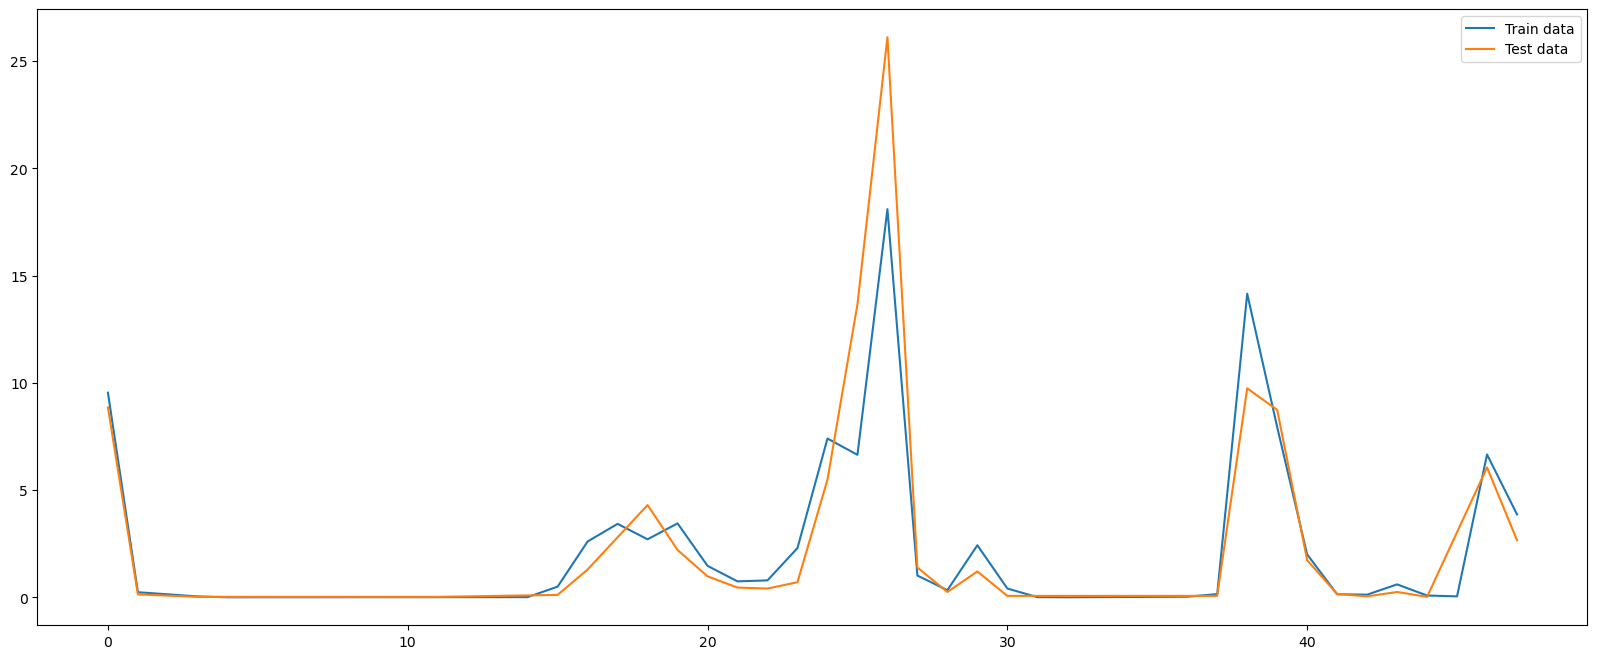

In [172]:
plt.figure(figsize=(20, 8))

plt.plot(count1.index, count1.values, linestyle='-', label='Train data')
plt.plot(count2.index, count2.values, linestyle='-', label='Test data')

plt.legend()
plt.show()

<br>

Intervals frequency in the training set:

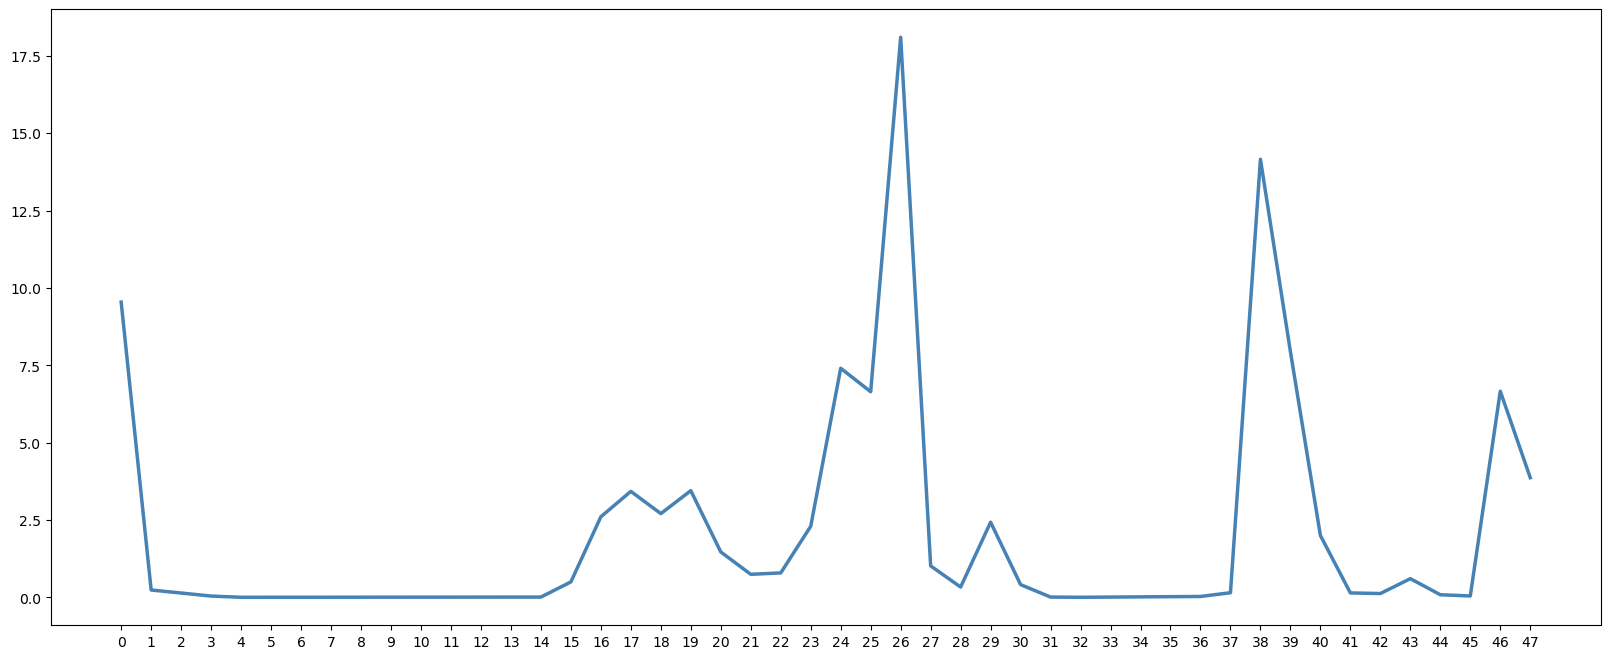

In [173]:
plt.figure(figsize=(20, 8))

plt.plot(count1.index, count1.values, linestyle='-', label='Train data', color = 'steelblue', linewidth=2.5)
plt.xticks(range(48))
plt.show()

<br>

Frequencies per region:

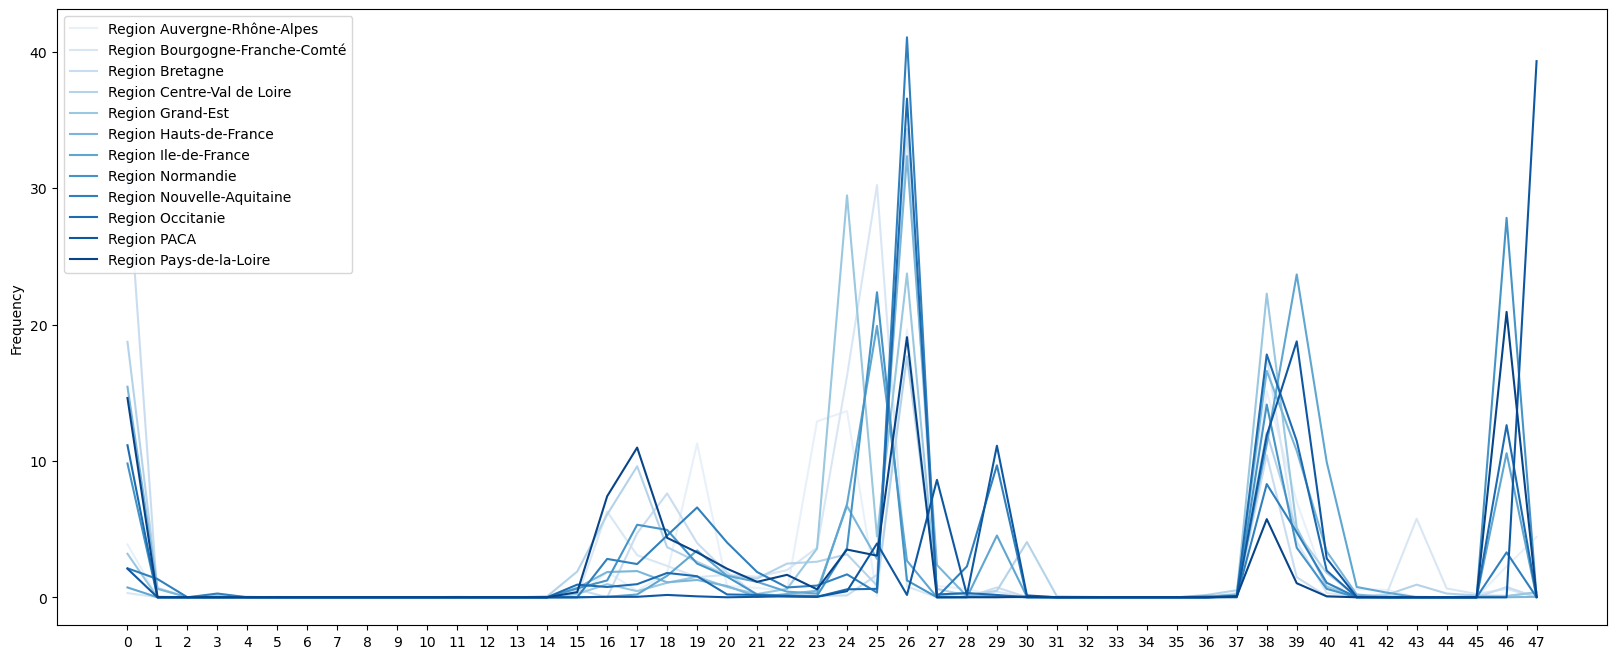

In [174]:
regiones = days_data['region'].unique()

palette = sns.color_palette("Blues", len(regiones))

plt.figure(figsize=(20, 8))

for i, region in enumerate(regiones):
    region_data = days_data[days_data['region'] == region]
    count = region_data['peak_half_hour'].value_counts().sort_index()
    
    count = count.reindex(range(48), fill_value=0)
    
    count1 = count / len(region_data) * 100
    plt.plot(count1.index, count1.values, linestyle='-', label=f'Region {region}', linewidth=1.5, color=palette[i])

plt.xticks(range(48))
plt.ylabel('Frequency')
plt.legend()
plt.show()

<br>

Frequencies per season:

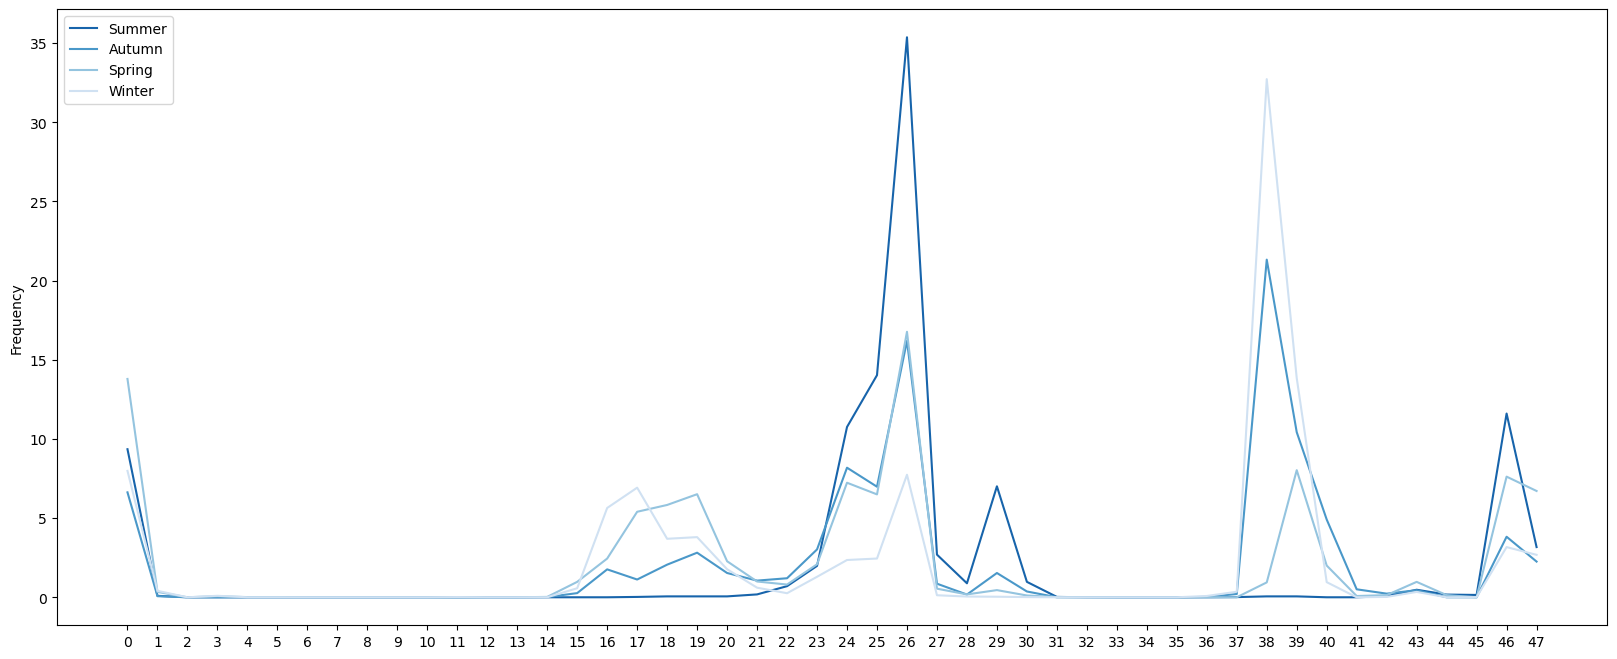

In [175]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

days_data['Season'] = days_data['month'].apply(get_season)
seasons = ['Summer', 'Autumn', 'Spring', 'Winter']  

palette = sns.color_palette("Blues", len(seasons))
palette = palette[::-1]

colors = {season: palette[i] for i, season in enumerate(seasons)}

plt.figure(figsize=(20, 8))

for season in seasons:
    season_data = days_data[days_data['Season'] == season]
    count = season_data['peak_half_hour'].value_counts().sort_index()
    
    count = count.reindex(range(48), fill_value=0)
    
    count1 = count / len(season_data) * 100
    plt.plot(count1.index, count1.values, linestyle='-', label=season, linewidth=1.5, color=colors[season])

plt.xticks(range(48))
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

<br>

#### Analysis using SVM

In [178]:
y_pred = svm_model_cat_best.predict(X_test_cat_svm)

accuracy = (y_pred == y_test_cat).sum() / len(y_test_cat) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy,2)} %')

mae_y_pred_red = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred_red,2))

Accuracy: 55.1 %
Accuracy within a ±1 hour range: 69.69 %

MAE: 5.65


<br>

In [179]:
df_cat = pd.DataFrame({'Final predictions': y_pred, 'Real values': y_test_cat})
df_cat['Final predictions'].unique()

array([38, 39,  0, 19, 26, 24, 46, 25, 16, 17, 18, 40, 29, 47],
      dtype=int64)

In [180]:
len(df_cat['Final predictions'].unique())

14

<br>

Where is the model having errors?

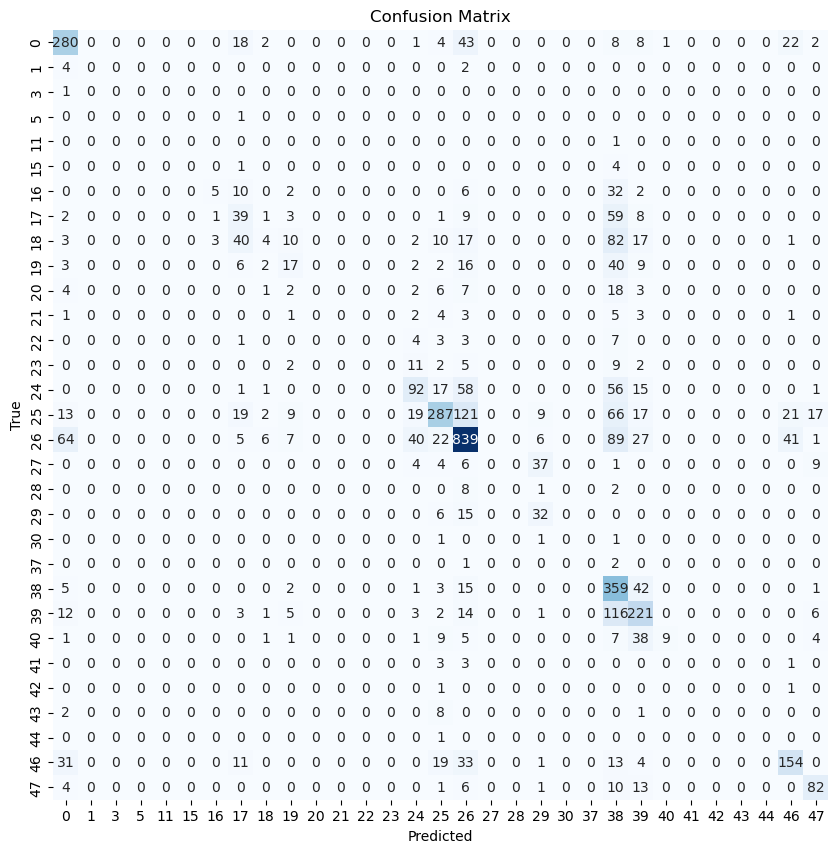

In [181]:
class_names = np.unique(np.concatenate([df_cat['Final predictions'].unique(), df_cat['Real values'].unique()]))
class_names = np.sort(class_names)

conf_matrix = confusion_matrix(y_test_cat, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.savefig('confusion_matrix_svm.png')
plt.show()

<br>

Will it improve using **SMOTE**?

In [182]:
unique_classes, class_counts = np.unique(y_train_cat, return_counts=True)
singleton_classes = unique_classes[class_counts < 5]
singleton_indices = np.isin(y_train_cat, singleton_classes)

X_train_cat_svm_filtered = X_train_cat_svm[~singleton_indices]
y_train_cat_filtered = y_train_cat[~singleton_indices]

In [183]:
best_params = {'C': 0.0027271797518572598, 'kernel': 'linear', 'gamma': 'auto'}

In [184]:
smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy = "all")
X_train_cat_smote, y_train_cat_smote = smote.fit_resample(X_train_cat_svm_filtered, y_train_cat_filtered)

svm_model_cat_best_smote = SVC(random_state=42, **best_params)
svm_model_cat_best_smote.fit(X_train_cat_smote, y_train_cat_smote)

y_pred = svm_model_cat_best_smote.predict(X_test_cat_svm)

accuracy = (y_pred == y_test_cat).sum() / len(y_test_cat) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy,2)} %')

mae_y_pred_red = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred_red,2))

Accuracy: 42.94 %
Accuracy within a ±1 hour range: 64.0 %

MAE: 5.8


<br>

In [185]:
df_cat = pd.DataFrame({'Final predictions': y_pred, 'Real values': y_test_cat})
df_cat['Final predictions'].unique()

array([38, 19, 39, 23, 21,  0, 42, 41, 18, 28, 26, 22, 47, 46, 24, 40, 37,
       36, 43, 25, 20, 16, 15, 17, 44, 45,  1, 30,  3, 27, 29],
      dtype=int64)

In [186]:
len(df_cat['Final predictions'].unique())

31

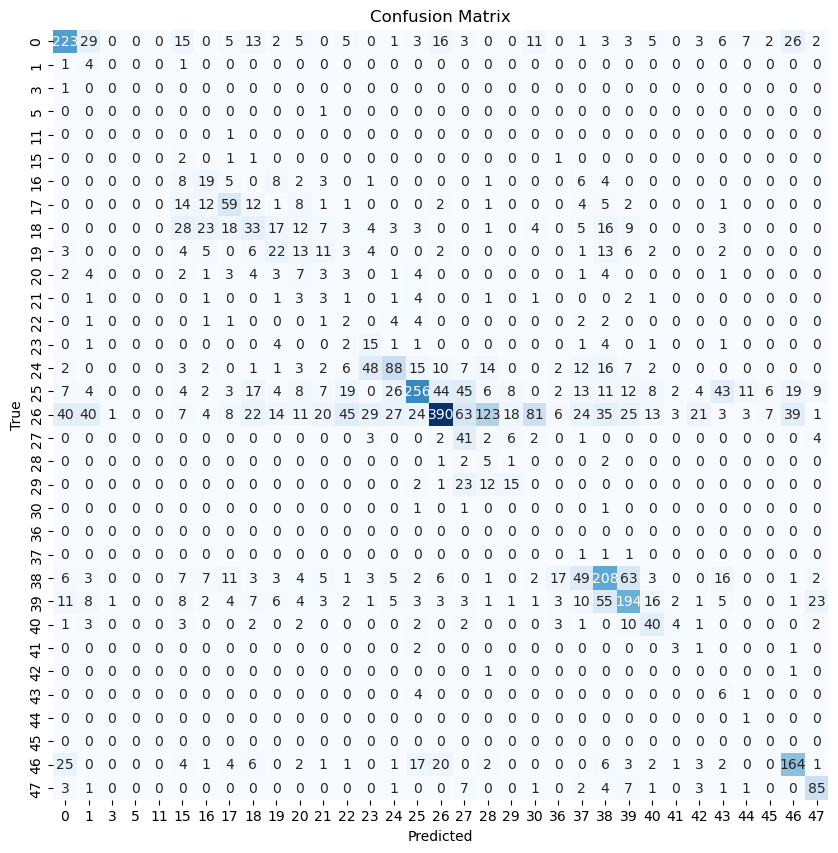

In [187]:
class_names = np.unique(np.concatenate([df_cat['Final predictions'].unique(), df_cat['Real values'].unique()]))
class_names = np.sort(class_names)

conf_matrix = confusion_matrix(y_test_cat, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.savefig('confusion_matrix_svm_smote.png')
plt.show()

<br>

|      | Accuracy | **±1 hour range accuracy** | **MAE** | **Considered classes** |
|-------------------|--------------|----------------------------|---------|------------------------|
| Without SMOTE     | **55.10**       | **69.69**                     | **5.65**    | 14                     |
| With SMOTE        | 42.94      | 64.00                    | 5.80    | 31                     |

<br>

**Best approach**: Without SMOTE.


<br>

#### Analysis using the best approach  ( MLP Classification ) 

In [189]:
y_pred_prob = nn_model_cat_best.predict(X_test_cat_nn)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test_cat, y_pred) * 100
print("\nAccuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Accuracy: 58.47 %
Accuracy within a ±1 hour range: 75.36 %

MAE: 4.39


<br>

In [190]:
df_cat = pd.DataFrame({'Final predictions': y_pred, 'Real values': y_test_cat})
df_cat['Final predictions'].unique()

array([23, 38, 19, 39,  0, 26, 47, 24, 46, 40, 25, 16, 43, 17, 18, 29, 20,
       27], dtype=int64)

In [191]:
len(df_cat['Final predictions'].unique())

18

<br>

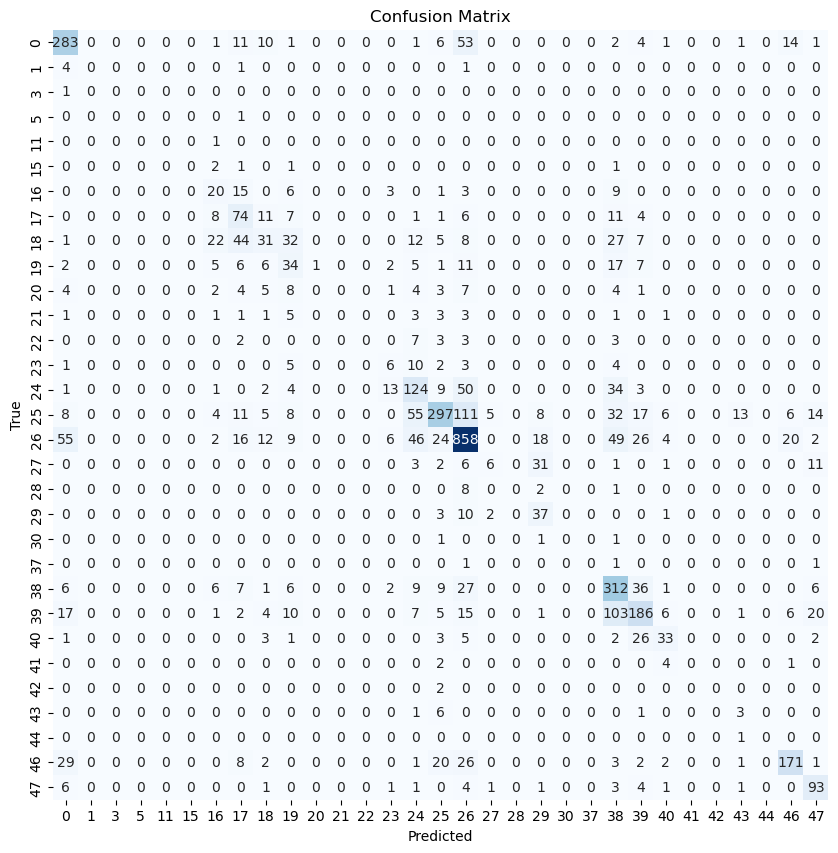

In [192]:
class_names = np.unique(np.concatenate([df_cat['Final predictions'].unique(), df_cat['Real values'].unique()]))
class_names = np.sort(class_names)

conf_matrix = confusion_matrix(y_test_cat, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.savefig('confusion_matrix_nn.png')
plt.show()

<br>

Using **SMOTE**:

In [193]:
unique_classes, class_counts = np.unique(y_train_cat, return_counts=True)
singleton_classes = unique_classes[class_counts < 5]
singleton_indices = np.isin(y_train_cat, singleton_classes)

X_train_cat_nn_filtered = X_train_cat_nn[~singleton_indices]
y_train_cat_filtered = y_train_cat[~singleton_indices]

In [194]:
best_params = {'n_layers': 2, 'units': 56, 'learning_rate': 0.0005289952047902762, 'batch_size': 44, 'dropout_rate': 0.08167052043499667, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00022400329755390964}

In [195]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy = "all")
X_train_cat_smote, y_train_cat_smote = smote.fit_resample(X_train_cat_nn_filtered, y_train_cat_filtered)

best_units = best_params['units']
best_n_layers = best_params['n_layers']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_dropout_rate = best_params['dropout_rate']
best_optimizer_name = best_params['optimizer']
best_activation = best_params['activation']
best_l2_regularization = best_params['l2_regularization']

nn_model_cat_best_smote = Sequential()
nn_model_cat_best_smote.add(Dense(best_units, input_dim=X_train_cat_smote.shape[1], activation=best_activation, kernel_regularizer=tf.keras.regularizers.l2(best_l2_regularization)))
nn_model_cat_best_smote.add(Dropout(best_dropout_rate))

for _ in range(best_n_layers):
    nn_model_cat_best_smote.add(Dense(best_units, activation=best_activation, kernel_regularizer=tf.keras.regularizers.l2(best_l2_regularization)))
    nn_model_cat_best_smote.add(Dropout(best_dropout_rate))

nn_model_cat_best_smote.add(Dense(48, activation='softmax'))

if best_optimizer_name == 'Adam':
    best_optimizer = Adam(learning_rate=best_learning_rate)
elif best_optimizer_name == 'SGD':
    best_optimizer = SGD(learning_rate=best_learning_rate)
elif best_optimizer_name == 'RMSprop':
    best_optimizer = RMSprop(learning_rate=best_learning_rate)

nn_model_cat_best_smote.compile(optimizer=best_optimizer,
                          loss=SparseCategoricalCrossentropy(),
                          metrics=[SparseCategoricalAccuracy()])

history = nn_model_cat_best_smote.fit(X_train_cat_smote, y_train_cat_smote, epochs=50, batch_size=best_batch_size, validation_data=(X_test_cat_nn, y_test_cat), verbose=0)

y_pred_prob = nn_model_cat_best_smote.predict(X_test_cat_nn)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test_cat, y_pred) * 100
print("\nAccuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Accuracy: 46.9 %
Accuracy within a ±1 hour range: 67.21 %

MAE: 5.06


<br>

In [196]:
df_cat = pd.DataFrame({'Final predictions': y_pred, 'Real values': y_test_cat})
df_cat['Final predictions'].unique()

array([20, 19, 21, 38, 39, 16, 47,  0, 23, 26, 18, 42, 28, 22, 24, 46, 41,
       40, 37, 43, 25, 17, 44, 45, 15,  1, 27, 30,  3, 36, 29],
      dtype=int64)

In [197]:
len(df_cat['Final predictions'].unique())

31

<br>

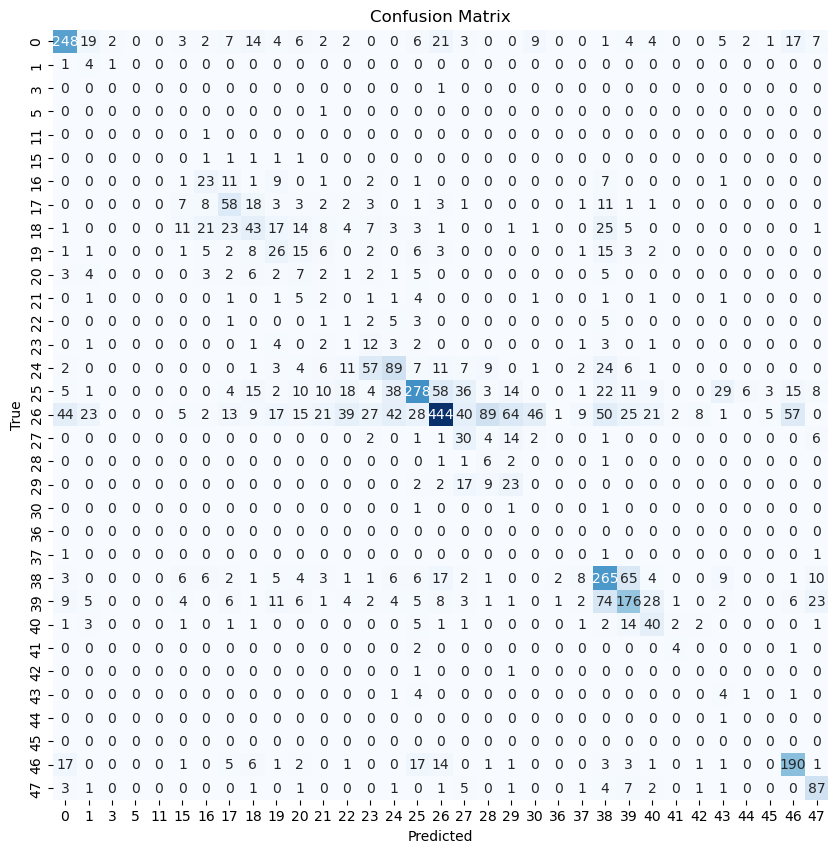

In [198]:
class_names = np.unique(np.concatenate([df_cat['Final predictions'].unique(), df_cat['Real values'].unique()]))
class_names = np.sort(class_names)

conf_matrix = confusion_matrix(y_test_cat, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.savefig('confusion_matrix_nn_smote.png')
plt.show()

<br>

|   | Accuracy | **±1 hour range accuracy** | **MAE** | **Considered classes** |
|-----------------|--------------|----------------------------|---------|------------------------|
| Without SMOTE   | **58.47**      | **75.36**                   | **4.39**    | 18                     |
| With SMOTE      | 46.90       | 67.21                    | 5.06    | 31                     |

<br>

**Best approach**: Without SMOTE.
